In [1]:
# !rm -rf DENTEX_000_test_image.png
# !rm -rf DENTEX_015_test_image.png

Ячейка 1

In [2]:
# 1. Установка необходимых библиотек
!pip install -q tensorflow opencv-python matplotlib scikit-learn scikit-image huggingface_hub

# Импорт необходимых библиотек
import gc
import os
import json
import psutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import random
import time
import shutil
from google.colab import drive
import glob
import subprocess
from tensorflow.keras import mixed_precision

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


Ячейка 2

In [4]:
# Настройка памяти GPU, если доступна
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   try:
       for gpu in gpus:
           tf.config.experimental.set_memory_growth(gpu, True)
       print(f"Использование {len(gpus)} GPU")
   except RuntimeError as e:
       print(e)
else:
   print("GPU не обнаружен, используется CPU")

# Включение смешанной точности (mixed precision)
mixed_precision.set_global_policy('mixed_float16')
print("Включена смешанная точность (mixed_float16)")

# Монтирование Google Drive (если потребуется сохранить результаты)
try:
   drive.mount('/content/drive')
   print("Google Drive успешно примонтирован")
except:
   print("Не удалось примонтировать Google Drive, результаты будут сохранены локально")

# Создание директории для результатов
RESULTS_DIR = '/content/results'
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Создана директория для результатов: {RESULTS_DIR}")

# Улучшенное расписание скорости обучения с более длительной высокой скоростью для редких классов
def lr_schedule(epoch):
   initial_lr = 2e-4  # Увеличена начальная скорость обучения
   if epoch < 20:     # Длительнее период с высокой скоростью
       return initial_lr
   elif epoch < 40:
       return initial_lr * 0.5
   elif epoch < 60:
       return initial_lr * 0.25
   else:
       return initial_lr * 0.1

# Расширенная конфигурация системы с фокусом на редкие классы
CONFIG = {
   "img_size": 256,           # Сохраняем размер изображения
   "batch_size": 2,           # Сохраняем размер батча
   "epochs": 75,             # Увеличиваем количество эпох для надежного обучения редких классов
   "early_stopping": 25,      # Увеличиваем терпение, чтобы модель успела обучиться на редких классах
   "early_stopping_metric": "val_sensitivity_metric",  # Отслеживаем чувствительность вместо потери
   "learning_rate": 2e-4,     # Увеличена начальная скорость обучения
   "validation_split": 0.2,   # Доля данных для валидации
   "num_classes": 5,          # Количество классов (фон + 4 патологии)

   # Радикально пересмотренная настройка метрик с приоритетом чувствительности
   "target_metrics": {
       "sensitivity_weight": 5.0,    # Значительно увеличен вес чувствительности
       "specificity_weight": 0.5,    # Уменьшен вес специфичности
       "accuracy_weight": 0.2,       # Сильно снижен вес общей точности (часто вводит в заблуждение)
       "dice_weight": 3.5,           # Значительно увеличен вес F-меры
       "bce_weight": 1.0,            # Уменьшен вес BCE
       "calibration_weight": 1.0     # Уменьшен вес калибровки
   },

   # Резко усиленные веса для редких классов патологий
   "class_weights": {
        0: 0.04,           # Фон (дополнительно снижен для еще большего фокуса на патологии)
        1: 5.5,            # Кариес (немного увеличен)
        2: 9.0,           # Глубокий кариес (увеличен для лучшего обнаружения)
        3: 45.0,           # Периапикальные поражения (увеличен для критически редкого класса)
        4: 30.0            # Ретинированные зубы (увеличен)
    },

   # Расширенные параметры генератора и аугментации
   "use_enhanced_generator": True,    # Использовать расширенный генератор данных
   "augmentation_factor": 15,         # Удвоен фактор аугментации для редких классов
   "rare_class_oversampling": True,   # Включаем перевыборку редких классов
   "rare_class_multiplier": 5,        # Каждый редкий образец повторяется 3 раза

   # Усиленные параметры функции потерь
   "use_boundary_loss": True,         # Использовать компонент граничных потерь
   "boundary_loss_weight": 1.2,       # Увеличен вес компонента граничных потерь
   "use_temperature_scaling": True,   # Использовать температурное масштабирование
   "temperature_value": 1.2,          # Добавлен параметр температуры

   # Параметры улучшения для редких классов
   "use_mixed_precision": True,       # Использовать смешанную точность
   "use_focal_loss": True,            # Использовать focal loss для редких классов
   "focal_loss_gamma": 5.0,           # УВЕЛИЧЕН параметр гамма для focal loss (был 2.0)
   "focal_loss_alpha": 0.9,           # Добавлен параметр alpha для focal loss
   "dropout_rate": 0.5,               # Увеличена степень dropout для регуляризации
   "use_lr_schedule": True,           # Использовать расписание скорости обучения

   # Оптимизация архитектуры
   "use_attention_blocks": True,      # Использовать блоки внимания в U-Net
   "use_deep_supervision": True,      # Использовать глубокий надзор с промежуточными выходами
   "use_test_time_augmentation": True,# Использовать аугментацию при тестировании

   # Новые стратегии для борьбы с несбалансированностью
   "use_gradient_checkpointing": True,  # Включить gradient checkpointing для экономии памяти
   "use_weighted_sampling": True,       # Использовать взвешенную выборку по классам
   "class_balanced_loss": True,         # Использовать class-balanced loss
   "use_effective_number_samples": True,# Использовать effective number of samples для весов классов
   "effective_beta": 0.99,              # Параметр для effective number of samples

   # Стратегия обучения
   "cyclic_learning_rate": True,        # Использовать циклическую скорость обучения
   "warmup_epochs": 5,                  # Количество эпох разогрева
   "gradient_accumulation_steps": 4,    # Аккумулировать градиенты для эффективно увеличения батча

   # Параметры для активного обучения на сложных примерах
   "hard_mining": True,                 # Включить hard negative/positive mining
   "hard_mining_ratio": 0.5,            # Доля сложных примеров в батче

   # Балансирование данных
   "balanced_batch_sampling": True,     # Формировать батчи с балансированным распределением классов
   "min_rare_class_pixels": 200,        # Минимальное количество пикселей редкого класса в батче

    # Основные параметры
    'focal_loss_gamma': 4.5,             # Высокое значение для сильного фокуса на редких классах
    'adaptive_gamma': True,              # Включено автоматическое масштабирование гаммы
    'class_difficulty_aware': True,      # Включен учет сложности классов

    # Параметры для работы с редкими классами
    'rare_class_regularization': False,   # Включена регуляризация для редких классов
    'l2_reg_factor': 0.005,              # Мягкая регуляризация для предотвращения переобучения
    'extra_weighting_for_rare': True,    # Включена дополнительная корректировка весов редких классов
    'rare_boost_factor': 1.4,            # Фактор усиления редких классов

    # Параметры эффективного числа выборок
    'use_effective_number_samples': True, # Включен механизм эффективного числа образцов
    'effective_beta': 0.9925,             # Высокое значение для большего влияния на редкие классы

    # Параметры стабилизации обучения
    'loss_modulation': True,             # Включена модуляция потерь
    'modulation_threshold': 2.5,         # Порог после которого включается смягчение
    'modulation_factor': 0.75,           # Фактор смягчения для высоких значений потерь

    # Параметры баланса положительных/отрицательных примеров
    'neg_loss_factor': 0.45,              # Пониженное влияние отрицательных примеров для повышения чувствительности
}

# Включить дополнительный XLA-компилятор для ускорения
tf.config.optimizer.set_jit(True)
print("XLA-компилятор включен для ускорения вычислений")

# Более тщательная настройка памяти
if gpus:
   try:
       for gpu in gpus:
           # Устанавливаем динамический рост памяти
           tf.config.experimental.set_memory_growth(gpu, True)
           # Используем 95% доступной памяти для максимальной производительности
           tf.config.experimental.set_virtual_device_configuration(
               gpu,
               [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 14)]  # Увеличено до 14 ГБ
           )
       print("Установлено оптимальное ограничение памяти GPU")
   except RuntimeError as e:
       print(f"Ошибка при настройке ограничений памяти GPU: {e}")

# Добавляем механизм автоматической очистки памяти через колбэки
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def __init__(self, cleanup_frequency=10):
        super(MemoryCleanupCallback, self).__init__()
        self.cleanup_frequency = cleanup_frequency

    def on_batch_end(self, batch, logs=None):
        if batch % self.cleanup_frequency == 0:
            gc.collect()

    def on_epoch_end(self, epoch, logs=None):
        # Принудительная очистка памяти после каждой эпохи
        gc.collect()
        ram_usage = psutil.virtual_memory().percent
        print(f"Память после эпохи {epoch+1}: {psutil.virtual_memory().used / (1024**3):.2f} ГБ ({ram_usage}%)")

# Мониторинг использования памяти
ram_usage = psutil.virtual_memory().percent
print(f"Текущее использование RAM: {psutil.virtual_memory().used / (1024**3):.2f} ГБ ({ram_usage}%)")

# Печать итогового конфига для проверки
print(f"\nКОНФИГУРАЦИЯ С ФОКУСОМ НА РЕДКИЕ КЛАССЫ:")
print(f"Размер изображения: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"Размер батча: {CONFIG['batch_size']}")
print(f"Количество эпох: {CONFIG['epochs']}")
print(f"Фокус на чувствительность: x{CONFIG['target_metrics']['sensitivity_weight']} (вес)")
print(f"Focal Loss gamma: {CONFIG['focal_loss_gamma']} (выше = больше фокус на редкие классы)")
print(f"Веса редких классов: периапикальные поражения x{CONFIG['class_weights'][3]}, ретинированные зубы x{CONFIG['class_weights'][4]}")
print(f"Аугментация: {CONFIG['augmentation_factor']}x для стандартных, {CONFIG['augmentation_factor'] * CONFIG['rare_class_multiplier']}x для редких классов")
print(f"Балансирование батчей: {'Включено' if CONFIG.get('balanced_batch_sampling', False) else 'Отключено'}")
print(f"Стратегии обучения: Hard Mining {'✅' if CONFIG.get('hard_mining', False) else '❌'}, Class-Balanced Loss {'✅' if CONFIG.get('class_balanced_loss', False) else '❌'}")
print(f"\nМодель оптимизирована для максимальной чувствительности (обнаружения) редких патологий")

Использование 1 GPU
Включена смешанная точность (mixed_float16)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive успешно примонтирован
Создана директория для результатов: /content/results
XLA-компилятор включен для ускорения вычислений
Установлено оптимальное ограничение памяти GPU
Текущее использование RAM: 2.01 ГБ (5.2%)

КОНФИГУРАЦИЯ С ФОКУСОМ НА РЕДКИЕ КЛАССЫ:
Размер изображения: 256x256
Размер батча: 2
Количество эпох: 75
Фокус на чувствительность: x5.0 (вес)
Focal Loss gamma: 4.5 (выше = больше фокус на редкие классы)
Веса редких классов: периапикальные поражения x45.0, ретинированные зубы x30.0
Аугментация: 15x для стандартных, 75x для редких классов
Балансирование батчей: Включено
Стратегии обучения: Hard Mining ✅, Class-Balanced Loss ✅

Модель оптимизирована для максимальной чувствительности (обнаружения) редких патологий


Ячейка 3

In [5]:
# 3. Функция для загрузки датасета DENTEX
def download_dentex_dataset():
    """
    Скачивание и распаковка датасета DENTEX.
    """
    from huggingface_hub import snapshot_download
    # Путь для сохранения датасета
    dataset_path = '/content/DENTEX'
    # Проверяем, существует ли датасет
    if os.path.exists(dataset_path) and len(os.listdir(dataset_path)) > 0:
        print(f"Датасет уже скачан в {dataset_path}")
        return dataset_path
    print("Загрузка датасета DENTEX...")
    # Скачивание датасета с Hugging Face
    try:
        snapshot_download(
            repo_id="ibrahimhamamci/DENTEX",
            repo_type="dataset",
            local_dir=dataset_path,
            local_dir_use_symlinks=False
        )
        print(f"Датасет загружен в: {dataset_path}")
    except Exception as e:
        print(f"Ошибка при загрузке: {str(e)}")
        return None
    # Извлечение данных (если они в архиве)
    extracted_path = '/content/DENTEX_extracted'
    os.makedirs(extracted_path, exist_ok=True)
    # Проверка на наличие архивов
    archives = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.zip'):
                archives.append(os.path.join(root, file))
    # Распаковка архивов
    if archives:
        print("Распаковка архивов...")
        import zipfile
        for archive in archives:
            with zipfile.ZipFile(archive, 'r') as zip_ref:
                zip_ref.extractall(extracted_path)
        print(f"Данные распакованы в {extracted_path}")
        return extracted_path
    return dataset_path

# Загрузка датасета
dataset_path = download_dentex_dataset()
print(f"Путь к датасету: {dataset_path}")

# Функция для диагностики структуры датасета
def diagnose_dentex_dataset():
    """Функция для диагностики структуры датасета DENTEX"""
    print("\n=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===\n")

    # Проверяем основные директории
    base_dirs = ["/content/DENTEX", "/content/DENTEX_extracted"]
    for base_dir in base_dirs:
        if os.path.exists(base_dir):
            print(f"\n📁 Директория {base_dir} существует")

            # Показываем содержимое первого уровня
            contents = os.listdir(base_dir)
            print(f"  Содержимое ({len(contents)} элементов):")
            for item in contents[:10]:  # Показать первые 10
                item_path = os.path.join(base_dir, item)
                if os.path.isdir(item_path):
                    print(f"    📁 {item} (папка)")
                else:
                    print(f"    📄 {item} (файл)")

            if len(contents) > 10:
                print(f"    ... и еще {len(contents) - 10} элементов")

            # Проверяем наличие training_data
            training_path = os.path.join(base_dir, "training_data")
            if os.path.exists(training_path):
                print(f"\n  📁 Директория training_data найдена")

                # Проверяем поддиректории
                training_contents = os.listdir(training_path)
                print(f"    Содержимое ({len(training_contents)} элементов):")
                for item in training_contents:
                    print(f"      - {item}")

                # Проверяем наличие директории quadrant-enumeration-disease
                qed_path = os.path.join(training_path, "quadrant-enumeration-disease")
                if os.path.exists(qed_path):
                    print(f"\n    📁 Директория quadrant-enumeration-disease найдена")
                    qed_contents = os.listdir(qed_path)
                    print(f"      Содержимое ({len(qed_contents)} элементов):")
                    for item in qed_contents:
                        print(f"        - {item}")

                    # Проверяем директорию xrays
                    xrays_path = os.path.join(qed_path, "xrays")
                    if os.path.exists(xrays_path):
                        print(f"\n      📁 Директория xrays найдена!")
                        xrays_contents = os.listdir(xrays_path)
                        print(f"        Содержит {len(xrays_contents)} файлов")
                        print(f"        Примеры файлов: {', '.join(xrays_contents[:3])}")
                    else:
                        print(f"\n      ❌ Директория xrays НЕ найдена!")
                else:
                    print(f"\n    ❌ Директория quadrant-enumeration-disease НЕ найдена!")
            else:
                print(f"\n  ❌ Директория training_data НЕ найдена!")
        else:
            print(f"\n❌ Директория {base_dir} НЕ существует")

    # Ищем файлы аннотаций
    print("\n=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===\n")
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            json_files = [f for f in files if f.endswith('.json')]
            if json_files:
                print(f"Найдены JSON-файлы в {root}:")
                for json_file in json_files:
                    print(f"  - {json_file}")

    # Ищем PNG-файлы
    print("\n=== ПОИСК PNG-ФАЙЛОВ ===\n")
    png_locations = {}
    for base_dir in base_dirs:
        if not os.path.exists(base_dir):
            continue

        for root, dirs, files in os.walk(base_dir):
            png_files = [f for f in files if f.endswith('.png')]
            if png_files:
                png_locations[root] = len(png_files)

    # Сортируем по количеству файлов
    sorted_locations = sorted(png_locations.items(), key=lambda x: x[1], reverse=True)
    print(f"Найдено {len(sorted_locations)} директорий с PNG-файлами:")
    for location, count in sorted_locations:
        print(f"  - {location}: {count} файлов")
        if count > 0:
            # Показать примеры файлов
            examples = [f for f in os.listdir(location) if f.endswith('.png')][:3]
            print(f"    Примеры: {', '.join(examples)}")

    print("\n=== ДИАГНОСТИКА ЗАВЕРШЕНА ===\n")

# Запуск диагностики
diagnose_dentex_dataset()

Датасет уже скачан в /content/DENTEX
Путь к датасету: /content/DENTEX

=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===


📁 Директория /content/DENTEX существует
  Содержимое (5 элементов):
    📁 figures (папка)
    📄 README.md (файл)
    📁 DENTEX (папка)
    📁 .cache (папка)
    📄 .gitattributes (файл)

  ❌ Директория training_data НЕ найдена!

📁 Директория /content/DENTEX_extracted существует
  Содержимое (3 элементов):
    📁 training_data (папка)
    📁 validation_data (папка)
    📁 disease (папка)

  📁 Директория training_data найдена
    Содержимое (4 элементов):
      - quadrant
      - quadrant-enumeration-disease
      - quadrant_enumeration
      - unlabelled

    📁 Директория quadrant-enumeration-disease найдена
      Содержимое (2 элементов):
        - train_quadrant_enumeration_disease.json
        - xrays

      📁 Директория xrays найдена!
        Содержит 705 файлов
        Примеры файлов: train_86.png, train_554.png, train_433.png

=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===

Найдены JSON-файлы в 

In [6]:
# def diagnose_dentex_dataset():
#     """Функция для диагностики структуры датасета DENTEX"""
#     print("\n=== ДИАГНОСТИКА ДАТАСЕТА DENTEX ===\n")

#     # Проверяем основные директории
#     base_dirs = ["/content/DENTEX", "/content/DENTEX_extracted"]
#     for base_dir in base_dirs:
#         if os.path.exists(base_dir):
#             print(f"\n📁 Директория {base_dir} существует")

#             # Показываем содержимое первого уровня
#             contents = os.listdir(base_dir)
#             print(f"  Содержимое ({len(contents)} элементов):")
#             for item in contents[:10]:  # Показать первые 10
#                 item_path = os.path.join(base_dir, item)
#                 if os.path.isdir(item_path):
#                     print(f"    📁 {item} (папка)")
#                 else:
#                     print(f"    📄 {item} (файл)")

#             if len(contents) > 10:
#                 print(f"    ... и еще {len(contents) - 10} элементов")

#             # Проверяем наличие training_data
#             training_path = os.path.join(base_dir, "training_data")
#             if os.path.exists(training_path):
#                 print(f"\n  📁 Директория training_data найдена")

#                 # Проверяем поддиректории
#                 training_contents = os.listdir(training_path)
#                 print(f"    Содержимое ({len(training_contents)} элементов):")
#                 for item in training_contents:
#                     print(f"      - {item}")

#                 # Проверяем наличие директории quadrant-enumeration-disease
#                 qed_path = os.path.join(training_path, "quadrant-enumeration-disease")
#                 if os.path.exists(qed_path):
#                     print(f"\n    📁 Директория quadrant-enumeration-disease найдена")
#                     qed_contents = os.listdir(qed_path)
#                     print(f"      Содержимое ({len(qed_contents)} элементов):")
#                     for item in qed_contents:
#                         print(f"        - {item}")

#                     # Проверяем директорию xrays
#                     xrays_path = os.path.join(qed_path, "xrays")
#                     if os.path.exists(xrays_path):
#                         print(f"\n      📁 Директория xrays найдена!")
#                         xrays_contents = os.listdir(xrays_path)
#                         print(f"        Содержит {len(xrays_contents)} файлов")
#                         print(f"        Примеры файлов: {', '.join(xrays_contents[:3])}")
#                     else:
#                         print(f"\n      ❌ Директория xrays НЕ найдена!")
#                 else:
#                     print(f"\n    ❌ Директория quadrant-enumeration-disease НЕ найдена!")
#             else:
#                 print(f"\n  ❌ Директория training_data НЕ найдена!")
#         else:
#             print(f"\n❌ Директория {base_dir} НЕ существует")

#     # Ищем файлы аннотаций
#     print("\n=== ПОИСК ФАЙЛОВ АННОТАЦИЙ ===\n")
#     for base_dir in base_dirs:
#         if not os.path.exists(base_dir):
#             continue

#         for root, dirs, files in os.walk(base_dir):
#             json_files = [f for f in files if f.endswith('.json')]
#             if json_files:
#                 print(f"Найдены JSON-файлы в {root}:")
#                 for json_file in json_files:
#                     print(f"  - {json_file}")

#     # Ищем PNG-файлы
#     print("\n=== ПОИСК PNG-ФАЙЛОВ ===\n")
#     png_locations = {}
#     for base_dir in base_dirs:
#         if not os.path.exists(base_dir):
#             continue

#         for root, dirs, files in os.walk(base_dir):
#             png_files = [f for f in files if f.endswith('.png')]
#             if png_files:
#                 png_locations[root] = len(png_files)

#     # Сортируем по количеству файлов
#     sorted_locations = sorted(png_locations.items(), key=lambda x: x[1], reverse=True)
#     print(f"Найдено {len(sorted_locations)} директорий с PNG-файлами:")
#     for location, count in sorted_locations:
#         print(f"  - {location}: {count} файлов")
#         if count > 0:
#             # Показать примеры файлов
#             examples = [f for f in os.listdir(location) if f.endswith('.png')][:3]
#             print(f"    Примеры: {', '.join(examples)}")

#     print("\n=== ДИАГНОСТИКА ЗАВЕРШЕНА ===\n")

# # Запуск диагностики
# diagnose_dentex_dataset()

Проверка

In [7]:
# Проверка конкретного файла
def check_specific_file(file_path):
    """Проверка конкретного файла с подробной диагностикой"""
    print(f"\n=== ПРОВЕРКА ФАЙЛА {file_path} ===\n")

    # Проверка существования
    exists = os.path.exists(file_path)
    print(f"os.path.exists: {exists}")

    # Проверка через Path
    from pathlib import Path
    path_exists = Path(file_path).exists()
    print(f"Path.exists: {path_exists}")

    # Проверка родительской директории
    parent_dir = os.path.dirname(file_path)
    parent_exists = os.path.exists(parent_dir)
    print(f"Родительская директория {parent_dir} существует: {parent_exists}")

    if parent_exists:
        # Список файлов в родительской директории
        try:
            files = os.listdir(parent_dir)
            print(f"Файлы в родительской директории ({len(files)}):")

            # Ищем файл с похожим именем
            base_name = os.path.basename(file_path)
            similar_files = [f for f in files if f.lower() == base_name.lower()]

            if similar_files:
                print(f"Найдены похожие файлы: {similar_files}")
            else:
                # Показать несколько примеров файлов
                print(f"Примеры файлов: {', '.join(files[:5])}")

                # Проверка на частичное совпадение
                partial_matches = [f for f in files if base_name[:5] in f]
                if partial_matches:
                    print(f"Частичные совпадения: {partial_matches}")
        except Exception as e:
            print(f"Ошибка при получении списка файлов: {e}")

    # Прямой доступ к файлу
    if exists:
        try:
            # Пробуем открыть файл
            with open(file_path, 'rb') as f:
                first_bytes = f.read(10)
                print(f"Успешно открыт файл, первые байты: {first_bytes}")
        except Exception as e:
            print(f"Ошибка при открытии файла: {e}")

    print("\n=== ПРОВЕРКА ЗАВЕРШЕНА ===\n")

# Проверим конкретный файл
check_specific_file('/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png')


=== ПРОВЕРКА ФАЙЛА /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays/train_435.png ===

os.path.exists: True
Path.exists: True
Родительская директория /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays существует: True
Файлы в родительской директории (705):
Найдены похожие файлы: ['train_435.png']
Успешно открыт файл, первые байты: b'\x89PNG\r\n\x1a\n\x00\x00'

=== ПРОВЕРКА ЗАВЕРШЕНА ===



Ячейка 4

In [8]:
# 4. Класс DENTEXDataset - с расширенной поддержкой мультиклассовой сегментации и оптимизированными генераторами
class DENTEXDataset:
    """
    Класс для работы с датасетом DENTEX с улучшенной поддержкой мультиклассовой сегментации
    """
    def __init__(self, base_dir, img_size=CONFIG["img_size"], batch_size=CONFIG["batch_size"]):
        """
        Инициализация класса для работы с данными DENTEX.

        Аргументы:
            base_dir (str): Корневая директория с данными DENTEX
            img_size (int): Размер изображения (одно значение, т.к. предполагаем квадратное изображение)
            batch_size (int): Размер батча для обучения
        """
        self.base_dir = Path(base_dir) if base_dir else None
        self.img_size = img_size
        self.batch_size = batch_size

        # Классы патологий
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Количество классов: фон (0) + 4 типа патологий
        self.num_classes = len(self.disease_classes)

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

        # Проверяем явно директорию DENTEX_extracted
        dentex_extracted = Path("/content/DENTEX_extracted")
        if dentex_extracted.exists() and (self.base_dir is None or not self.base_dir.exists()):
            print(f"Директория {self.base_dir} не найдена, используем {dentex_extracted}")
            self.base_dir = dentex_extracted

        # Пути к данным
        self.disease_xrays_dir = self._find_disease_xrays_dir()
        self.disease_annotations_file = self._find_disease_annotations_file()

        if not self.disease_xrays_dir or not self.disease_annotations_file:
            print("ВНИМАНИЕ: Не удалось найти пути к данным. Пути устанавливаются вручную.")

            # Используем известный путь к DENTEX_extracted, если он есть
            if dentex_extracted.exists():
                # Попробуем найти xrays рекурсивно
                xray_dirs = list(dentex_extracted.glob("**/xrays"))
                if xray_dirs:
                    self.disease_xrays_dir = xray_dirs[0]
                    print(f"Найдена директория с изображениями: {self.disease_xrays_dir}")
                else:
                    self.disease_xrays_dir = dentex_extracted
                    print(f"Используем корневую директорию: {self.disease_xrays_dir}")

                # Ищем JSON файлы
                json_files = list(dentex_extracted.glob("**/*.json"))
                if json_files:
                    self.disease_annotations_file = json_files[0]
                    print(f"Найден файл аннотаций: {self.disease_annotations_file}")
            else:
                # Стандартные пути по умолчанию
                self.disease_xrays_dir = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays")
                self.disease_annotations_file = Path("/content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json")

        print(f"Путь к изображениям: {self.disease_xrays_dir}")
        print(f"Путь к аннотациям: {self.disease_annotations_file}")

        # Загрузка классов из файла аннотаций
        self._load_class_definitions()

        # Загрузка изображений и аннотаций
        self.images = []
        self.annotations = []

        if self.disease_xrays_dir and self.disease_xrays_dir.exists():
            # Если нет файла аннотаций, просто загружаем изображения
            if not self.disease_annotations_file or not self.disease_annotations_file.exists():
                print("Файл аннотаций не найден. Загружаем только изображения без аннотаций.")
                self.images = [str(f) for f in self.disease_xrays_dir.glob("**/*.png")]
                self.annotations = [[] for _ in self.images]  # Пустые аннотации
                print(f"Загружено {len(self.images)} изображений без аннотаций")
            else:
                # Если есть и директория с изображениями, и файл аннотаций - загружаем всё
                self.images, self.annotations = self._load_annotations()
                print(f"Загружено {len(self.images)} изображений с аннотациями")
        else:
            print("ПРЕДУПРЕЖДЕНИЕ: Директория с изображениями не найдена!")

    def ensure_consistent_mask_shape(self, mask):
        """
        Проверяет и исправляет форму маски на соответствие ожидаемой

        Аргументы:
            mask: Входная маска

        Возвращает:
            np.array: Маска с исправленной формой
        """
        target_shape = (self.img_size, self.img_size, self.num_classes)

        # Если mask не является массивом numpy, создаем пустую маску
        if not isinstance(mask, np.ndarray):
            print(f"ПРЕДУПРЕЖДЕНИЕ: mask не является массивом numpy, создаем пустую маску")
            correct_mask = np.zeros(target_shape, dtype=np.float32)
            correct_mask[:, :, 0] = 1.0  # Фоновый класс
            return correct_mask

        # Если уже правильная форма, возвращаем как есть
        if mask.shape == target_shape:
            return mask

        # Сообщаем о необходимости коррекции формы
        print(f"Исправление маски с формой {mask.shape} на {target_shape}")

        # Создаем маску нужной формы
        correct_mask = np.zeros(target_shape, dtype=np.float16)

        # Если mask имеет неожиданную размерность
        if len(mask.shape) != len(target_shape):
            if len(mask.shape) == 2:  # Если mask 2D
                # Преобразуем 2D маску в 3D one-hot представление
                for c in range(self.num_classes):
                    correct_mask[:mask.shape[0], :mask.shape[1], c] = (mask == c).astype(np.float32)
            else:
                # Для других необычных случаев просто заполняем фоновым классом
                correct_mask[:, :, 0] = 1.0
            return correct_mask

        # Обычная коррекция с копированием данных насколько это возможно
        try:
            min_h = min(mask.shape[0], target_shape[0])
            min_w = min(mask.shape[1], target_shape[1])

            if len(mask.shape) == 3 and mask.shape[2] >= 1:
                min_c = min(mask.shape[2], target_shape[2])
                correct_mask[:min_h, :min_w, :min_c] = mask[:min_h, :min_w, :min_c]
            else:
                # Особый случай для двумерной маски
                for c in range(self.num_classes):
                    if c == 0:  # Фон
                        correct_mask[:min_h, :min_w, c] = 1.0
        except Exception as e:
            print(f"Ошибка при коррекции формы маски: {e}")
            # В случае любой ошибки просто заполняем фоновым классом
            correct_mask[:, :, 0] = 1.0

        return correct_mask.astype('float16')

    def _find_disease_xrays_dir(self):
        """Поиск директории с рентгеновскими снимками с приоритетом training_data"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Приоритетные пути - сначала проверяем training_data
        priority_paths = [
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "training_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "xrays" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "xrays" if self.base_dir else None
        ]

        # Отфильтруем None значения
        priority_paths = [path for path in priority_paths if path is not None]

        # Проверим приоритетные пути ПЕРВЫМИ
        for path in priority_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    print(f"Найдена директория с изображениями по приоритетному пути: {path}")
                    return path

        # Дополнительные возможные пути
        possible_paths = [
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "xrays",
            dentex_extracted / "validation_data" / "quadrant_enumeration_disease" / "xrays",
            self.base_dir / "disease" / "xrays" if self.base_dir else None,
            self.base_dir / "xrays" if self.base_dir else None,
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Проверка дополнительных путей
        for path in possible_paths:
            if path.exists() and path.is_dir():
                if any(path.glob("*.png")):
                    return path

        # Используем рекурсивный поиск, но ТОЛЬКО если не нашли по приоритетным путям
        if dentex_extracted.exists():
            # Ищем директории с названием xrays
            xray_dirs = list(dentex_extracted.glob("**/xrays"))
            for xdir in xray_dirs:
                if any(xdir.glob("*.png")):
                    return xdir

        # Если абсолютно ничего не нашли, только тогда ищем любые PNG-файлы
        if dentex_extracted.exists():
            png_files = list(dentex_extracted.glob("**/*.png"))
            if png_files:
                parent_dir = png_files[0].parent
                print(f"ВНИМАНИЕ: Используем резервную директорию с PNG-файлами: {parent_dir}")
                return parent_dir

        return None

    def _find_disease_annotations_file(self):
        """Поиск файла с аннотациями"""
        # Проверяем, есть ли "/content/DENTEX_extracted" директория
        dentex_extracted = Path("/content/DENTEX_extracted")

        # Варианты возможных путей
        possible_paths = [
            # Пути к DENTEX_extracted
            dentex_extracted / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json",
            dentex_extracted / "validation_data" / "quadrant-enumeration-disease" / "val_quadrant_enumeration_disease.json",

            # Исходные пути относительно base_dir
            self.base_dir / "training_data" / "quadrant-enumeration-disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "training_data" / "quadrant_enumeration_disease" / "train_quadrant_enumeration_disease.json" if self.base_dir else None,
            self.base_dir / "disease" / "annotations.json" if self.base_dir else None,
            self.base_dir / "annotations.json" if self.base_dir else None
        ]

        # Отфильтруем None значения
        possible_paths = [path for path in possible_paths if path is not None]

        # Прямой путь к файлам JSON в DENTEX_extracted
        if dentex_extracted.exists():
            json_files = list(dentex_extracted.glob("**/*.json"))
            if json_files:
                # Фильтруем по ключевым словам
                for json_file in json_files:
                    if "quadrant" in str(json_file) and "disease" in str(json_file) and "train" in str(json_file):
                        possible_paths.insert(0, json_file)  # Добавляем с высоким приоритетом

                # Добавляем все найденные JSON файлы с низким приоритетом
                possible_paths.extend(json_files)

        # Проверка каждого пути
        for path in possible_paths:
            if path.exists() and path.is_file():
                return path

        return None

    def _load_class_definitions(self):
        """Загрузка определений классов из файла аннотаций"""
        if not self.disease_annotations_file or not self.disease_annotations_file.exists():
            print("Файл аннотаций не найден, используются стандартные определения классов")
            return

        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Загружаем определения категорий, если они есть
            if 'categories_1' in data:
                self.quadrant_categories = {cat['id']: cat['name'] for cat in data['categories_1']}
                print(f"Загружено {len(self.quadrant_categories)} категорий квадрантов")

            if 'categories_2' in data:
                self.tooth_categories = {cat['id']: cat['name'] for cat in data['categories_2']}
                print(f"Загружено {len(self.tooth_categories)} категорий номеров зубов")

            if 'categories_3' in data:
                self.disease_categories = {cat['id']: cat['name'] for cat in data['categories_3']}
                print(f"Загружено {len(self.disease_categories)} категорий заболеваний")

        except Exception as e:
            print(f"Ошибка при загрузке определений классов: {e}")
            import traceback
            traceback.print_exc()

    def _load_annotations(self):
        """
        Загрузка аннотаций из JSON-файла.

        Возвращает:
            tuple: (images, annotations) - списки путей к изображениям и их аннотаций
        """
        try:
            with open(self.disease_annotations_file, 'r') as f:
                data = json.load(f)

            # Проверяем, что файл содержит необходимые данные
            if 'images' not in data or 'annotations' not in data:
                print(f"Файл аннотаций в неожиданном формате. Ключи: {list(data.keys())}")
                return [], []

            # Создаем словарь изображений по ID
            images_dict = {img['id']: img for img in data['images']}

            # Группируем аннотации по ID изображения
            annotations_by_image = {}
            for ann in data['annotations']:
                img_id = ann['image_id']
                if img_id not in annotations_by_image:
                    annotations_by_image[img_id] = []
                annotations_by_image[img_id].append(ann)

            # Формируем списки изображений и аннотаций
            images = []
            annotations = []

            for img_id, img_data in images_dict.items():
                if img_id in annotations_by_image:
                    # Пробуем разные способы формирования пути к изображению
                    file_name = img_data['file_name']
                    base_name = os.path.basename(file_name)

                    # Варианты путей
                    img_paths = [
                        os.path.join(str(self.disease_xrays_dir), file_name),
                        os.path.join(str(self.disease_xrays_dir), base_name)
                    ]

                    # Проверяем существование файла
                    found = False
                    for img_path in img_paths:
                        if os.path.exists(img_path):
                            images.append(img_path)
                            annotations.append(annotations_by_image[img_id])
                            found = True
                            break

                    # Если файл не найден, проверяем все доступные PNG файлы
                    if not found:
                        # Ищем файлы с таким же базовым именем в директории
                        png_files = list(self.disease_xrays_dir.glob(f"**/{base_name}"))
                        if png_files:
                            images.append(str(png_files[0]))
                            annotations.append(annotations_by_image[img_id])
                        elif len(images) < 5:  # Ограничиваем вывод для первых 5 отсутствующих файлов
                            print(f"Не удалось найти изображение: {file_name}")

            return images, annotations
        except Exception as e:
            print(f"Ошибка при загрузке аннотаций: {e}")
            import traceback
            traceback.print_exc()
            return [], []

    def create_multiclass_masks(self, annotations, width, height):
        """
        Создание мультиклассовых масок на основе аннотаций с приоритизацией редких классов
        и улучшенным выделением границ.

        Аргументы:
            annotations (list): Список аннотаций для изображения
            width (int): Ширина изображения
            height (int): Высота изображения

        Возвращает:
            np.array: Мультиклассовая маска размером (height, width)
        """
        # Маска фона (класс 0), заполненная нулями
        mask = np.zeros((height, width), dtype=np.uint8)

        # Идентификаторы квадрантов, зубов и диагнозов для каждой аннотации
        locations = []

        # Сначала группируем аннотации по классам для приоритизации
        class_annotations = {i: [] for i in range(1, self.num_classes)}

        for ann in annotations:
            # Получаем тип патологии и преобразуем в класс 1-4
            disease_class = 1  # По умолчанию Caries

            if 'category_id_3' in ann:
                disease_id = ann.get('category_id_3', 0)
                disease_class = disease_id + 1  # Добавляем 1, т.к. 0 зарезервирован для фона

            # Добавляем в соответствующий список по классу
            class_annotations[disease_class].append(ann)

        # Приоритетный порядок обработки: сначала редкие классы (3, 4), затем более распространенные (2, 1)
        priority_order = [3, 4, 2, 1]

        # Обрабатываем аннотации в порядке приоритета
        for class_id in priority_order:
            for ann in class_annotations[class_id]:
                # Получаем информацию о квадранте и номере зуба
                quadrant_id = ann.get('category_id_1', 0)
                tooth_id = ann.get('category_id_2', 0)

                # Запоминаем расположение и тип патологии
                locations.append({
                    'quadrant': quadrant_id,
                    'tooth': tooth_id,
                    'disease': class_id
                })

                # Если есть сегментация в виде полигона
                if 'segmentation' in ann and ann['segmentation']:
                    # Обработка полигонов
                    for segment in ann['segmentation']:
                        # Формируем список точек для полигона
                        points = []
                        for i in range(0, len(segment), 2):
                            points.append((int(segment[i]), int(segment[i+1])))

                        # Создаем временное изображение для рисования полигона
                        temp_mask = Image.new('L', (width, height), 0)
                        ImageDraw.Draw(temp_mask).polygon(points, outline=class_id, fill=class_id)

                        # Обновляем маску: приоритет отдается текущему классу из-за порядка обработки
                        temp_array = np.array(temp_mask)
                        mask[temp_array == class_id] = class_id

                # Если есть bbox (ограничивающий прямоугольник)
                elif 'bbox' in ann:
                    x, y, w, h = map(int, ann['bbox'])
                    # Заполняем область класса патологии
                    mask[y:y+h, x:x+w] = class_id

        # Улучшаем маски с помощью морфологических операций
        for class_id in range(1, self.num_classes):
            # Создаем маску для текущего класса
            class_mask = (mask == class_id).astype(np.uint8)

            # Применяем морфологическое закрытие для сглаживания и заполнения пробелов
            kernel_size = 3
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_CLOSE, kernel)

            # Обновляем основную маску
            mask[class_mask == 1] = class_id

        return mask, locations

    def preprocess_image(self, image_path):
        """
        Улучшенная предобработка изображения с CLAHE и шумоподавлением с поддержкой float16.

        Аргументы:
            image_path (str): Путь к изображению

        Возвращает:
            np.array: Предобработанное изображение
        """
        # Загрузка изображения
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Применяем CLAHE для улучшения контраста
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img = clahe.apply(img)

        # Удаление шума с помощью медианной фильтрации
        img = cv2.medianBlur(img, 3)

        # Изменение размера
        img = cv2.resize(img, (self.img_size, self.img_size))

        # Нормализация с помощью z-score вместо простого деления на 255
        img = (img - np.mean(img)) / (np.std(img) + 1e-6)

        # Ограничиваем значения до диапазона [-3, 3] и масштабируем до [0, 1]
        img = np.clip(img, -3, 3)
        img = (img + 3) / 6

        # Добавление канала
        img = np.expand_dims(img, axis=-1)

        # Конвертация в float16 для экономии памяти
        img = img.astype('float16')

        return img

    def prepare_dataset(self, use_enhanced_generator=CONFIG["use_enhanced_generator"]):
        """
        Подготовка датасета для обучения и валидации.

        Аргументы:
            use_enhanced_generator (bool): Использовать ли расширенный генератор данных

        Возвращает:
            tuple: (train_generator, val_generator, train_count, val_count)
        """
        # Проверяем, есть ли изображения
        if len(self.images) == 0:
            print("ОШИБКА: Нет доступных изображений для обучения.")
            # Создаем пустые генераторы
            def empty_generator():
                while True:
                    # Возвращаем пустые батчи нужной формы
                    batch_x = np.zeros((self.batch_size, self.img_size, self.img_size, 1))
                    batch_y = np.zeros((self.batch_size, self.img_size, self.img_size, self.num_classes))
                    yield batch_x, batch_y

            return empty_generator(), empty_generator(), 0, 0

        # Разделение на обучающую и валидационную выборки
        train_idx, val_idx = train_test_split(
            range(len(self.images)),
            test_size=CONFIG["validation_split"],
            random_state=42
        )

        train_images = [self.images[i] for i in train_idx]
        train_annotations = [self.annotations[i] for i in train_idx]

        val_images = [self.images[i] for i in val_idx]
        val_annotations = [self.annotations[i] for i in val_idx]

        print(f"Обучающая выборка: {len(train_images)} изображений")
        print(f"Валидационная выборка: {len(val_images)} изображений")

        # Создание генераторов
        if use_enhanced_generator:
            print("Используется расширенный генератор данных с аугментацией редких классов")
            train_generator = self.enhanced_data_generator(train_images, train_annotations)
        else:
            train_generator = self.data_generator(train_images, train_annotations)

        # Для валидации всегда используем стандартный генератор
        val_generator = self.data_generator(val_images, val_annotations)

        return train_generator, val_generator, len(train_images), len(val_images)

    def data_generator(self, image_paths, annotations_list):
        """
        Оптимизированный стандартный генератор данных для обучения/валидации.
        Улучшен для эффективной работы с памятью и передачи данных на GPU.

        Аргументы:
            image_paths (list): Список путей к изображениям
            annotations_list (list): Список аннотаций для каждого изображения

        Yields:
            tuple: (batch_images, batch_masks) - батчи изображений и мультиклассовых масок
        """
        num_samples = len(image_paths)
        # Целевая форма для всех масок и изображений
        mask_target_shape = (self.img_size, self.img_size, self.num_classes)
        img_target_shape = (self.img_size, self.img_size, 1)

        # Пре-аллоцируем память для батчей фиксированного размера
        batch_images = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, self.img_size, self.img_size, self.num_classes), dtype=np.float32)

        # Создаем пустую маску только один раз для переиспользования
        empty_mask = np.zeros(mask_target_shape, dtype=np.float32)
        empty_mask[:, :, 0] = 1.0  # Фоновый класс

        while True:
            # Перемешиваем данные
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for start_idx in range(0, num_samples, self.batch_size):
                # Очищаем память только после каждых 10 батчей вместо каждого батча
                if start_idx % (self.batch_size * 10) == 0:
                    gc.collect()

                batch_indices = indices[start_idx:min(start_idx + self.batch_size, num_samples)]
                actual_batch_size = len(batch_indices)

                # Сбрасываем/очищаем текущий батч для переиспользования
                if batch_images.shape[0] != actual_batch_size:
                    # Если размер батча изменился (обычно в конце эпохи)
                    batch_images = np.zeros((actual_batch_size, self.img_size, self.img_size, 1), dtype=np.float32)
                    batch_masks = np.zeros((actual_batch_size, self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    batch_masks[:, :, :, 0] = 1.0  # Заполняем фоновый класс
                else:
                    # Просто сбрасываем к нулям
                    batch_images.fill(0)
                    batch_masks.fill(0)
                    batch_masks[:, :, :, 0] = 1.0  # Заполняем фоновый класс

                for i, idx in enumerate(batch_indices):
                    if i >= actual_batch_size:
                        break

                    try:
                        # Загружаем и предобрабатываем изображение
                        img_path = image_paths[idx]
                        img = self.preprocess_image(img_path)

                        # Получаем оригинальные размеры изображения без сохранения в памяти
                        with open(img_path, 'rb') as f:
                            img_bytes = f.read()
                        img_np = np.frombuffer(img_bytes, dtype=np.uint8)
                        orig_img = cv2.imdecode(img_np, cv2.IMREAD_GRAYSCALE)
                        height, width = orig_img.shape

                        # Важно - немедленно освобождаем память
                        del orig_img, img_bytes, img_np

                        # Создаем маску на основе аннотаций
                        mask, _ = self.create_multiclass_masks(annotations_list[idx], width, height)

                        # Изменяем размер маски
                        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

                        # Напрямую заполняем пре-аллоцированные массивы вместо создания новых
                        batch_images[i] = img

                        # Сбрасываем маску в батче
                        batch_masks[i].fill(0)

                        # One-hot кодирование
                        for c in range(self.num_classes):
                            batch_masks[i, :, :, c] = (mask == c).astype(np.float32)

                        # Важно освободить память
                        del mask

                    except Exception as e:
                        print(f"Ошибка при обработке изображения {idx}: {e}")
                        # В случае ошибки просто оставляем нулевые значения и фоновый класс

                # Передаем данные модели
                if actual_batch_size > 0:
                    # Вместо np.stack уже используем готовые массивы
                    yield batch_images, batch_masks
                else:
                    # В крайне редком случае, если батч оказался пустым
                    empty_images = np.zeros((1, self.img_size, self.img_size, 1), dtype=np.float32)
                    empty_batch_masks = np.zeros((1, self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    empty_batch_masks[:, :, :, 0] = 1.0
                    yield empty_images, empty_batch_masks
                    del empty_images, empty_batch_masks

    def enhanced_data_generator(self, image_paths, annotations_list):
        """
        Генератор данных с расширенной аугментацией на GPU для максимальной производительности.

        Аргументы:
            image_paths (list): Список путей к изображениям
            annotations_list (list): Список аннотаций для каждого изображения

        Yields:
            tuple: (batch_images, batch_masks) - батчи изображений и мультиклассовых масок
        """
        import numpy as np
        import tensorflow as tf

        # Определяем константы
        num_samples = len(image_paths)
        rare_classes = [3, 4]  # Периапикальные и ретинированные зубы

        # Функция расширенной аугментации на GPU с использованием tf.function для компиляции
        @tf.function
        def augment_on_gpu(image, mask):
            """
            Выполняет расширенную аугментацию на GPU с использованием операций TensorFlow.
            Без эластической деформации для обеспечения стабильности.

            Аргументы:
                image: Тензор изображения [H, W, 1]
                mask: Тензор маски [H, W]

            Возвращает:
                tuple: (augmented_image, augmented_mask)
            """
            # 1. Горизонтальное отражение (50% вероятность)
            if tf.random.uniform(()) > 0.5:
                image = tf.image.flip_left_right(image)
                mask_expanded = tf.expand_dims(mask, axis=2)
                mask_expanded = tf.image.flip_left_right(mask_expanded)
                mask = tf.squeeze(mask_expanded, axis=2)

            # 2. Вертикальное отражение (25% вероятность)
            if tf.random.uniform(()) > 0.75:
                image = tf.image.flip_up_down(image)
                mask_expanded = tf.expand_dims(mask, axis=2)
                mask_expanded = tf.image.flip_up_down(mask_expanded)
                mask = tf.squeeze(mask_expanded, axis=2)

            # 3. Поворот на 90, 180 или 270 градусов (30% вероятность)
            if tf.random.uniform(()) > 0.7:
                k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
                image = tf.image.rot90(image, k=k)
                mask_expanded = tf.expand_dims(mask, axis=2)
                mask_expanded = tf.image.rot90(mask_expanded, k=k)
                mask = tf.squeeze(mask_expanded, axis=2)

            # 4. Изменение яркости (60% вероятность)
            if tf.random.uniform(()) > 0.4:
                image = tf.image.random_brightness(image, 0.15)
                image = tf.clip_by_value(image, 0.0, 1.0)

            # 5. Изменение контраста (60% вероятность)
            if tf.random.uniform(()) > 0.4:
                image = tf.image.random_contrast(image, 0.85, 1.15)
                image = tf.clip_by_value(image, 0.0, 1.0)

            # 6. Добавление шума (40% вероятность)
            if tf.random.uniform(()) > 0.6:
                noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.02)
                image = image + noise
                image = tf.clip_by_value(image, 0.0, 1.0)

            # 7. Изменение гаммы (30% вероятность)
            if tf.random.uniform(()) > 0.7:
                # Случайная гамма в пределах [0.8, 1.2]
                gamma = tf.random.uniform([], 0.8, 1.2)
                image = tf.pow(image, gamma)

            # 8. Случайный сдвиг (20% вероятность) - используем более простую версию
            if tf.random.uniform(()) > 0.8:
                # Выполняем отсечение и заполнение для имитации сдвига
                # Сдвиг по вертикали
                shift_h = tf.random.uniform([], -10, 10, dtype=tf.int32)
                # Сдвиг по горизонтали
                shift_w = tf.random.uniform([], -10, 10, dtype=tf.int32)

                # Получаем размеры изображения
                h = tf.shape(image)[0]
                w = tf.shape(image)[1]

                # Применяем сдвиг через отсечение и заполнение
                image = tf.image.crop_to_bounding_box(
                    tf.image.pad_to_bounding_box(
                        image,
                        tf.maximum(0, shift_h),
                        tf.maximum(0, shift_w),
                        h + tf.abs(shift_h),
                        w + tf.abs(shift_w)
                    ),
                    tf.maximum(0, -shift_h),
                    tf.maximum(0, -shift_w),
                    h, w
                )

                # Аналогично для маски
                mask_expanded = tf.expand_dims(mask, -1)
                mask_expanded = tf.image.crop_to_bounding_box(
                    tf.image.pad_to_bounding_box(
                        mask_expanded,
                        tf.maximum(0, shift_h),
                        tf.maximum(0, shift_w),
                        h + tf.abs(shift_h),
                        w + tf.abs(shift_w)
                    ),
                    tf.maximum(0, -shift_h),
                    tf.maximum(0, -shift_w),
                    h, w
                )
                mask = tf.squeeze(mask_expanded, -1)

            return image, mask

        # Функция для создания one-hot кодированной маски на GPU
        @tf.function
        def create_one_hot_mask(mask, num_classes):
            """
            Создает one-hot кодирование маски на GPU.

            Аргументы:
                mask: Тензор маски [H, W] с целочисленными метками классов
                num_classes: Количество классов

            Возвращает:
                one_hot_mask: Тензор [H, W, num_classes]
            """
            # Преобразуем маску в целочисленный тип
            mask = tf.cast(mask, tf.int32)
            # Создаем one-hot кодирование
            one_hot_mask = tf.one_hot(mask, depth=num_classes, dtype=tf.float32)
            return one_hot_mask

        # Основной цикл
        while True:
            # Перемешиваем индексы
            indices = np.random.permutation(num_samples)

            # Разбиваем на батчи
            for start_idx in range(0, num_samples, self.batch_size):
                # Определяем размер текущего батча
                batch_size = min(self.batch_size, num_samples - start_idx)

                # Списки для хранения данных батча
                batch_images = []
                batch_masks = []

                for idx in indices[start_idx:start_idx + batch_size]:
                    try:
                        # Загружаем изображение на CPU
                        img_path = image_paths[idx]
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is None:
                            continue

                        # Получаем размеры
                        height, width = img.shape

                        # Изменяем размер
                        img = cv2.resize(img, (self.img_size, self.img_size))

                        # Нормализуем к [0,1]
                        img = img.astype(np.float32) / 255.0

                        # Добавляем канал
                        img = np.expand_dims(img, axis=-1)

                        # Создаем маску на CPU
                        mask, _ = self.create_multiclass_masks(annotations_list[idx], width, height)
                        mask = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)

                        # Добавляем оригинальное изображение и маску
                        batch_images.append(img)
                        batch_masks.append(mask)

                        # Проверяем наличие редких классов
                        has_rare_class = np.any(np.isin(mask, rare_classes))

                        # Аугментация для редких классов (добавляем больше аугментаций)
                        if has_rare_class:
                            # Преобразуем в тензоры для GPU-аугментации
                            img_tensor = tf.convert_to_tensor(img)
                            mask_tensor = tf.convert_to_tensor(mask)

                            # Базовый множитель аугментации для редких классов
                            aug_multiplier = 3 if np.any(mask == 3) else 2  # Больше аугментаций для класса 3

                            # Создаем несколько аугментированных версий
                            for _ in range(aug_multiplier):
                                # Применяем аугментацию на GPU
                                aug_img, aug_mask = augment_on_gpu(img_tensor, mask_tensor)

                                # Преобразуем обратно в numpy для хранения
                                aug_img_np = aug_img.numpy()
                                aug_mask_np = aug_mask.numpy()

                                # Добавляем аугментированные данные
                                batch_images.append(aug_img_np)
                                batch_masks.append(aug_mask_np)

                        # Аугментация для обычных классов (с меньшей вероятностью)
                        elif np.random.rand() < 0.3:  # 30% шанс для обычных классов
                            # Преобразуем в тензоры для GPU-аугментации
                            img_tensor = tf.convert_to_tensor(img)
                            mask_tensor = tf.convert_to_tensor(mask)

                            # Применяем аугментацию на GPU
                            aug_img, aug_mask = augment_on_gpu(img_tensor, mask_tensor)

                            # Преобразуем обратно в numpy для хранения
                            aug_img_np = aug_img.numpy()
                            aug_mask_np = aug_mask.numpy()

                            # Добавляем аугментированные данные
                            batch_images.append(aug_img_np)
                            batch_masks.append(aug_mask_np)

                    except Exception as e:
                        print(f"Ошибка при обработке изображения {img_path}: {e}")
                        continue

                # Проверка на пустой батч
                if not batch_images:
                    empty_img = np.zeros((1, self.img_size, self.img_size, 1), dtype=np.float32)
                    empty_mask = np.zeros((1, self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    empty_mask[:, :, :, 0] = 1.0
                    yield empty_img, empty_mask
                    continue

                try:
                    # Преобразуем в numpy массивы
                    batch_images_np = np.stack(batch_images)

                    # Преобразуем маски в one-hot кодирование на GPU
                    batch_masks_tensor = tf.convert_to_tensor(np.stack(batch_masks))
                    batch_masks_onehot = create_one_hot_mask(batch_masks_tensor, self.num_classes)
                    batch_masks_np = batch_masks_onehot.numpy()

                    yield batch_images_np, batch_masks_np

                except Exception as e:
                    print(f"Ошибка при формировании батча: {e}")
                    # Если возникла ошибка, возвращаем пустой батч
                    empty_img = np.zeros((1, self.img_size, self.img_size, 1), dtype=np.float32)
                    empty_mask = np.zeros((1, self.img_size, self.img_size, self.num_classes), dtype=np.float32)
                    empty_mask[:, :, :, 0] = 1.0
                    yield empty_img, empty_mask

    def get_sample_weights(self, batch_masks):
        """
        Создает веса для каждого образца в батче, повышая значимость образцов с редкими классами

        Аргументы:
            batch_masks: Маски в формате one-hot для батча

        Возвращает:
            np.array: Веса для каждого образца в батче
        """
        sample_weights = np.ones(batch_masks.shape[0])

        for i in range(batch_masks.shape[0]):
            # Проверяем наличие каждого класса в маске
            for class_id in range(1, self.num_classes):
                # Если класс присутствует
                if np.any(batch_masks[i, :, :, class_id] > 0):
                    # Увеличиваем вес в соответствии с CONFIG
                    if class_id in CONFIG["class_weights"]:
                        sample_weights[i] *= CONFIG["class_weights"][class_id]

        # Нормализуем веса для стабильности обучения
        if np.sum(sample_weights) > 0:
            sample_weights = sample_weights / np.mean(sample_weights)

        return sample_weights

    def visualize_samples(self, num_samples=3, visualization_style='simple'):
        """
        Визуализация случайных образцов из датасета с отображением типов заболеваний.
        Метод НЕ делает предсказаний, а только показывает примеры из датасета.

        Аргументы:
            num_samples (int): Количество образцов для визуализации
            visualization_style (str): Стиль визуализации:
                'simple' - обычный режим
                'no_labels' - без текстовых меток
                'smart_labels' - интеллектуальное размещение без наложения
                'numbered' - нумерация областей
        """
        if len(self.images) == 0:
            print("Нет доступных изображений для визуализации")
            return

        # Выбираем случайные индексы
        indices = np.random.choice(len(self.images), min(num_samples, len(self.images)), replace=False)

        for i, idx in enumerate(indices):
            # Создаем фигуру для каждого образца
            plt.figure(figsize=(12, 8))

            # Загружаем изображение
            img_path = self.images[idx]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Получаем размеры изображения
            height, width = img.shape

            # Создаем мультиклассовую маску
            mask, locations = self.create_multiclass_masks(self.annotations[idx], width, height)

            # Создаем цветную маску для визуализации
            color_mask = np.zeros((height, width, 3), dtype=np.uint8)
            for class_id, color in self.class_colors.items():
                color_mask[mask == class_id] = color

            # Отображаем изображение и наложение
            plt.subplot(1, 2, 1)
            plt.title(f"Изображение {i+1}", fontsize=14)
            plt.imshow(img, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.title(f"Маска патологий {i+1}", fontsize=14)
            plt.imshow(img, cmap='gray')
            plt.imshow(color_mask, alpha=0.5)

            # Обработка различных стилей визуализации
            if visualization_style == 'no_labels':
                # Без меток
                pass
            elif visualization_style == 'simple':
                # Обычные метки (могут перекрываться)
                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        label = f"Q: {quadrant} N: {tooth} D: {disease_name}"
                        plt.text(x, y, label, color='white', backgroundcolor='black', fontsize=8)
            elif visualization_style == 'smart_labels':
                # Рисуем прямоугольники и размещаем текст без наложения
                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        # Добавляем прямоугольник
                        rect = plt.Rectangle((x, y), w, h,
                                          fill=False,
                                          edgecolor=np.array(self.class_colors[disease_class])/255,
                                          linewidth=2)
                        plt.gca().add_patch(rect)

                        # Определяем позицию текста в зависимости от положения на изображении
                        if y < height // 2:
                            text_y = y - 15  # Над прямоугольником
                            va = 'bottom'
                        else:
                            text_y = y + h + 5  # Под прямоугольником
                            va = 'top'

                        if x < width // 2:
                            text_x = x  # Слева
                            ha = 'left'
                        else:
                            text_x = x + w  # Справа
                            ha = 'right'

                        # Добавляем текст
                        label = f"Q: {quadrant} N: {tooth} D: {disease_name}"
                        plt.text(text_x, text_y, label,
                               ha=ha, va=va,
                               color='white',
                               fontsize=8,
                               bbox=dict(facecolor='black', alpha=0.7, pad=1))
            elif visualization_style == 'numbered':
                # Нумерованные области с легендой справа
                region_numbers = {}
                current_num = 1

                for ann in self.annotations[idx]:
                    if 'bbox' in ann:
                        x, y, w, h = map(int, ann['bbox'])
                        center_x, center_y = x + w//2, y + h//2

                        # Данные о патологии
                        quadrant = ann.get('category_id_1', 0)
                        tooth = ann.get('category_id_2', 0)
                        disease_id = ann.get('category_id_3', 0)
                        disease_class = disease_id + 1
                        disease_name = self.disease_classes.get(disease_class, "Unknown")

                        # Добавляем круг с номером
                        circle = plt.Circle((center_x, center_y), 15,
                                           facecolor='white', edgecolor='black',
                                           linewidth=1.5, alpha=0.9, zorder=100)
                        plt.gca().add_patch(circle)

                        plt.text(center_x, center_y, str(current_num),
                               ha='center', va='center',
                               fontsize=10, fontweight='bold',
                               color='black', zorder=101)

                        # Сохраняем информацию для легенды
                        region_numbers[current_num] = {
                            'quadrant': quadrant,
                            'tooth': tooth,
                            'disease_name': disease_name
                        }

                        current_num += 1

                # Добавляем легенду справа
                x_legend = 0.85
                y_legend = 0.95
                plt.figtext(x_legend, y_legend, "ЛЕГЕНДА", ha='center', va='top', fontsize=12, fontweight='bold')
                y_legend -= 0.05

                for num, data in sorted(region_numbers.items()):
                    legend_text = f"{num}: Q:{data['quadrant']} N:{data['tooth']} D:{data['disease_name']}"
                    plt.figtext(x_legend, y_legend, legend_text, ha='center', va='top', fontsize=9)
                    y_legend -= 0.03

            plt.tight_layout()
            plt.show()

Ячейка 5

In [9]:
# Добавьте в начало файла или ячейки:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f"Политика точности вычислений: {policy.name}")
# 5. Реализация модифицированной целевой функции для точных предсказаний в стоматологической сегментации
class DentalSegmentationLoss:
    """
    Улучшенная целевая функция для сегментации стоматологических снимков
    с акцентом на точность предсказаний и обнаружение редких патологий.

    f0(x) = P·c1 + S·c2 + A·c3 + F·c4 + BCE·c5 + CAL·c6 + BL·c7 + FL·c8
    где:
    - P: чувствительность
    - S: специфичность
    - A: точность
    - F: F-мера (Dice коэффициент)
    - BCE: бинарная кросс-энтропия (для точности вероятностей)
    - CAL: калибровочный компонент (для калибровки вероятностей)
    - BL: граничные потери (для точности контуров)
    - FL: focal loss (для редких классов)
    """

    def __init__(self, num_classes=CONFIG["num_classes"], class_weights=None, smooth=1e-5, config=None):
        """
        Инициализация функции потерь
        Args:
            num_classes: количество классов (включая фон)
            class_weights: словарь с весами для каждого класса патологии
            smooth: параметр сглаживания для предотвращения деления на ноль
            config: конфигурация параметров для продвинутых методов потери
        """
        self.smooth = smooth
        self.num_classes = num_classes
        # Если веса классов не заданы, используем предустановленные
        self.class_weights = class_weights if class_weights else CONFIG["class_weights"]
        # Добавляем конфигурацию как атрибут класса
        self.config = config if config is not None else CONFIG

    def dice_coefficient(self, y_true, y_pred):
        """
        Рассчитывает коэффициент Дайса (F1-мера для сегментации)
        """
        # Предотвращаем деление на ноль
        epsilon = self.smooth

        # Приводим оба тензора к одному типу float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Умножаем каждый пиксель предсказания на соответствующий пиксель истинной маски
        # и суммируем по всем пикселям
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)

        # Dice = (2 * |X ∩ Y|) / (|X| + |Y|)
        dice = (2. * intersection + epsilon) / (K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)

        return dice

    def weighted_dice_coefficient(self, y_true, y_pred):
        """
        Взвешенный коэффициент Дайса с учетом важности разных классов патологий
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        dice_scores = []
        weights = []

        # Рассчитываем Dice для каждого класса отдельно
        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            # Выделяем маски для текущего класса
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Рассчитываем Dice для класса
            dice = self.dice_coefficient(y_true_class, y_pred_class)

            dice_scores.append(dice)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры и приводим к float32
        weights = tf.cast(K.constant(weights), tf.float32)
        dice_scores = tf.cast(K.stack(dice_scores), tf.float32)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(dice_scores * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def sensitivity(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает чувствительность (полноту) для каждого класса патологии
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        y_pred_bin = K.cast(K.greater(y_pred, threshold), tf.float32)

        sensitivities = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred_bin[..., class_idx]

            # True Positives и False Negatives
            tp = K.sum(y_true_class * y_pred_class)
            fn = K.sum(y_true_class * (1 - y_pred_class))

            # Чувствительность = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)

            sensitivities.append(sensitivity)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры и приводим к float32
        weights = tf.cast(K.constant(weights), tf.float32)
        sensitivities = tf.cast(K.stack(sensitivities), tf.float32)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(sensitivities * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def specificity(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает специфичность для каждого класса патологии
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        y_pred_bin = K.cast(K.greater(y_pred, threshold), tf.float32)

        specificities = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred_bin[..., class_idx]

            # True Negatives и False Positives
            tn = K.sum((1 - y_true_class) * (1 - y_pred_class))
            fp = K.sum((1 - y_true_class) * y_pred_class)

            # Специфичность = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)

            specificities.append(specificity)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры и приводим к float32
        weights = tf.cast(K.constant(weights), tf.float32)
        specificities = tf.cast(K.stack(specificities), tf.float32)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(specificities * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def accuracy(self, y_true, y_pred, threshold=0.5):
        """
        Рассчитывает точность сегментации
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Преобразуем предсказания в бинарные метки
        y_pred_bin = K.cast(K.greater(y_pred, threshold), tf.float32)

        # Сравниваем истинные и предсказанные метки
        correct = K.cast(K.equal(y_true, y_pred_bin), tf.float32)

        # Рассчитываем среднюю точность
        acc = K.mean(correct)

        return acc

    def binary_crossentropy(self, y_true, y_pred, epsilon=1e-7):
        """
        Взвешенная бинарная кросс-энтропия для оценки точности вероятностей
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Обрезаем значения, чтобы избежать численной нестабильности
        y_pred = K.clip(y_pred, epsilon, 1 - epsilon)

        bce_values = []
        weights = []

        for class_idx in range(1, self.num_classes):  # Начинаем с 1, пропуская фон
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Бинарная кросс-энтропия для текущего класса
            bce = -K.mean(y_true_class * K.log(y_pred_class) +
                         (1 - y_true_class) * K.log(1 - y_pred_class))

            bce_values.append(bce)
            weights.append(self.class_weights.get(class_idx, 1.0))

        # Преобразуем в тензоры и приводим к float32
        weights = tf.cast(K.constant(weights), tf.float32)
        bce_values = tf.cast(K.stack(bce_values), tf.float32)

        # Рассчитываем взвешенное среднее
        weighted_avg = K.sum(bce_values * weights) / (K.sum(weights) + self.smooth)

        return weighted_avg

    def calibration_error(self, y_true, y_pred):
        """
        Приближенный расчет ошибки калибровки
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Упрощенная версия расчета ошибки калибровки
        cal_error = 0.0

        for class_idx in range(1, self.num_classes):
            y_true_class = K.flatten(y_true[..., class_idx])
            y_pred_class = K.flatten(y_pred[..., class_idx])

            # Средняя предсказанная вероятность
            mean_pred = K.mean(y_pred_class)

            # Фактическая частота
            mean_true = K.mean(y_true_class)

            # Разница между предсказанной вероятностью и фактической частотой
            class_error = K.abs(mean_pred - mean_true)

            cal_error += class_error * self.class_weights.get(class_idx, 1.0)

        weights_sum = tf.cast(K.sum(K.constant([self.class_weights.get(i, 1.0) for i in range(1, self.num_classes)])), tf.float32)
        return cal_error / weights_sum

    def boundary_loss(self, y_true, y_pred, kernel_size=3):
        """
        Улучшенный компонент потерь для точности границ сегментации
        с различными весами для разных классов
        """
        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Обработка для каждого класса патологии (без фона)
        boundary_loss_sum = 0.0

        for class_idx in range(1, self.num_classes):
            # Выделяем маски для текущего класса
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Выделяем границы на истинных масках
            # Идея: граница - это разница между расширенной и эрозированной маской
            y_true_expanded = tf.nn.max_pool2d(
                tf.expand_dims(y_true_class, axis=-1),
                kernel_size,
                strides=1,
                padding='SAME'
            )
            y_true_eroded = -tf.nn.max_pool2d(
                tf.expand_dims(-y_true_class, axis=-1),
                kernel_size,
                strides=1,
                padding='SAME'
            )

            # Получаем границы: области, присутствующие в расширенной, но отсутствующие в эрозированной маске
            boundary = tf.cast(tf.logical_and(
                tf.squeeze(y_true_expanded, axis=-1) > 0.5,
                tf.squeeze(y_true_eroded, axis=-1) < 0.5
            ), tf.float32)

            # Определяем разные веса для разных классов патологий
            class_boundary_weight = 5.0  # Базовый вес

            # Увеличиваем вес для редких классов (3 и 4)
            if class_idx == 3:  # Периапикальные поражения
                class_boundary_weight = 10.0
            elif class_idx == 4:  # Ретинированные зубы
                class_boundary_weight = 8.0

            # Обрезаем значения вероятностей для устойчивости вычислений
            y_pred_class_clipped = K.clip(y_pred_class, self.smooth, 1 - self.smooth)

            # Усиливаем вес ошибок на границах
            weighted_bce = -K.mean(
                (class_boundary_weight * boundary + 1.0) *
                (y_true_class * K.log(y_pred_class_clipped) +
                (1 - y_true_class) * K.log(1 - y_pred_class_clipped))
            )

            # Учитываем вес класса
            boundary_loss_sum += weighted_bce * self.class_weights.get(class_idx, 1.0)

        # Нормализуем по количеству классов и их весам
        total_weight = tf.cast(sum(self.class_weights.get(i, 1.0) for i in range(1, self.num_classes)), tf.float32)
        return boundary_loss_sum / (total_weight + self.smooth)

    def focal_loss(self, y_true, y_pred, gamma=None, alpha=None, adaptive_gamma=True, class_difficulty_aware=True):
        """
        Усовершенствованный Focal Loss с адаптивным гамма, учетом сложности классов и модуляцией весов
        """
        # Используем заданную гамму или берем из конфига
        if gamma is None:
            gamma = self.config.get('focal_loss_gamma', 5.0)

        # Приводим к float32 для стабильности вычислений
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Если alpha не задан, используем веса классов с дополнительной настройкой
        if alpha is None:
            alpha = []
            for i in range(1, self.num_classes):
                # Базовый вес из конфигурации
                base_weight = self.class_weights.get(i, 1.0)

                # Применяем коррекцию на основе эффективного количества примеров (для редких классов)
                if self.config.get('use_effective_number_samples', False):
                    beta = self.config.get('effective_beta', 0.99)
                    # Рассчитываем количество пикселей класса
                    class_samples = tf.reduce_sum(y_true[..., i])
                    # Эффективное количество выборок: (1-beta^n)/(1-beta)
                    effective_num = (1.0 - tf.pow(beta, class_samples)) / (1.0 - beta)
                    # Корректируем вес на основе эффективного количества
                    corrected_weight = base_weight * (1.0 / (effective_num + epsilon))
                    alpha.append(corrected_weight)
                else:
                    alpha.append(base_weight)

            # Нормализуем alpha для удобства использования
            total = sum(alpha) + epsilon
            alpha = [a / total for a in alpha]

        focal_losses = []
        class_gammas = []

        # Подготовка адаптивной гаммы для каждого класса
        if adaptive_gamma:
            for i in range(1, self.num_classes):
                # Для редких классов используем более высокую гамму
                class_freq = tf.reduce_mean(y_true[..., i])
                adaptive_gamma_value = gamma * (1.0 + 2.0 * tf.exp(-5.0 * class_freq))
                class_gammas.append(adaptive_gamma_value)
        else:
            class_gammas = [gamma] * (self.num_classes - 1)

        # Расчет сложности классов в текущем батче (если включено)
        class_difficulties = []
        if class_difficulty_aware:
            for class_idx in range(1, self.num_classes):
                y_true_class = y_true[..., class_idx]
                y_pred_class = y_pred[..., class_idx]

                # Маска положительных примеров
                pos_mask = tf.cast(y_true_class > 0.5, tf.float32)
                # Маска отрицательных примеров
                neg_mask = tf.cast(y_true_class <= 0.5, tf.float32)

                # Безопасно вычисляем сложность с использованием tf.cond
                pos_sum = tf.reduce_sum(pos_mask)
                neg_sum = tf.reduce_sum(neg_mask)

                # Используем tf.cond вместо Python if
                pos_difficulty = tf.cond(
                    pos_sum > 0,
                    lambda: tf.reduce_sum((1.0 - y_pred_class) * pos_mask) / (pos_sum + epsilon),
                    lambda: tf.constant(0.0, dtype=tf.float32)
                )

                neg_difficulty = tf.cond(
                    neg_sum > 0,
                    lambda: tf.reduce_sum(y_pred_class * neg_mask) / (neg_sum + epsilon),
                    lambda: tf.constant(0.0, dtype=tf.float32)
                )

                # Общая сложность как взвешенное среднее
                total_difficulty = (pos_difficulty + neg_difficulty) / 2.0
                class_difficulties.append(total_difficulty)

        # Считаем потери для каждого класса
        for idx, class_idx in enumerate(range(1, self.num_classes)):
            y_true_class = y_true[..., class_idx]
            y_pred_class = y_pred[..., class_idx]

            # Базовый вес класса из alpha
            class_weight = tf.cast(alpha[idx], tf.float32)

            # Применяем адаптивную гамму
            adaptive_gamma_value = class_gammas[idx]

            # Модифицируем веса с учетом сложности класса, если включено
            if class_difficulty_aware and class_difficulties:
                # Увеличиваем вес для сложных классов
                difficulty_factor = tf.cast(1.0 + class_difficulties[idx], tf.float32)
                class_weight = class_weight * difficulty_factor

            # Для положительных примеров (y_true=1)
            # Модифицированная формула: -alpha * (1-p)^gamma * log(p)
            pos_loss = -class_weight * K.pow(1.0 - y_pred_class, adaptive_gamma_value) * K.log(y_pred_class)

            # Для отрицательных примеров (y_true=0)
            # Модифицированная формула для более строгого наказания за ложноположительные
            neg_factor = self.config.get('neg_loss_factor', 0.5)  # Множитель для отрицательных примеров
            neg_loss = -neg_factor * (1.0 - class_weight) * K.pow(y_pred_class, adaptive_gamma_value) * K.log(1.0 - y_pred_class)

            # Комбинируем потери с учетом истинных меток
            loss = y_true_class * pos_loss + (1.0 - y_true_class) * neg_loss

            # Добавляем регуляризацию для редких классов (опционально)
            if self.config.get('rare_class_regularization', False) and self.class_weights.get(class_idx, 1.0) > 5.0:
                # Добавляем L2 регуляризацию для снижения переобучения на редких классах
                l2_reg_factor = self.config.get('l2_reg_factor', 0.01)
                reg_loss = l2_reg_factor * tf.square(y_pred_class - y_true_class)
                loss = loss + reg_loss

            focal_losses.append(K.mean(loss))

        # Рассчитываем взвешенное среднее с учетом важности классов
        weights = tf.cast(K.constant([self.class_weights.get(i, 1.0) for i in range(1, self.num_classes)]), tf.float32)

        # Опционально: применяем дополнительное взвешивание редких классов
        if self.config.get('extra_weighting_for_rare', False):
            # Находим самый редкий класс для нормализации весов
            max_weight = tf.reduce_max(weights)
            # Усиливаем важность редких классов дополнительно
            rare_boost = self.config.get('rare_boost_factor', 1.2)
            weights = weights * tf.pow(weights / max_weight, rare_boost - 1.0)

        focal_losses = tf.cast(K.stack(focal_losses), tf.float32)
        weighted_avg = K.sum(focal_losses * weights) / (K.sum(weights) + self.smooth)

        # Добавляем модуляцию потерь для стабилизации обучения
        if self.config.get('loss_modulation', False):
            # Если потери становятся слишком большими, смягчаем их влияние
            modulation_threshold = self.config.get('modulation_threshold', 2.0)
            modulation_factor = self.config.get('modulation_factor', 0.7)
            weighted_avg = tf.cond(
                weighted_avg > modulation_threshold,
                lambda: modulation_threshold + modulation_factor * (weighted_avg - modulation_threshold),
                lambda: weighted_avg
            )

        return weighted_avg

    def temperature_scaling(self, y_pred, temperature=1.0):
        """
        Температурное масштабирование для улучшения калибровки вероятностей

        Args:
            y_pred: Тензор предсказаний
            temperature: Параметр температуры (>1 делает распределение более плавным)
        """
        # Приводим к float32 для стабильности вычислений
        y_pred = tf.cast(y_pred, tf.float32)

        # Применяем только если активировано в конфигурации
        if CONFIG.get("use_temperature_scaling", False):
            # Преобразуем softmax prediction в logits
            epsilon = 1e-7
            y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
            logits = K.log(y_pred / (1.0 - y_pred))

            # Масштабируем логиты температурой
            scaled_logits = logits / temperature

            # Применяем softmax обратно
            scaled_pred = tf.nn.softmax(scaled_logits, axis=-1)
            return scaled_pred

        return y_pred

    def create_loss_function(self):
        """
        Создает улучшенную комбинированную функцию потерь для оптимизации модели

        Returns:
            Функция потерь для использования в compile_model
        """
        # Получаем веса для разных компонентов функции потерь
        c1 = CONFIG["target_metrics"]["sensitivity_weight"]
        c2 = CONFIG["target_metrics"]["specificity_weight"]
        c3 = CONFIG["target_metrics"]["accuracy_weight"]
        c4 = CONFIG["target_metrics"]["dice_weight"]
        c5 = CONFIG["target_metrics"]["bce_weight"]
        c6 = CONFIG["target_metrics"]["calibration_weight"]

        # Получаем вес граничного компонента из конфигурации
        boundary_weight = CONFIG.get("boundary_loss_weight", 0.5)

        # Параметры focal loss из конфигурации
        use_focal_loss = CONFIG.get("use_focal_loss", False)
        focal_gamma = CONFIG.get("focal_loss_gamma", 2.0)

        # Параметр температурного масштабирования
        temperature = 1.5  # Значение по умолчанию

        def loss(y_true, y_pred):
            # Приводим к float32 для стабильности вычислений
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)

            # Если включено, применяем температурное масштабирование
            if CONFIG.get("use_temperature_scaling", False):
                y_pred = self.temperature_scaling(y_pred, temperature)

            # 1. Компонент чувствительности (P)
            sens = self.sensitivity(y_true, y_pred)

            # 2. Компонент специфичности (S)
            spec = self.specificity(y_true, y_pred)

            # 3. Компонент точности (A)
            acc = self.accuracy(y_true, y_pred)

            # 4. Компонент F-меры (F) - используем коэффициент Дайса
            dice = self.weighted_dice_coefficient(y_true, y_pred)

            # 5. Компонент бинарной кросс-энтропии или focal loss
            if use_focal_loss:
                bce = self.focal_loss(y_true, y_pred, gamma=focal_gamma)
            else:
                bce = self.binary_crossentropy(y_true, y_pred)

            # 6. Компонент ошибки калибровки (CAL)
            cal = self.calibration_error(y_true, y_pred)

            # 7. Компонент граничных потерь
            boundary = self.boundary_loss(y_true, y_pred)

            # Минимизируем функцию потерь (инвертируем метрики, которые нужно максимизировать)
            loss_value = (
                c1 * (1.0 - sens) +
                c2 * (1.0 - spec) +
                c3 * (1.0 - acc) +
                c4 * (1.0 - dice) +
                c5 * bce +
                c6 * cal +
                boundary_weight * boundary
            )

            return loss_value

        return loss

# Создаем экземпляр класса для дальнейшего использования
dental_loss = DentalSegmentationLoss()

# Функции-метрики для прямого отслеживания компонентов целевой функции
def sensitivity_metric(y_true, y_pred):
    """Метрика чувствительности для мониторинга"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.sensitivity(y_true, y_pred)

def specificity_metric(y_true, y_pred):
    """Метрика специфичности для мониторинга"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.specificity(y_true, y_pred)

def weighted_dice_metric(y_true, y_pred):
    """Метрика взвешенного коэффициента Дайса (F-мера) для мониторинга"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.weighted_dice_coefficient(y_true, y_pred)

def calibration_error_metric(y_true, y_pred):
    """Метрика ошибки калибровки для мониторинга (меньше - лучше)"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.calibration_error(y_true, y_pred)

def focal_loss_metric(y_true, y_pred):
    """Метрика Focal Loss для мониторинга (меньше - лучше)"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.focal_loss(y_true, y_pred, gamma=CONFIG.get("focal_loss_gamma", 2.0))

def boundary_loss_metric(y_true, y_pred):
    """Метрика граничных потерь для мониторинга (меньше - лучше)"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dental_loss.boundary_loss(y_true, y_pred)

# Мониторинг использования памяти при создании метрик
try:
    import psutil
    print(f"Использование RAM перед созданием метрик: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
except ImportError:
    pass

# Оптимизированная метрика Dice для смешанной точности
@tf.function
def optimized_dice_metric(y_true, y_pred):
    """Оптимизированная реализация Dice метрики для mixed precision"""
    # Приводим к float32 для стабильности вычислений
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Используем smooth для избежания деления на ноль
    smooth = 1e-5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Dice коэффициент с оптимизацией для избежания overflow
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Находим Dice в диапазоне [0, 1]
    dice = (2. * intersection + smooth) / (union + smooth)

    return dice

try:
    import psutil
    print(f"Использование RAM после создания метрик: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
except ImportError:
    pass

# Очистка памяти после инициализации всех объектов
gc.collect()

print("Метрики инициализированы с поддержкой смешанной точности (mixed_float16)")

Политика точности вычислений: mixed_float16
Использование RAM перед созданием метрик: 2.03 ГБ
Использование RAM после создания метрик: 2.03 ГБ
Метрики инициализированы с поддержкой смешанной точности (mixed_float16)


Ячейка 6

In [10]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import datetime
import json
from tensorflow.keras import backend as K

# 6. Класс UNetModel - с поддержкой мультиклассовой сегментации
class UNetModel:
   """
   Улучшенный класс U-Net для сегментации стоматологических снимков
   с блоками внимания, глубоким надзором и поддержкой тестовой аугментации
   """
   def __init__(self, img_size=CONFIG["img_size"], num_classes=CONFIG["num_classes"]):
       """
       Инициализация модели U-Net.

       Аргументы:
           img_size (int): Размер входного изображения
           num_classes (int): Количество классов (фон + типы патологий)
       """
       self.img_size = img_size
       self.num_classes = num_classes
       # Используем mixed precision для оптимизации памяти при создании модели
       tf.keras.mixed_precision.set_global_policy('mixed_float16')
       self.model = self._build_unet_model()

   def _attention_block(self, x, skip_connection, filters):
       """
       Блок внимания для улучшения фокуса на важных областях

       Аргументы:
           x: Входной тензор из предыдущего слоя
           skip_connection: Тензор пропускного соединения
           filters: Количество фильтров

       Возвращает:
           tf.Tensor: Взвешенное пропускное соединение
       """
       # Сжатие каналов
       g1 = layers.Conv2D(filters, 1, padding='same')(skip_connection)
       g1 = layers.BatchNormalization()(g1)

       x1 = layers.Conv2D(filters, 1, padding='same')(x)
       x1 = layers.BatchNormalization()(x1)

       # Объединение и вычисление карты внимания
       psi = layers.Add()([g1, x1])
       psi = layers.Activation('relu')(psi)
       psi = layers.Conv2D(1, 1, padding='same')(psi)
       psi = layers.BatchNormalization()(psi)
       psi = layers.Activation('sigmoid')(psi)

       # Применение карты внимания к skip connection
       return layers.Multiply()([skip_connection, psi])

   def _conv_block(self, inputs, filters, kernel_size=3, dropout_rate=0.2, batch_norm=True):
       """
       Улучшенный блок свёрточных слоев с дополнительной регуляризацией

       Аргументы:
           inputs: Входной тензор
           filters (int): Количество фильтров
           kernel_size (int): Размер ядра свертки
           dropout_rate (float): Коэффициент dropout
           batch_norm (bool): Применять ли пакетную нормализацию

       Возвращает:
           tf.Tensor: Выходной тензор блока
       """
       # Добавляем L2-регуляризацию к сверткам
       regularizer = tf.keras.regularizers.l2(1e-5)

       x = layers.Conv2D(filters, kernel_size, padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizer)(inputs)
       if batch_norm:
           x = layers.BatchNormalization()(x)
       x = layers.Activation('relu')(x)

       # Дополнительный SpatialDropout для лучшей регуляризации
       if dropout_rate > 0:
           x = layers.SpatialDropout2D(dropout_rate/2)(x)

       x = layers.Conv2D(filters, kernel_size, padding='same',
                         kernel_initializer='he_normal',
                         kernel_regularizer=regularizer)(x)
       if batch_norm:
           x = layers.BatchNormalization()(x)
       x = layers.Activation('relu')(x)

       if dropout_rate > 0:
           x = layers.SpatialDropout2D(dropout_rate)(x)

       return x

   def _build_unet_model(self):
       """
       Построение улучшенной архитектуры U-Net с блоками внимания,
       глубоким надзором и повышенной регуляризацией

       Возвращает:
           tf.keras.Model: Улучшенная модель U-Net
       """
       # Проверяем использование памяти перед построением модели
       try:
           import psutil
           print(f"RAM до создания модели: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
       except ImportError:
           pass

       # Входной слой
       inputs = layers.Input((self.img_size, self.img_size, 1), dtype='float16')

       # Получаем dropout_rate из CONFIG
       dropout_rate = CONFIG.get("dropout_rate", 0.3)
       use_attention = CONFIG.get("use_attention_blocks", True)
       use_deep_supervision = CONFIG.get("use_deep_supervision", True)

       # Энкодер с увеличивающимся dropout
       conv1 = self._conv_block(inputs, 64, dropout_rate=dropout_rate*0.5)
       pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

       conv2 = self._conv_block(pool1, 128, dropout_rate=dropout_rate*0.7)
       pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

       conv3 = self._conv_block(pool2, 256, dropout_rate=dropout_rate*0.9)
       pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

       conv4 = self._conv_block(pool3, 512, dropout_rate=dropout_rate)
       pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

       # Средний блок с агрессивным dropout
       conv5 = self._conv_block(pool4, 1024, dropout_rate=dropout_rate*1.2)

       # Декодер с блоками внимания
       up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)

       # Добавляем блок внимания, если включено
       if use_attention:
           attn6 = self._attention_block(up6, conv4, 512)
           merge6 = layers.Concatenate(axis=3)([attn6, up6])
       else:
           merge6 = layers.Concatenate(axis=3)([conv4, up6])

       conv6 = self._conv_block(merge6, 512, dropout_rate=dropout_rate)

       up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)

       if use_attention:
           attn7 = self._attention_block(up7, conv3, 256)
           merge7 = layers.Concatenate(axis=3)([attn7, up7])
       else:
           merge7 = layers.Concatenate(axis=3)([conv3, up7])

       conv7 = self._conv_block(merge7, 256, dropout_rate=dropout_rate*0.8)

       up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)

       if use_attention:
           attn8 = self._attention_block(up8, conv2, 128)
           merge8 = layers.Concatenate(axis=3)([attn8, up8])
       else:
           merge8 = layers.Concatenate(axis=3)([conv2, up8])

       conv8 = self._conv_block(merge8, 128, dropout_rate=dropout_rate*0.6)

       up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)

       if use_attention:
           attn9 = self._attention_block(up9, conv1, 64)
           merge9 = layers.Concatenate(axis=3)([attn9, up9])
       else:
           merge9 = layers.Concatenate(axis=3)([conv1, up9])

       conv9 = self._conv_block(merge9, 64, dropout_rate=dropout_rate*0.4)

       # Глубокий надзор - дополнительные выходы с глубоких слоев
       if use_deep_supervision:
           # Выходы с разных уровней декодера с апсемплингом
           out6 = layers.Conv2D(self.num_classes, 1)(conv6)
           out6 = layers.UpSampling2D(size=(8, 8))(out6)

           out7 = layers.Conv2D(self.num_classes, 1)(conv7)
           out7 = layers.UpSampling2D(size=(4, 4))(out7)

           out8 = layers.Conv2D(self.num_classes, 1)(conv8)
           out8 = layers.UpSampling2D(size=(2, 2))(out8)

           # Основной выход с декодера
           out9 = layers.Conv2D(self.num_classes, 1)(conv9)

           # Взвешенное объединение всех выходов
           merged_out = layers.Add()([
               out9,
               out8 * 0.5,
               out7 * 0.3,
               out6 * 0.2
           ])

           outputs = layers.Activation('softmax')(merged_out)
       else:
           # Стандартный выходной слой
           outputs = layers.Conv2D(self.num_classes, 1, activation='softmax')(conv9)

       # Создание модели
       model = keras.Model(inputs, outputs)

       # Проверяем использование памяти после построения модели
       try:
           import psutil
           print(f"RAM после создания модели: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
       except ImportError:
           pass

       return model

   def dice_coefficient(self, y_true, y_pred, smooth=1.0):
       """
       Метрика коэффициента Дайса для мультиклассовой сегментации.

       Аргументы:
           y_true: Истинные метки (one-hot)
           y_pred: Предсказанные метки (softmax)
           smooth: Сглаживание для численной стабильности

       Возвращает:
           tf.Tensor: Среднее значение коэффициента Дайса по всем классам
       """
       # Преобразуем y_true и y_pred к float32 для точности вычислений
       y_true = tf.cast(y_true, tf.float32)
       y_pred = tf.cast(y_pred, tf.float32)

       # Вычисляем Dice для каждого класса отдельно
       dice_scores = []

       # Цикл по всем классам кроме фона
       for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
           # Извлекаем метки для текущего класса
           y_true_class = y_true[..., i]
           y_pred_class = y_pred[..., i]

           # Вычисляем пересечение и объединение
           intersection = tf.reduce_sum(y_true_class * y_pred_class)
           union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

           # Dice для текущего класса
           dice = (2.0 * intersection + smooth) / (union + smooth)
           dice_scores.append(dice)

       # Среднее Dice по всем классам (кроме фона)
       mean_dice = tf.reduce_mean(dice_scores)
       return mean_dice

   def weighted_categorical_crossentropy(self, class_weights=None):
       """
       Взвешенная категориальная кросс-энтропия для мультиклассовой сегментации.

       Аргументы:
           class_weights: Словарь с весами для классов {0: w0, 1: w1, ...}

       Возвращает:
           function: Функция потерь
       """
       # Веса по умолчанию: больший вес для классов патологий, меньший для фона
       if class_weights is None:
           class_weights = CONFIG.get("class_weights", {
               0: 0.03,    # Фон
               1: 6,    # Кариес
               2: 10,    # Глубокий кариес
               3: 50,   # Периапикальные поражения
               4: 35    # Ретинированные зубы
           })

       weights = np.ones(self.num_classes)
       for i in range(self.num_classes):
           weights[i] = class_weights.get(i, 1.0)

       weights = tf.constant(weights, dtype=tf.float32)

       def loss(y_true, y_pred):
           # Преобразуем к float32 для устойчивого вычисления
           y_true = tf.cast(y_true, tf.float32)
           y_pred = tf.cast(y_pred, tf.float32)

           # Добавляем размерность для весов
           weights_tensor = tf.reshape(weights, [1, 1, 1, self.num_classes])

           # Клиппирование для предотвращения численной нестабильности
           y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

           # Вычисляем взвешенную кросс-энтропию
           loss = -tf.reduce_sum(
               weights_tensor * y_true * tf.math.log(y_pred),
               axis=-1
           )

           return tf.reduce_mean(loss)

       return loss

   def focal_loss(self, alpha=None, gamma=2.0):
       """
       Focal Loss для решения проблемы несбалансированности классов

       Аргументы:
           alpha: Весовой фактор для классов
           gamma: Фокусирующий параметр

       Возвращает:
           function: Функция потерь Focal Loss
       """
       if alpha is None:
           # Используем веса классов из CONFIG
           class_weights = CONFIG.get("class_weights", {0: 0.03, 1: 2.0, 2: 7.0, 3: 50.0, 4: 8.0})
           alpha = np.zeros(self.num_classes)
           for i in range(self.num_classes):
               alpha[i] = class_weights.get(i, 1.0)
           # Нормализуем alpha
           alpha = alpha / np.sum(alpha)

       alpha = tf.constant(alpha, dtype=tf.float32)

       def loss_fn(y_true, y_pred):
           # Преобразуем входные данные к float32 для точности вычислений
           y_true = tf.cast(y_true, tf.float32)
           y_pred = tf.cast(y_pred, tf.float32)

           # Клиппирование для численной стабильности
           epsilon = 1e-7
           y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

           # Reshape alpha для соответствия форме данных
           alpha_t = tf.reshape(alpha, [1, 1, 1, self.num_classes])

           # Focal loss формула
           focal_loss = 0.0

           for i in range(self.num_classes):
               y_true_cls = y_true[..., i]
               y_pred_cls = y_pred[..., i]

               # Для положительных примеров: -a*(1-p)^g*log(p)
               pos_loss = -alpha_t[..., i] * tf.pow(1.0 - y_pred_cls, gamma) * tf.math.log(y_pred_cls)
               pos_loss = y_true_cls * pos_loss

               # Для отрицательных примеров: -(1-a)*p^g*log(1-p)
               neg_loss = -(1.0 - alpha_t[..., i]) * tf.pow(y_pred_cls, gamma) * tf.math.log(1.0 - y_pred_cls)
               neg_loss = (1.0 - y_true_cls) * neg_loss

               focal_loss += tf.reduce_mean(pos_loss + neg_loss)

           return focal_loss

       return loss_fn

   def mean_iou(self, y_true, y_pred):
       """
       Средний IoU (Intersection over Union) для мультиклассовой сегментации.

       Аргументы:
           y_true: Истинные метки (one-hot)
           y_pred: Предсказанные метки (softmax)

       Возвращает:
           tf.Tensor: Среднее значение IoU по всем классам
       """
       # Преобразуем к float32 для точности вычислений
       y_true = tf.cast(y_true, tf.float32)
       y_pred = tf.cast(y_pred, tf.float32)

       # Преобразуем from softmax/one-hot к индексам классов
       y_true_argmax = tf.argmax(y_true, axis=-1)
       y_pred_argmax = tf.argmax(y_pred, axis=-1)

       iou_scores = []

       # Цикл по всем классам кроме фона
       for i in range(1, self.num_classes):  # Пропускаем фон (класс 0)
           # Создаем маски для текущего класса
           y_true_class = tf.cast(tf.equal(y_true_argmax, i), tf.float32)
           y_pred_class = tf.cast(tf.equal(y_pred_argmax, i), tf.float32)

           # Вычисляем пересечение и объединение
           intersection = tf.reduce_sum(y_true_class * y_pred_class)
           union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

           # IoU для текущего класса
           iou = (intersection + 1e-7) / (union + 1e-7)
           iou_scores.append(iou)

       # Среднее IoU по всем классам (кроме фона)
       mean_iou = tf.reduce_mean(iou_scores)
       return mean_iou

   def compile_model(self, custom_loss=None, learning_rate=CONFIG["learning_rate"]):
       """
       Компиляция модели с оптимизатором и функцией потерь.

       Аргументы:
           custom_loss: Пользовательская функция потерь
           learning_rate (float): Скорость обучения
       """
       # Если включено расписание скорости обучения
       if CONFIG.get("use_lr_schedule", False):
           # Создаем расписание LR с разогревом и затуханием
           lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
               initial_learning_rate=learning_rate,
               first_decay_steps=1000,  # Шаги до первого рестарта
               t_mul=2.0,               # Множитель для последующих рестартов
               m_mul=0.9,               # Множитель для амплитуды
               alpha=0.1                # Минимальная доля от начального LR
           )
           # Создаем оптимизатор с поддержкой mixed precision
           from tensorflow.keras.mixed_precision import LossScaleOptimizer
           base_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
           optimizer = LossScaleOptimizer(base_optimizer)
           print("Используется LossScaleOptimizer с CosineDecayRestarts для learning rate")
       else:
           # Создаем оптимизатор с поддержкой mixed precision
           from tensorflow.keras.mixed_precision import LossScaleOptimizer
           base_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
           optimizer = LossScaleOptimizer(base_optimizer)
           print("Используется LossScaleOptimizer для поддержки mixed precision")

       # Если пользовательская функция потерь не указана, выбираем подходящую
       if custom_loss is None:
           if CONFIG.get("use_focal_loss", False):
               loss = self.focal_loss(gamma=CONFIG.get("focal_loss_gamma", 2.0))
               print("Используется Focal Loss для улучшения обнаружения редких классов")
           else:
               loss = self.weighted_categorical_crossentropy()
               print("Используется взвешенная категориальная кросс-энтропия")
       else:
           loss = custom_loss
           print("Используется пользовательская функция потерь")

       # Используем метрики для отслеживания производительности модели
       metrics = [
           self.dice_coefficient,  # Коэффициент Дайса
           self.mean_iou,          # IoU (Intersection over Union)
           'accuracy'              # Базовая метрика точности
       ]

       # Добавляем метрики для отслеживания чувствительности и специфичности
       if 'sensitivity_metric' in globals():
           metrics.append(sensitivity_metric)

       if 'specificity_metric' in globals():
           metrics.append(specificity_metric)

       if 'weighted_dice_metric' in globals():
           metrics.append(weighted_dice_metric)

       if 'calibration_error_metric' in globals():
           metrics.append(calibration_error_metric)

       # Добавляем оптимизированную метрику Dice для mixed precision если она определена
       if 'optimized_dice_metric' in globals():
           metrics.append(optimized_dice_metric)
           print("Добавлена оптимизированная метрика Dice для mixed precision")

       # Компилируем модель
       try:
           import psutil
           print(f"RAM перед компиляцией модели: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
       except ImportError:
           pass

       self.model.compile(
           optimizer=optimizer,
           loss=loss,
           metrics=metrics
       )

       try:
           import psutil
           print(f"RAM после компиляции модели: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
       except ImportError:
           pass

       # Вывод информации о модели
       self.model.summary()

   def train(self, train_generator, val_generator, train_steps, val_steps,
         epochs=CONFIG["epochs"], callbacks=None):
        """
        Обучение модели с поддержкой дополнительных обратных вызовов и мониторинга метрик.

        Аргументы:
            train_generator: Генератор обучающих данных
            val_generator: Генератор валидационных данных
            train_steps (int): Количество шагов на эпоху для обучающих данных
            val_steps (int): Количество шагов на эпоху для валидационных данных
            epochs (int): Количество эпох
            callbacks (list): Список колбэков для обучения

        Возвращает:
            tf.keras.callbacks.History: История обучения
        """
        if callbacks is None:
            callbacks = []

        # Создаем специальный генератор, который оборачивает входные данные в список
        # для совместимости с функциональным API
        def wrap_generator(generator):
            for x, y in generator:
                # Проверяем, является ли модель функциональным API моделью
                if hasattr(self.model, '_is_graph_network') and self.model._is_graph_network:
                    yield [x], y  # Оборачиваем входной тензор в список
                else:
                    yield x, y

        # Оборачиваем генераторы, если модель использует функциональный API
        wrapped_train_generator = wrap_generator(train_generator)
        wrapped_val_generator = wrap_generator(val_generator)

        # Добавляем колбэк для очистки памяти после каждой эпохи
        class MemoryCleanupCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                # Очистка памяти после каждой эпохи
                tf.keras.backend.clear_session()
                gc.collect()
                try:
                    import psutil
                    print(f"RAM после эпохи {epoch+1}: {psutil.virtual_memory().used / (1024**3):.2f} ГБ")
                except ImportError:
                    pass

        callbacks.append(MemoryCleanupCallback())

        # Добавляем колбэк ModelCheckpoint, если его нет
        if not any(isinstance(cb, tf.keras.callbacks.ModelCheckpoint) for cb in callbacks):
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                os.path.join(RESULTS_DIR, "best_model_enhanced.keras"),
                monitor='val_weighted_dice_metric' if 'weighted_dice_metric' in globals() else 'val_dice_coefficient',
                save_best_only=True,
                mode='max',
                verbose=1
            )
            callbacks.append(checkpoint)

        # Добавляем ранюю остановку, если её нет
        if not any(isinstance(cb, tf.keras.callbacks.EarlyStopping) for cb in callbacks):
            early_stopping = tf.keras.callbacks.EarlyStopping(
                monitor='val_weighted_dice_metric' if 'weighted_dice_metric' in globals() else 'val_dice_coefficient',
                patience=CONFIG["early_stopping"],
                restore_best_weights=True,
                mode='max',
                verbose=1
            )
            callbacks.append(early_stopping)

        # Добавляем уменьшение скорости обучения, если не используется расписание LR
        if not CONFIG.get("use_lr_schedule", False) and not any(isinstance(cb, tf.keras.callbacks.ReduceLROnPlateau) for cb in callbacks):
            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            )
            callbacks.append(reduce_lr)

        # Добавляем TensorBoard, если его нет
        if not any(isinstance(cb, tf.keras.callbacks.TensorBoard) for cb in callbacks):
            log_dir = os.path.join(RESULTS_DIR, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
            tensorboard = tf.keras.callbacks.TensorBoard(
                log_dir=log_dir,
                histogram_freq=1,
                write_graph=True,
                write_images=True
            )
            callbacks.append(tensorboard)

        # Добавляем CSV-логгер для сохранения всех метрик
        if not any(isinstance(cb, tf.keras.callbacks.CSVLogger) for cb in callbacks):
            csv_log = os.path.join(RESULTS_DIR, "training_metrics.csv")
            callbacks.append(tf.keras.callbacks.CSVLogger(csv_log, append=True))

        # Очистка памяти перед обучением
        tf.keras.backend.clear_session()
        gc.collect()

        # Начало обучения - используем обернутые генераторы
        print("Начало обучения модели...")
        history = self.model.fit(
            wrapped_train_generator,
            steps_per_epoch=train_steps,
            epochs=epochs,
            validation_data=wrapped_val_generator,
            validation_steps=val_steps,
            callbacks=callbacks,
            verbose=1
        )

        return history

   def save_model(self, filepath):
       """
       Сохранение модели.

       Аргументы:
           filepath (str): Путь для сохранения модели
       """
       # Добавляем расширение .keras, если его нет
       if not filepath.endswith('.keras') and not filepath.endswith('.h5'):
           filepath = f"{filepath}.keras"

       self.model.save(filepath)
       print(f"Модель сохранена в {filepath}")

       # Сохраняем также конфигурацию модели
       config_path = filepath.replace('.keras', '_config.json').replace('.h5', '_config.json')
       with open(config_path, 'w') as f:
           json.dump(CONFIG, f, indent=4)
       print(f"Конфигурация модели сохранена в {config_path}")

   def load_model(self, filepath):
        """
        Загрузка модели.

        Аргументы:
            filepath (str): Путь к сохраненной модели
        """
        # Словарь пользовательских объектов для загрузки
        custom_objects = {
            'dice_coefficient': self.dice_coefficient,
            'mean_iou': self.mean_iou
        }

        # Добавляем все метрики из globals в custom_objects
        if 'sensitivity_metric' in globals():
            custom_objects['sensitivity_metric'] = sensitivity_metric

        if 'specificity_metric' in globals():
            custom_objects['specificity_metric'] = specificity_metric

        if 'weighted_dice_metric' in globals():
            custom_objects['weighted_dice_metric'] = weighted_dice_metric

        if 'calibration_error_metric' in globals():
            custom_objects['calibration_error_metric'] = calibration_error_metric

        if 'optimized_dice_metric' in globals():
            custom_objects['optimized_dice_metric'] = optimized_dice_metric

        # Пробуем загрузить модель
        try:
            # Очистка памяти перед загрузкой модели
            tf.keras.backend.clear_session()
            gc.collect()

            self.model = keras.models.load_model(filepath, custom_objects=custom_objects)
            print(f"Модель успешно загружена из {filepath}")
        except Exception as e:
            print(f"Ошибка при загрузке модели: {e}")
            print("Пробуем загрузить только веса...")

            # Создаем новую модель и загружаем только веса
            self.model = self._build_unet_model()
            self.model.load_weights(filepath)
            print(f"Веса модели успешно загружены из {filepath}")

        # Пробуем загрузить конфигурацию модели
        config_path = filepath.replace('.keras', '_config.json').replace('.h5', '_config.json')
        if os.path.exists(config_path):
            try:
                with open(config_path, 'r') as f:
                    loaded_config = json.load(f)
                print(f"Конфигурация модели загружена из {config_path}")

                # Обновляем CONFIG глобально
                for key, value in loaded_config.items():
                    CONFIG[key] = value
            except Exception as e:
                print(f"Ошибка при загрузке конфигурации: {e}")

   def predict(self, image, use_tta=CONFIG.get("use_test_time_augmentation", False)):
        """
        Предсказание на изображении с опциональной тестовой аугментацией.

        Аргументы:
            image (np.array): Изображение для предсказания
            use_tta (bool): Использовать ли тестовую аугментацию

        Возвращает:
            np.array: Маска предсказания
        """
        # Проверка размерности
        if len(image.shape) == 2:  # Если изображение в оттенках серого без канала
            image = np.expand_dims(image, axis=-1)

        if len(image.shape) == 3 and image.shape[0] != 1:  # Если нет батч-размерности
            image = np.expand_dims(image, axis=0)

        # Преобразование в float32 для смешанной точности
        image = image.astype(np.float32)

        # Проверка, является ли модель функциональным API моделью
        is_functional_api = hasattr(self.model, '_is_graph_network') and self.model._is_graph_network

        # Стандартное предсказание без TTA
        if not use_tta:
            # Очищаем память перед предсказанием
            tf.keras.backend.clear_session()
            gc.collect()

            # Вызываем predict с правильным форматом входных данных
            if is_functional_api:
                prediction = self.model.predict([image])
            else:
                prediction = self.model.predict(image)

            return prediction[0] if len(prediction.shape) == 4 else prediction

        # Тестовая аугментация для более надежных предсказаний
        predictions = []

        # Очищаем память перед предсказаниями
        tf.keras.backend.clear_session()
        gc.collect()

        # Исходное изображение
        if is_functional_api:
            pred = self.model.predict([image])[0]
        else:
            pred = self.model.predict(image)[0]
        predictions.append(pred)

        # Очистка памяти между предсказаниями
        gc.collect()

        # Горизонтальное отражение
        flipped_h = np.flip(image, axis=2)
        if is_functional_api:
            pred_flipped_h = self.model.predict([flipped_h])[0]
        else:
            pred_flipped_h = self.model.predict(flipped_h)[0]
        predictions.append(np.flip(pred_flipped_h, axis=1))

        # Очистка памяти между предсказаниями
        gc.collect()

        # Вертикальное отражение
        flipped_v = np.flip(image, axis=1)
        if is_functional_api:
            pred_flipped_v = self.model.predict([flipped_v])[0]
        else:
            pred_flipped_v = self.model.predict(flipped_v)[0]
        predictions.append(np.flip(pred_flipped_v, axis=0))

        # Очистка памяти между предсказаниями
        gc.collect()

        # Поворот на 90 градусов
        rotated_90 = np.rot90(np.squeeze(image), k=1, axes=(0, 1))
        rotated_90 = np.expand_dims(np.expand_dims(rotated_90, axis=0), axis=-1)
        if is_functional_api:
            pred_rotated_90 = self.model.predict([rotated_90])[0]
        else:
            pred_rotated_90 = self.model.predict(rotated_90)[0]
        predictions.append(np.rot90(pred_rotated_90, k=3, axes=(0, 1)))

        # Очистка памяти между предсказаниями
        gc.collect()

        # Небольшое размытие (имитация разной резкости)
        from scipy.ndimage import gaussian_filter
        blurred = np.copy(image)
        for c in range(blurred.shape[-1]):
            blurred[0, :, :, c] = gaussian_filter(blurred[0, :, :, c], sigma=0.5)
        if is_functional_api:
            pred_blurred = self.model.predict([blurred])[0]
        else:
            pred_blurred = self.model.predict(blurred)[0]
        predictions.append(pred_blurred)

        # Очистка памяти
        gc.collect()

        # Усреднение всех предсказаний
        final_prediction = np.mean(np.array(predictions), axis=0)

        return final_prediction

# Класс для отслеживания и автоматического управления памятью
class MemoryMonitor:
    def __init__(self, threshold_gb=10.5, verbose=True):
        """
        Инициализация монитора памяти

        Args:
            threshold_gb: Порог использования памяти в ГБ для запуска очистки
            verbose: Выводить ли сообщения о состоянии памяти
        """
        self.threshold_bytes = threshold_gb * 1024**3
        self.verbose = verbose
        self.import_psutil()

    def import_psutil(self):
        """Импортирует модуль psutil, если доступен"""
        try:
            import psutil
            self.psutil = psutil
            self.psutil_available = True
        except ImportError:
            self.psutil_available = False
            if self.verbose:
                print("Модуль psutil недоступен, мониторинг памяти отключен")

    def check_and_cleanup(self):
        """Проверяет использование памяти и выполняет очистку при необходимости"""
        if not self.psutil_available:
            return

        used_memory = self.psutil.virtual_memory().used
        if used_memory > self.threshold_bytes:
            if self.verbose:
                print(f"⚠️ Высокое использование RAM: {used_memory / 1024**3:.2f} ГБ. Выполняется очистка памяти...")

            # Принудительная очистка
            tf.keras.backend.clear_session()
            gc.collect(generation=2)

            # Пауза для завершения сборки мусора
            import time
            time.sleep(0.5)

            if self.verbose:
                after_mem = self.psutil.virtual_memory().used
                print(f"   После очистки: {after_mem / 1024**3:.2f} ГБ (освобождено {(used_memory - after_mem) / 1024**3:.2f} ГБ)")

    def print_status(self, message="Текущее использование памяти"):
        """Выводит информацию о текущем состоянии памяти"""
        if not self.psutil_available or not self.verbose:
            return

        used_memory = self.psutil.virtual_memory().used
        total_memory = self.psutil.virtual_memory().total
        percent = self.psutil.virtual_memory().percent

        print(f"{message}: {used_memory / 1024**3:.2f} ГБ / {total_memory / 1024**3:.2f} ГБ ({percent}%)")

print("Класс UNetModel с поддержкой смешанной точности (mixed_float16) инициализирован")
print("Добавлен класс MemoryMonitor для управления использованием памяти")

# Инициализируем монитор памяти
memory_monitor = MemoryMonitor(threshold_gb=10.5, verbose=True)
memory_monitor.print_status("Текущее использование памяти после инициализации классов")

Класс UNetModel с поддержкой смешанной точности (mixed_float16) инициализирован
Добавлен класс MemoryMonitor для управления использованием памяти
Текущее использование памяти после инициализации классов: 2.00 ГБ / 50.99 ГБ (5.2%)


In [11]:
# Отладочная ячейка - запустите её перед проблемной ячейкой 13
print("Проверка определения класса DENTEXDataset")
print(f"Тип DENTEXDataset: {type(DENTEXDataset)}")
print(f"Направление класса: {dir(DENTEXDataset)}")
print(f"Объект __init__: {DENTEXDataset.__init__}")

Проверка определения класса DENTEXDataset
Тип DENTEXDataset: <class 'type'>
Направление класса: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_disease_annotations_file', '_find_disease_xrays_dir', '_load_annotations', '_load_class_definitions', 'create_multiclass_masks', 'data_generator', 'enhanced_data_generator', 'ensure_consistent_mask_shape', 'get_sample_weights', 'prepare_dataset', 'preprocess_image', 'visualize_samples']
Объект __init__: <function DENTEXDataset.__init__ at 0x7a79a99aea20>


In [12]:
# # Добавьте этот код в новую ячейку и запустите её перед повторной тренировкой
# import tensorflow as tf
# import gc

# # Удаление модели из памяти
# if hasattr(system, 'model') and system.model is not None:
#     del system.model.model  # Удаляем tf.keras.Model внутри UNetModel
#     del system.model  # Удаляем UNetModel

# # Очистка сессии TensorFlow
# tf.keras.backend.clear_session()

# # Принудительный запуск сборщика мусора
# gc.collect()

# # Пересоздание объекта модели
# system.model = UNetModel()

# # Компиляция модели с исправленными метриками
# target_metrics = CONFIG["target_metrics"]
# custom_loss = system.model.combined_loss(
#     sensitivity_weight=target_metrics["sensitivity_weight"],
#     specificity_weight=target_metrics["specificity_weight"],
#     accuracy_weight=target_metrics["accuracy_weight"],
#     f1_score_weight=target_metrics["f1_score_weight"]
# )

# # Компиляция
# system.model.compile_model(custom_loss=custom_loss)

# print("Модель успешно пересоздана и скомпилирована")

Ячейка 7

In [13]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import json
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image

# 7. Класс StomatologyDiagnosisSystem - с поддержкой мультиклассовой сегментации
class StomatologyDiagnosisSystem:
    """
    Улучшенная система диагностики в стоматологической практике с расширенной
    поддержкой мультиклассовой сегментации и улучшенным обнаружением редких патологий
    """
    def __init__(self, dataset_path):
        """
        Инициализация системы диагностики.

        Аргументы:
            dataset_path (str): Путь к датасету DENTEX
        """
        self.dataset_path = dataset_path
        self.dataset = None
        self.model = None
        self.history = None
        self.temperature_model = None

        # Определения классов для визуализации
        self.disease_classes = {
            0: "Background",
            1: "Caries",
            2: "Deep Caries",
            3: "Periapical",
            4: "Impacted"
        }

        # Цветовая карта для визуализации
        self.class_colors = {
            0: [0, 0, 0],       # Черный - фон
            1: [255, 0, 0],     # Красный - кариес
            2: [0, 255, 0],     # Зеленый - глубокий кариес
            3: [0, 0, 255],     # Синий - периапикальные поражения
            4: [255, 255, 0]    # Желтый - ретинированные зубы
        }

        # Мониторинг памяти
        self.memory_monitor = None
        if 'memory_monitor' in globals():
            self.memory_monitor = memory_monitor
        else:
            try:
                import psutil
                self.memory_monitor = MemoryMonitor(threshold_gb=10.5, verbose=True)
                print("Инициализирован монитор памяти")
            except:
                print("Не удалось инициализировать монитор памяти")

    def setup(self):
        """
        Настройка системы: инициализация датасета и модели.
        """
        print("Настройка системы диагностики...")

        # Проверка и очистка памяти перед инициализацией
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память перед инициализацией")

        # Инициализация датасета
        self.dataset = DENTEXDataset(self.dataset_path)

        # Обновление определений классов из датасета, если они доступны
        if hasattr(self.dataset, 'disease_classes'):
            self.disease_classes = self.dataset.disease_classes
            print(f"Загружено {len(self.disease_classes)} классов патологий из датасета")

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Проверка и очистка памяти после инициализации датасета
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()

        try:
            # Визуализация нескольких образцов для проверки
            print("Визуализация образцов данных:")
            # Используем улучшенный стиль визуализации 'smart_labels'
            self.dataset.visualize_samples(2, visualization_style='smart_labels')  # Уменьшаем до 2 образцов для экономии памяти
        except Exception as e:
            print(f"Ошибка при визуализации образцов: {e}")
            print("Продолжаем настройку без визуализации")

        # Очистка памяти перед созданием модели
        tf.keras.backend.clear_session()
        gc.collect()

        # Инициализация модели с mixed precision
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        self.model = UNetModel(num_classes=num_classes)
        print("Модель U-Net создана с поддержкой mixed_float16")

        # Проверка настроек из CONFIG
        use_focal_loss = CONFIG.get("use_focal_loss", False)
        use_boundary_loss = CONFIG.get("use_boundary_loss", False)

        if use_focal_loss:
            print("Используется Focal Loss для улучшения обнаружения редких классов патологий")

        if use_boundary_loss:
            print("Используется граничный компонент потерь для повышения точности границ сегментации")

        # Очистка памяти перед компиляцией модели
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()

        # Если есть dental_loss, используем его
        if 'dental_loss' in globals():
            # Создаем улучшенную функцию потерь
            custom_loss = dental_loss.create_loss_function()
            print("Используется улучшенная комбинированная функция потерь для стоматологической сегментации")
            # Компиляция модели с улучшенной функцией потерь
            self.model.compile_model(custom_loss=custom_loss)
        else:
            # Компиляция модели со стандартной функцией потерь
            self.model.compile_model()

        # Инициализация модели температурного масштабирования
        if CONFIG.get("use_temperature_scaling", False):
            self.initialize_temperature_scaling()
            print("Инициализирована модель температурного масштабирования для калибровки вероятностей")

        # Финальная проверка памяти
        if self.memory_monitor:
            self.memory_monitor.print_status("Память после настройки системы")

        print("Система настроена и готова к обучению")

    def initialize_temperature_scaling(self):
        """
        Инициализирует модель температурного масштабирования для калибровки вероятностей
        """
        self.temperature_model = TemperatureScaling()
        print(f"Модель температурного масштабирования инициализирована с температурой {self.temperature_model.temperature}")

    def train(self):
        """
        Обучение модели с улучшенными колбэками и мониторингом метрик.
        """
        print("Подготовка данных для обучения...")

        # Очистка памяти перед подготовкой данных
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()

        # Подготовка генераторов данных
        train_gen, val_gen, train_count, val_count = self.dataset.prepare_dataset(
            use_enhanced_generator=CONFIG.get("use_enhanced_generator", True)
        )

        # Проверяем, есть ли данные для обучения
        if train_count == 0:
            print("ОШИБКА: Нет доступных изображений для обучения. Обучение не будет запущено.")
            return None

        # Расчет количества шагов на эпоху
        train_steps = train_count // CONFIG["batch_size"] + (1 if train_count % CONFIG["batch_size"] > 0 else 0)
        val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

        # Определяем наилучшую метрику для мониторинга
        if 'weighted_dice_metric' in globals():
            monitor_metric = 'val_weighted_dice_metric'
            monitor_mode = 'max'
        else:
            monitor_metric = 'val_dice_coefficient'
            monitor_mode = 'max'

        # Настройка колбэков с контролем памяти
        class MemoryMonitorCallback(keras.callbacks.Callback):
            def __init__(self, memory_monitor):
                super().__init__()
                self.memory_monitor = memory_monitor

            def on_epoch_end(self, epoch, logs=None):
                if self.memory_monitor:
                    self.memory_monitor.check_and_cleanup()
                    self.memory_monitor.print_status(f"Память после эпохи {epoch+1}")

            def on_batch_end(self, batch, logs=None):
                if batch % 20 == 0 and self.memory_monitor:  # Проверяем каждые 20 батчей
                    self.memory_monitor.check_and_cleanup()

        callbacks = [
            # Монитор памяти
            MemoryMonitorCallback(self.memory_monitor),

            # Ранняя остановка с восстановлением лучших весов
            keras.callbacks.EarlyStopping(
                monitor=monitor_metric,
                patience=CONFIG["early_stopping"],
                restore_best_weights=True,
                mode=monitor_mode,
                verbose=1
            ),
            # Сохранение лучшей модели
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(RESULTS_DIR, "best_model_enhanced.keras"),
                monitor=monitor_metric,
                save_best_only=True,
                mode=monitor_mode,
                verbose=1
            ),
            # Очистка памяти после каждой эпохи
            keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: (tf.keras.backend.clear_session(), gc.collect())
            ),
            # Логирование в TensorBoard
            keras.callbacks.TensorBoard(
                log_dir=os.path.join(RESULTS_DIR, 'logs', f'dentex_enhanced_{time.strftime("%Y%m%d-%H%M%S")}'),
                histogram_freq=1,
                write_graph=True,
                write_images=True
            ),
            # CSV-логгер для сохранения истории обучения
            keras.callbacks.CSVLogger(
                os.path.join(RESULTS_DIR, 'training_log_enhanced.csv'),
                append=True
            )
        ]

        # Добавляем расписание скорости обучения, если не используется стандартное
        if not CONFIG.get("use_lr_schedule", False):
            callbacks.append(
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=5,
                    min_lr=1e-6,
                    verbose=1
                )
            )

        # Очистка памяти перед обучением
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память перед началом обучения")

        print(f"Начало обучения модели на {train_count} изображениях...")
        print(f"Обучение будет выполняться максимум {CONFIG['epochs']} эпох с ранней остановкой")
        print(f"Используется размер батча: {CONFIG['batch_size']}")
        print(f"Используется смешанная точность: mixed_float16")

        # Обучение модели - передаем все необходимые аргументы в UNetModel.train
        self.history = self.model.train(
            train_gen,
            val_gen,
            train_steps,
            val_steps,
            epochs=CONFIG["epochs"],
            callbacks=callbacks
        )

        # Очистка памяти после обучения
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()

        # Обучаем модель температурного масштабирования, если включено
        if CONFIG.get("use_temperature_scaling", False) and self.temperature_model is not None:
            print("Калибровка вероятностей с использованием температурного масштабирования...")
            self.calibrate_probabilities(val_gen, val_steps)

        # Очистка памяти после калибровки
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()

        print("Обучение завершено!")

        # Визуализация результатов обучения
        self._plot_training_history(os.path.join(RESULTS_DIR, "training_history_enhanced.png"))

        return self.history

    def calibrate_probabilities(self, val_generator, val_steps, num_samples=100):
        """
        Калибровка вероятностей с использованием температурного масштабирования

        Аргументы:
            val_generator: Генератор валидационных данных
            val_steps: Количество шагов валидации
            num_samples: Количество образцов для калибровки
        """
        # Проверка памяти перед калибровкой
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память перед калибровкой")

        # Получаем логиты от модели
        logits_model = tf.keras.models.Model(
            inputs=self.model.model.inputs,
            outputs=self.model.model.layers[-2].output
        )

        # Собираем логиты и истинные метки
        logits_list = []
        labels_list = []

        print("Сбор данных для калибровки...")
        for i, (X_batch, y_batch) in enumerate(val_generator):
            if i >= min(val_steps, 10):  # Ограничиваем количество батчей
                break

            # Очистка памяти между батчами
            if i % 2 == 0 and self.memory_monitor:
                self.memory_monitor.check_and_cleanup()

            batch_logits = logits_model.predict(X_batch)
            logits_list.append(batch_logits)
            labels_list.append(y_batch)

        # Объединяем данные
        all_logits = np.vstack(logits_list)
        all_labels = np.vstack(labels_list)

        # Функция для поиска оптимальной температуры
        def temperature_nll(temperature, logits, labels):
            """Отрицательное логарифмическое правдоподобие с температурным масштабированием"""
            # Применяем температуру к логитам
            scaled_logits = logits / temperature
            # Вычисляем вероятности с помощью softmax
            probabilities = tf.nn.softmax(scaled_logits, axis=-1)
            # Вычисляем NLL
            loss = tf.keras.losses.categorical_crossentropy(labels, probabilities)
            return tf.reduce_mean(loss)

        # Поиск оптимальной температуры
        temperatures = np.linspace(0.5, 2.0, 10)  # Кандидаты температуры (уменьшили количество для экономии памяти)
        nll_values = []

        print("Поиск оптимальной температуры для калибровки...")
        for temp in temperatures:
            nll = temperature_nll(temp, all_logits, all_labels).numpy()
            nll_values.append(nll)

        # Находим температуру с минимальным NLL
        best_temperature = temperatures[np.argmin(nll_values)]
        self.temperature_model.set_temperature(best_temperature)

        print(f"Оптимальная температура для калибровки: {best_temperature:.4f}")

        # Очистка памяти после калибровки
        del logits_list, labels_list, all_logits, all_labels
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память после калибровки")

    def save(self, model_path=None):
        """
        Сохранение обученной модели.

        Аргументы:
            model_path (str, optional): Путь для сохранения модели.
                                        Если не указан, генерируется автоматически.
        """
        if model_path is None:
            model_path = os.path.join(RESULTS_DIR, f"enhanced_model_{time.strftime('%Y%m%d-%H%M%S')}")

        # Сохранение модели
        self.model.save_model(model_path)

        # Сохранение графиков результатов обучения
        if self.history:
            self._plot_training_history(os.path.join(RESULTS_DIR, "training_history_enhanced.png"))

        # Сохранение температурной модели, если она есть
        if self.temperature_model is not None:
            temperature_path = model_path.replace('.keras', '_temperature.npy').replace('.h5', '_temperature.npy')
            np.save(temperature_path, self.temperature_model.temperature)
            print(f"Параметр температуры сохранен в {temperature_path}")

        print(f"Модель и дополнительные данные сохранены в {model_path}")

    def load(self, model_path):
        """
        Загрузка обученной модели с поддержкой дополнительных компонентов.

        Аргументы:
            model_path (str): Путь к сохраненной модели
        """
        # Очистка памяти перед загрузкой
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память перед загрузкой модели")

        # Инициализация датасета, если его еще нет
        if self.dataset is None:
            self.dataset = DENTEXDataset(self.dataset_path)

        # Обновление определений классов из датасета, если они доступны
        if hasattr(self.dataset, 'disease_classes'):
            self.disease_classes = self.dataset.disease_classes

        # Получение количества классов из датасета
        num_classes = self.dataset.num_classes

        # Инициализация модели, если она еще не создана
        if self.model is None:
            # Используем mixed precision при создании модели
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            self.model = UNetModel(num_classes=num_classes)

        # Загрузка модели
        self.model.load_model(model_path)

        # Попытка загрузки параметра температуры
        temperature_path = model_path.replace('.keras', '_temperature.npy').replace('.h5', '_temperature.npy')
        if os.path.exists(temperature_path):
            self.temperature_model = TemperatureScaling()
            self.temperature_model.temperature = float(np.load(temperature_path))
            print(f"Загружен параметр температуры: {self.temperature_model.temperature}")
        elif CONFIG.get("use_temperature_scaling", False):
            print("Инициализация модели температурного масштабирования со значением по умолчанию")
            self.initialize_temperature_scaling()

        # Финальная проверка памяти
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память после загрузки модели")

        print("Модель успешно загружена")

    def predict_and_visualize(self, image_path):
        """Улучшенная визуализация с акцентом на редкие патологии"""
        # Очистка памяти перед предсказанием
        tf.keras.backend.clear_session()
        gc.collect()

        try:
            # Загружаем изображение
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Не удалось прочитать изображение: {image_path}")

            # Предобработка изображения
            img_processed = self.dataset.preprocess_image(image_path)

            # Убедимся, что данные имеют тип float32
            img_processed = img_processed.astype(np.float32)

            # Расширяем размерности для батча
            input_tensor = np.expand_dims(img_processed, axis=0)

            # Определяем, является ли модель функциональным API
            is_functional_api = False
            if hasattr(self.model, 'model'):
                if hasattr(self.model.model, '_is_graph_network'):
                    is_functional_api = self.model.model._is_graph_network

            # Делаем предсказание с правильным форматом входных данных
            if is_functional_api:
                prediction = self.model.predict([input_tensor])
                print("Используем функциональный API формат ([input_tensor])")
            else:
                prediction = self.model.predict(input_tensor)
                print("Используем стандартный формат (input_tensor)")

            # Отладочная информация о результате предсказания
            print(f"Форма предсказания: {prediction.shape}")

            # Теперь проверяем размерность и соответствующим образом обрабатываем предсказание
            if len(prediction.shape) == 4:  # [batch, height, width, num_classes]
                pred = prediction[0]  # Убираем размерность батча
            elif len(prediction.shape) == 3:  # [height, width, num_classes]
                pred = prediction  # Уже в нужном формате
            else:
                raise ValueError(f"Неожиданная форма предсказания: {prediction.shape}")

            # Анализ предсказания и создание цветовой маски
            mask = np.argmax(pred, axis=-1)
            height, width = mask.shape
            color_mask = np.zeros((height, width, 4), dtype=np.float32)  # RGBA

            # Регионы для возврата
            regions = []

            # Для каждого класса
            for class_id in range(1, self.dataset.num_classes):  # Пропускаем фон (класс 0)
                # Получаем области для данного класса
                class_regions = (mask == class_id).astype(np.uint8)

                # Если есть области данного класса
                if np.any(class_regions):
                    # Получаем цвет для класса
                    color = self.dataset.class_colors.get(class_id, [255, 255, 255])
                    # Нормализуем цвет к [0,1]
                    r, g, b = [c/255 for c in color]
                    # Добавляем цвет с альфа-каналом для прозрачности
                    color_mask[mask == class_id] = [r, g, b, 0.7]

                    # Находим контуры для подписей
                    contours, _ = cv2.findContours(class_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    # Для каждого найденного контура
                    for cnt in contours:
                        # Если контур достаточно большой
                        if cv2.contourArea(cnt) > 30:
                            # Находим центр масс
                            M = cv2.moments(cnt)
                            if M["m00"] > 0:
                                cx = int(M["m10"] / M["m00"])
                                cy = int(M["m01"] / M["m00"])

                                # Получаем название класса
                                class_name = self.disease_classes.get(class_id, f"Класс {class_id}")

                                # Получаем вероятность для текущего класса в данной точке
                                probability = pred[cy, cx, class_id]

                                # Особое выделение для редких классов
                                if class_id in [3, 4]:  # Редкие классы
                                    # Подпись с выделением
                                    plt.text(cx, cy, f"{class_name} ★",
                                            color='yellow', fontsize=12, fontweight='bold',
                                            bbox=dict(facecolor='black', alpha=0.8, pad=2))
                                else:
                                    # Обычная подпись
                                    plt.text(cx, cy, class_name,
                                            color='white', fontsize=10,
                                            bbox=dict(facecolor='black', alpha=0.6, pad=1))

                                # Добавляем информацию о регионе для возврата
                                x, y, w, h = cv2.boundingRect(cnt)
                                regions.append({
                                    'class_id': class_id,
                                    'class_name': class_name,
                                    'probability': float(probability),
                                    'x': int(x),
                                    'y': int(y),
                                    'width': int(w),
                                    'height': int(h),
                                    'center_x': int(cx),
                                    'center_y': int(cy),
                                    'area': float(cv2.contourArea(cnt))
                                })

            # Очистка памяти перед визуализацией
            if self.memory_monitor:
                self.memory_monitor.check_and_cleanup()

            # Создаем фигуру для визуализации
            plt.figure(figsize=(15, 10))

            # Отображаем снимок в оттенках серого
            plt.imshow(img, cmap='gray')  # Используем исходное изображение 'img'

            # Создаем цветную маску для визуализации
            color_mask = np.zeros((img.shape[0], img.shape[1], 4), dtype=np.float32)

            # Заполняем цветовую маску
            for class_id in range(1, len(self.disease_classes)):
                mask_class = (mask == class_id)  # Используем 'mask' вместо 'prediction_full_size'
                color = np.array(self.class_colors[class_id]) / 255.0
                color_with_alpha = np.append(color, 0.3)  # Добавляем альфа-канал (прозрачность)

                # Заполняем цветовую маску для этого класса
                color_mask[mask_class] = color_with_alpha

            # Накладываем цветную маску на изображение
            plt.imshow(color_mask, alpha=0.5)

            # Цвета для прямоугольников
            class_colors_rgba = {
                1: (1.0, 0.0, 0.0, 0.8),  # Красный - Caries
                2: (0.0, 1.0, 0.0, 0.8),  # Зеленый - Deep Caries
                3: (0.0, 0.7, 1.0, 0.8),  # Голубой - Periapical
                4: (1.0, 1.0, 0.0, 0.8)   # Желтый - Impacted
            }

            # Сортируем регионы по размеру для визуализации (сначала крупные)
            regions.sort(key=lambda r: r['area'], reverse=True)

            # Отображаем регионы с прямоугольниками и текстом
            for region in regions:
                # Получаем данные о регионе
                x = region['x']
                y = region['y']
                w = region['width']
                h = region['height']
                class_id = region['class_id']
                disease_name = region['class_name']
                confidence = region['probability']
                quadrant = self._estimate_quadrant(region['center_x'], region['center_y'], img.shape)
                tooth = self._estimate_tooth_number(region['center_x'], region['center_y'], quadrant, img.shape)

                # Цвет для прямоугольника
                rect_color = class_colors_rgba.get(class_id, (1.0, 1.0, 1.0, 0.8))
                border_color = tuple(c * 0.8 for c in rect_color[:3]) + (1.0,)  # Более темный и непрозрачный край

                # Рисуем прямоугольник
                rect = plt.Rectangle((x, y), w, h,
                                    fill=False,
                                    linewidth=2,
                                    edgecolor=border_color)
                plt.gca().add_patch(rect)

                # Определяем позицию для текста
                height, width = img.shape
                center_x, center_y = region['center_x'], region['center_y']

                # Определяем, в какой части снимка находится регион и размещаем текст соответственно
                text_x, text_y = x, y
                ha, va = 'left', 'bottom'  # Горизонтальное и вертикальное выравнивание текста

                # В зависимости от квадранта размещаем текст в разных местах
                if quadrant == 1:  # Верхний левый
                    text_x = x
                    text_y = y - 15  # Чуть выше прямоугольника
                    ha, va = 'left', 'bottom'
                elif quadrant == 2:  # Верхний правый
                    text_x = x + w
                    text_y = y - 15
                    ha, va = 'right', 'bottom'
                elif quadrant == 3:  # Нижний левый
                    text_x = x
                    text_y = y + h + 15  # Чуть ниже прямоугольника
                    ha, va = 'left', 'top'
                else:  # Нижний правый (квадрант 4)
                    text_x = x + w
                    text_y = y + h + 15
                    ha, va = 'right', 'top'

                # Создаем текст с информацией
                text = f"Q:{quadrant} N:{tooth}\nD:{disease_name}\nC:{confidence:.1%}"

                # Рисуем текст с небольшим черным контуром для читаемости
                plt.text(text_x, text_y, text,
                        ha=ha, va=va,
                        color='white',
                        fontsize=9,
                        fontweight='bold',
                        bbox=dict(facecolor=border_color[:3], alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

            # Добавляем заголовок
            plt.title("Анализ стоматологического рентгеновского снимка", fontsize=16)

            # Добавляем легенду
            handles = [
                plt.Rectangle((0, 0), 1, 1, color=class_colors_rgba[i][:3], alpha=0.7)
                for i in range(1, len(self.disease_classes))
            ]
            labels = [self.disease_classes[i] for i in range(1, len(self.disease_classes))]
            plt.legend(handles, labels, loc='lower right', fontsize=10)

            # Убираем оси
            plt.axis('off')

            # Растягиваем изображение на всю фигуру
            plt.tight_layout()

            # Показываем результат
            plt.show()

            # Выводим информацию в консоль
            print("\nРезультаты анализа рентгеновского снимка:")

            if not regions:
                print("Значимых патологий не обнаружено.")
            else:
                print(f"Обнаружено {len(regions)} областей с патологиями:")

                # Группируем регионы по квадрантам и зубам для более структурированного вывода
                grouped_regions = {}
                for region in regions:
                    quadrant = self._estimate_quadrant(region['center_x'], region['center_y'], img.shape)
                    tooth = self._estimate_tooth_number(region['center_x'], region['center_y'], quadrant, img.shape)
                    key = (quadrant, tooth)
                    if key not in grouped_regions:
                        grouped_regions[key] = []
                    grouped_regions[key].append(region)

                # Выводим структурированную информацию
                for (quadrant, tooth), group in sorted(grouped_regions.items()):
                    print(f"\nКвадрант {quadrant}, Зуб {tooth}:")
                    for region in sorted(group, key=lambda r: r['probability'], reverse=True):
                        print(f"  - {region['class_name']} (уверенность: {region['probability']:.1%})")

            # Сохраняем результат в файл
            result_path = os.path.join(RESULTS_DIR, f"analysis_result_{time.strftime('%Y%m%d-%H%M%S')}.png")
            plt.savefig(result_path, dpi=300, bbox_inches='tight')
            print(f"\nРезультат сохранен в {result_path}")

            # Очистка памяти после визуализации
            plt.close()
            if self.memory_monitor:
                self.memory_monitor.check_and_cleanup()
                self.memory_monitor.print_status("Память после предсказания и визуализации")

            return regions
        except Exception as e:
            import traceback
            print(f"Ошибка при предсказании и визуализации: {e}")
            traceback.print_exc()
            return []

    def evaluate_calibration(self, val_generator, num_steps=10):
        """
        Оценка калибровки вероятностей модели с использованием надежностных диаграмм.

        Args:
            val_generator: Генератор валидационных данных
            num_steps: Количество шагов для оценки
        """
        # Убедимся, что модель загружена
        if self.model is None:
            print("Модель не инициализирована")
            return

        # Очищаем память перед предсказаниями
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память перед оценкой калибровки")

        # Собираем предсказания и истинные метки
        all_probs = []
        all_labels = []

        print("Сбор данных для оценки калибровки...")
        for i, (X_batch, y_batch) in enumerate(val_generator):
            if i >= num_steps:
                break

            # Очищаем память каждые несколько батчей
            if i % 2 == 0 and self.memory_monitor:
                self.memory_monitor.check_and_cleanup()

            # Получаем предсказания
            batch_probs = self.model.model.predict(X_batch)
            all_probs.append(batch_probs)
            all_labels.append(y_batch)

        # Объединяем данные
        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        # Функция для построения надежностной диаграммы для одного класса
        def plot_calibration_curve(pred_probs, true_labels, class_id, ax):
            """Построение надежностной диаграммы для заданного класса"""
            probs = pred_probs[..., class_id].flatten()
            labels = true_labels[..., class_id].flatten()

            # Убираем значения с очень низкой вероятностью для лучшей визуализации
            mask = probs > 0.01
            probs = probs[mask]
            labels = labels[mask]

            if len(probs) == 0:
                ax.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
                ax.set_xlabel('Прогнозируемая вероятность')
                ax.set_ylabel('Фактическая частота')
                ax.set_title(f'Калибровочная кривая для класса: {self.disease_classes[class_id]}')
                return 0.0

            # Группируем предсказания по 10 бинам
            n_bins = 10
            bins = np.linspace(0, 1, n_bins + 1)
            bin_indices = np.digitize(probs, bins) - 1
            bin_indices = np.clip(bin_indices, 0, n_bins - 1)

            # Вычисляем среднюю прогнозируемую вероятность и фактическую частоту в каждом бине
            bin_probs = np.zeros(n_bins)
            bin_freqs = np.zeros(n_bins)
            bin_counts = np.zeros(n_bins)

            for i in range(len(probs)):
                bin_idx = bin_indices[i]
                bin_probs[bin_idx] += probs[i]
                bin_freqs[bin_idx] += labels[i]
                bin_counts[bin_idx] += 1

            # Избегаем деления на ноль
            valid_bins = bin_counts > 0
            bin_probs[valid_bins] /= bin_counts[valid_bins]
            bin_freqs[valid_bins] /= bin_counts[valid_bins]

            # Вычисляем ошибку калибровки
            ece = np.sum(bin_counts[valid_bins] * np.abs(bin_probs[valid_bins] - bin_freqs[valid_bins])) / np.sum(bin_counts)

            # Строим график
            ax.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка')
            ax.scatter(bin_probs[valid_bins], bin_freqs[valid_bins],
                       s=bin_counts[valid_bins] / np.max(bin_counts) * 100,
                       alpha=0.7, label='Калибровочная кривая')

            ax.set_xlabel('Прогнозируемая вероятность')
            ax.set_ylabel('Фактическая частота')
            ax.set_title(f'Калибровочная кривая для класса: {self.disease_classes[class_id]}')
            ax.legend(loc='best')

            return ece

        # Создаем фигуры для каждого класса патологий
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()

        ece_values = []

        # Строим калибровочные кривые для каждого класса патологий (без фона)
        for i, class_id in enumerate(range(1, len(self.disease_classes))):
            ece = plot_calibration_curve(all_probs, all_labels, class_id, axes[i])
            ece_values.append(ece)
            axes[i].text(0.05, 0.95, f'ECE = {ece:.4f}', transform=axes[i].transAxes,
                         fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.7))

        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, 'calibration_curves.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Очистка памяти после построения графиков
        plt.close()
        del all_probs, all_labels
        tf.keras.backend.clear_session()
        gc.collect()
        if self.memory_monitor:
            self.memory_monitor.check_and_cleanup()
            self.memory_monitor.print_status("Память после оценки калибровки")

        print("Ошибка ожидаемой калибровки (ECE) по классам:")
        for i, class_id in enumerate(range(1, len(self.disease_classes))):
            print(f"{self.disease_classes[class_id]}: {ece_values[i]:.4f}")

        return ece_values

    def _plot_training_history(self, save_path=None):
        """
        Построение улучшенных графиков обучения.

        Аргументы:
            save_path (str, optional): Путь для сохранения графика
        """
        if self.history is None:
            print("История обучения отсутствует")
            return

        # Создаем фигуру с графиками для различных метрик
        # Уменьшаем количество графиков для экономии памяти
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        # График функции потерь
        axes[0].plot(self.history.history['loss'], label='Потери (обучение)')
        axes[0].plot(self.history.history['val_loss'], label='Потери (валидация)')
        axes[0].set_title('Функция потерь')
        axes[0].set_xlabel('Эпоха')
        axes[0].set_ylabel('Значение')
        axes[0].legend()
        axes[0].grid(True)

        # График коэффициента Dice (F-мера)
        dice_key = 'weighted_dice_metric' if 'weighted_dice_metric' in self.history.history else 'dice_coefficient'
        val_dice_key = f'val_{dice_key}'

        if dice_key in self.history.history:
            axes[1].plot(self.history.history[dice_key], label=f'Коэффициент Dice (обучение)')
            axes[1].plot(self.history.history[val_dice_key], label=f'Коэффициент Dice (валидация)')
            axes[1].set_title('Коэффициент Dice (F-мера)')
            axes[1].set_xlabel('Эпоха')
            axes[1].set_ylabel('Значение')
            axes[1].legend()
            axes[1].grid(True)

        # График чувствительности или точности (в зависимости от доступности)
        if 'sensitivity_metric' in self.history.history:
            axes[2].plot(self.history.history['sensitivity_metric'], label='Чувствительность (P)')
            axes[2].plot(self.history.history['val_sensitivity_metric'], label='Чувствительность (P) (валидация)')
            axes[2].set_title('Чувствительность (P)')
        elif 'accuracy' in self.history.history:
            axes[2].plot(self.history.history['accuracy'], label='Точность (A)')
            axes[2].plot(self.history.history['val_accuracy'], label='Точность (A) (валидация)')
            axes[2].set_title('Точность (A)')
        axes[2].set_xlabel('Эпоха')
        axes[2].set_ylabel('Значение')
        axes[2].legend()
        axes[2].grid(True)

        # График LR или другой доступной метрики
        if 'lr' in self.history.history:
            axes[3].plot(self.history.history['lr'], label='Learning Rate')
            axes[3].set_title('Learning Rate')
        elif 'specificity_metric' in self.history.history:
            axes[3].plot(self.history.history['specificity_metric'], label='Специфичность (S)')
            axes[3].plot(self.history.history['val_specificity_metric'], label='Специфичность (S) (валидация)')
            axes[3].set_title('Специфичность (S)')
        elif 'calibration_error_metric' in self.history.history:
            axes[3].plot(self.history.history['calibration_error_metric'], label='Ошибка калибровки (CAL)')
            axes[3].plot(self.history.history['val_calibration_error_metric'], label='Ошибка калибровки (CAL) (валидация)')
            axes[3].set_title('Ошибка калибровки (CAL)')
        axes[3].set_xlabel('Эпоха')
        axes[3].set_ylabel('Значение')
        axes[3].legend()
        axes[3].grid(True)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"График сохранен в {save_path}")

        plt.show()
        plt.close()

    def _estimate_quadrant(self, x, y, image_shape):
        """
        Оценка квадранта на основе положения точки на изображении.

        Аргументы:
            x, y (int): Координаты точки
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Номер квадранта (1-4)
        """
        height, width = image_shape

        # Определяем центр изображения
        center_x = width // 2
        center_y = height // 2

        # Определяем квадрант
        if x < center_x:
            if y < center_y:
                return 1  # Верхний левый - квадрант 1
            else:
                return 3  # Нижний левый - квадрант 3
        else:
            if y < center_y:
                return 2  # Верхний правый - квадрант 2
            else:
                return 4  # Нижний правый - квадрант 4

    def _estimate_tooth_number(self, x, y, quadrant, image_shape):
        """
        Улучшенная оценка номера зуба на основе положения.

        Аргументы:
            x, y (int): Координаты точки
            quadrant (int): Номер квадранта (1-4)
            image_shape (tuple): Размеры изображения (высота, ширина)

        Возвращает:
            int: Примерный номер зуба (1-8)
        """
        height, width = image_shape
        center_x = width // 2
        center_y = height // 2

        # Определяем, в каком квадранте находится точка и считаем относительное положение
        if quadrant in [1, 3]:  # Левая сторона
            # Нормализованное расстояние от центра к левому краю
            rel_x = (center_x - x) / center_x  # 0 в центре, 1 у левого края
        else:  # Правая сторона
            # Нормализованное расстояние от центра к правому краю
            rel_x = (x - center_x) / center_x  # 0 в центре, 1 у правого края

        # Более точная формула для определения номера зуба
        # Учитываем, что зубы расположены не равномерно
        # Резцы и клыки занимают примерно 40% от челюсти, премоляры и моляры - 60%
        if rel_x < 0.4:  # Ближе к центру - резцы и клыки (зубы 1-3)
            # Нормализуем в диапазоне 0-3
            tooth_number = int((rel_x / 0.4) * 3) + 1
        else:  # Дальше от центра - премоляры и моляры (зубы 4-8)
            # Нормализуем в диапазоне 4-8
            tooth_number = int(((rel_x - 0.4) / 0.6) * 5) + 4

        # Ограничиваем диапазон
        tooth_number = max(1, min(8, tooth_number))

        return tooth_number

# Класс для реализации температурного масштабирования
class TemperatureScaling:
    """Класс для температурного масштабирования вероятностей"""

    def __init__(self, temperature=1.0):
        """
        Инициализация с заданной температурой

        Args:
            temperature: Параметр температуры (>1 делает распределение более плавным)
        """
        self.temperature = temperature

    def calibrate(self, logits):
        """
        Применяет температурное масштабирование к логитам

        Args:
            logits: Необработанные логиты от модели

        Returns:
            numpy.ndarray: Откалиброванные вероятности
        """
        # Применяем температуру к логитам
        scaled_logits = logits / self.temperature
        # Вычисляем вероятности с помощью softmax
        return tf.nn.softmax(scaled_logits, axis=-1).numpy()

    def set_temperature(self, temperature):
        """
        Устанавливает значение температуры

        Args:
            temperature: Новое значение температуры
        """
        self.temperature = temperature

print("Класс StomatologyDiagnosisSystem с поддержкой смешанной точности (mixed_float16) инициализирован")
print("Система оптимизирована для контроля использования памяти")

Класс StomatologyDiagnosisSystem с поддержкой смешанной точности (mixed_float16) инициализирован
Система оптимизирована для контроля использования памяти


Ячейка 8

In [14]:
import gc
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import json
import matplotlib.pyplot as plt
import cv2
import time

# 8. Класс EnhancedStomatologyDiagnosisSystem - расширение с поддержкой модифицированной целевой функции

class EnhancedStomatologyDiagnosisSystem(StomatologyDiagnosisSystem):
   """
   Расширенная система диагностики в стоматологической практике
   с интеграцией модифицированной целевой функции для точных предсказаний
   и с углубленными возможностями обнаружения редких патологий.
   """

   def setup(self):
       """
       Настройка системы с принудительным использованием модифицированной целевой функции
       и оптимизированными настройками для редких патологий.
       """
       print("Настройка расширенной системы диагностики с акцентом на редкие патологии...")

       # Проверка и очистка памяти перед инициализацией
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память перед инициализацией расширенной системы")

       # Обеспечиваем использование ключевых улучшений
       CONFIG["use_focal_loss"] = True
       CONFIG["use_boundary_loss"] = True
       CONFIG["use_temperature_scaling"] = True
       CONFIG["focal_loss_gamma"] = 2.5  # Повышенный фокус на редкие классы
       CONFIG["boundary_loss_weight"] = 0.8  # Усиление внимания к границам

       # Усиление весов для редких классов
       CONFIG["class_weights"][3] = 25.0  # Дополнительное увеличение веса для периапикальных поражений
       CONFIG["class_weights"][4] = 20.0  # Дополнительное увеличение веса для ретинированных зубов

       # Инициализация датасета с расширенной аугментацией
       self.dataset = DENTEXDataset(self.dataset_path)
       CONFIG["augmentation_factor"] = 8  # Агрессивная аугментация для редких классов

       # Обновление определений классов из датасета, если они доступны
       if hasattr(self.dataset, 'disease_classes'):
           self.disease_classes = self.dataset.disease_classes
           print(f"Загружено {len(self.disease_classes)} классов патологий из датасета")

       # Получение количества классов из датасета
       num_classes = self.dataset.num_classes

       # Проверка и очистка памяти перед визуализацией
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       try:
           # Визуализация образцов для проверки
           print("Визуализация образцов данных с редкими патологиями (если они есть):")
           self.dataset.visualize_samples(2, visualization_style='smart_labels')  # Ограничиваем до 2 образцов для экономии памяти
       except Exception as e:
           print(f"Ошибка при визуализации образцов: {e}")
           print("Продолжаем настройку без визуализации")

       # Очистка памяти перед созданием модели
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Инициализация модели с mixed precision - прямой вызов без with
       tf.keras.mixed_precision.set_global_policy('mixed_float16')
       self.model = UNetModel(num_classes=num_classes)
       print("Модель U-Net создана с поддержкой mixed_float16")

       # Создаем модифицированную целевую функцию с акцентом на редкие классы
       print("Инициализация специализированной целевой функции для редких патологий...")

       # Убеждаемся, что dental_loss доступен
       if 'dental_loss' not in globals():
           print("ПРЕДУПРЕЖДЕНИЕ: dental_loss не найден в глобальном пространстве имен.")
           print("Создаем новый экземпляр DentalSegmentationLoss...")
           self.dental_loss = DentalSegmentationLoss(num_classes=num_classes)
       else:
           self.dental_loss = dental_loss

       # Очистка памяти перед компиляцией модели
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Создаем функцию потерь с акцентом на редкие патологии
       custom_loss = self.dental_loss.create_loss_function()

       # Компиляция модели с модифицированной целевой функцией
       self.model.compile_model(
           custom_loss=custom_loss,
           learning_rate=CONFIG["learning_rate"]
       )

       # Инициализация модели температурного масштабирования
       self.initialize_temperature_scaling()

       # Финальная проверка памяти
       if self.memory_monitor:
           self.memory_monitor.print_status("Память после настройки расширенной системы")

       print("Расширенная система настроена с акцентом на обнаружение редких патологий")

   def train(self):
       """
       Обучение модели с особым акцентом на редкие классы и расширенным мониторингом.
       """
       print("Подготовка данных для обучения с интенсивной аугментацией редких классов...")

       # Очистка памяти перед подготовкой данных
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Подготовка генераторов данных с обязательной расширенной аугментацией
       train_gen, val_gen, train_count, val_count = self.dataset.prepare_dataset(use_enhanced_generator=True)

       # Проверяем, есть ли данные для обучения
       if train_count == 0:
           print("ОШИБКА: Нет доступных изображений для обучения. Обучение не будет запущено.")
           return None

       # Расчет количества шагов на эпоху
       train_steps = train_count // CONFIG["batch_size"] + (1 if train_count % CONFIG["batch_size"] > 0 else 0)
       val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

       # Настройка специальных колбэков для мониторинга редких классов и памяти
       class MemoryMonitorCallback(keras.callbacks.Callback):
           def __init__(self, memory_monitor):
               super().__init__()
               self.memory_monitor = memory_monitor

           def on_epoch_end(self, epoch, logs=None):
               if self.memory_monitor:
                   self.memory_monitor.check_and_cleanup()
                   self.memory_monitor.print_status(f"Память после эпохи {epoch+1}")

           def on_batch_end(self, batch, logs=None):
               if batch % 20 == 0 and self.memory_monitor:  # Проверяем каждые 20 батчей
                   self.memory_monitor.check_and_cleanup()

       class EnhancedMetricsMonitorCallback(keras.callbacks.Callback):
           def on_epoch_end(self, epoch, logs=None):
               logs = logs or {}
               print(f"\nКомпоненты целевой функции после эпохи {epoch+1}:")

               # Проверяем наличие каждой метрики перед выводом
               if 'sensitivity_metric' in logs:
                   print(f"  Чувствительность (P): {logs['sensitivity_metric']:.4f}")
               if 'specificity_metric' in logs:
                   print(f"  Специфичность (S): {logs['specificity_metric']:.4f}")
               if 'weighted_dice_metric' in logs:
                   print(f"  F-мера (F): {logs['weighted_dice_metric']:.4f}")
               elif 'dice_coefficient' in logs:
                   print(f"  F-мера (F): {logs['dice_coefficient']:.4f}")
               if 'calibration_error_metric' in logs:
                   print(f"  Ошибка калибровки (CAL): {logs['calibration_error_metric']:.4f}")

               # Очистка памяти после каждой эпохи
               tf.keras.backend.clear_session()
               gc.collect()

       callbacks = [
           # Монитор памяти, если доступен
           MemoryMonitorCallback(self.memory_monitor),

           # Мониторинг компонентов целевой функции
           EnhancedMetricsMonitorCallback(),

           # Ранняя остановка с мониторингом weighted_dice_metric
           keras.callbacks.EarlyStopping(
               monitor='val_weighted_dice_metric' if 'weighted_dice_metric' in globals() else 'val_dice_coefficient',
               patience=CONFIG["early_stopping"],
               restore_best_weights=True,
               mode='max',
               verbose=1
           ),
           # Сохранение лучшей модели
           keras.callbacks.ModelCheckpoint(
               filepath=os.path.join(RESULTS_DIR, "best_model_enhanced.keras"),
               monitor='val_weighted_dice_metric' if 'weighted_dice_metric' in globals() else 'val_dice_coefficient',
               save_best_only=True,
               mode='max',
               verbose=1
           ),
           # Очистка памяти после каждой эпохи
           keras.callbacks.LambdaCallback(
               on_epoch_end=lambda epoch, logs: (tf.keras.backend.clear_session(), gc.collect())
           ),
           # Логирование в TensorBoard
           keras.callbacks.TensorBoard(
               log_dir=os.path.join(RESULTS_DIR, 'logs', f'dentex_enhanced_{time.strftime("%Y%m%d-%H%M%S")}'),
               histogram_freq=1,
               write_graph=True,
               write_images=True,
               update_freq='epoch'
           ),
           # CSV-логгер для сохранения истории обучения
           keras.callbacks.CSVLogger(
               os.path.join(RESULTS_DIR, 'training_enhanced_log.csv'),
               append=True
           )
       ]

       # Добавляем циклическое изменение скорости обучения вместо простого уменьшения
       callbacks.append(
           keras.callbacks.ReduceLROnPlateau(
               monitor='val_weighted_dice_metric' if 'weighted_dice_metric' in globals() else 'val_dice_coefficient',
               factor=0.7,  # Более мягкое снижение
               patience=3,  # Более быстрая реакция
               min_lr=1e-6,
               mode='max',
               verbose=1
           )
       )

       # Очистка памяти перед обучением
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память перед началом обучения")

       print(f"Начало обучения модели на {train_count} изображениях с акцентом на редкие патологии...")
       print(f"Обучение будет выполняться максимум {CONFIG['epochs']} эпох с ранней остановкой")
       print(f"Используется размер батча: {CONFIG['batch_size']}")
       print(f"Веса для редких классов: Периапикальные поражения={CONFIG['class_weights'][3]}, Ретинированные зубы={CONFIG['class_weights'][4]}")
       print(f"Используется смешанная точность: mixed_float16")

       # Обучение модели с модифицированными параметрами
       self.history = self.model.train(
           train_gen,
           val_gen,
           train_steps,
           val_steps,
           epochs=CONFIG["epochs"],
           callbacks=callbacks
       )

       # Очистка памяти после обучения
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Обязательная калибровка вероятностей
       print("\nВыполняется калибровка вероятностей для более надежного обнаружения редких патологий...")
       self.calibrate_probabilities(val_gen, min(20, val_steps))

       # Оценка калибровки вероятностей
       print("\nОценка качества калибровки вероятностей по классам...")
       self.evaluate_calibration(val_gen, min(10, val_steps))

       print("\nОбучение и калибровка завершены!")

       # Визуализация результатов обучения
       self._plot_enhanced_training_history()

       return self.history

   def save(self, model_path=None):
       """
       Сохранение обученной модели с дополнительной информацией о расширенных компонентах.

       Аргументы:
           model_path (str, optional): Путь для сохранения модели.
       """
       if model_path is None:
           # Используем специальный префикс для расширенной модели
           model_path = os.path.join(RESULTS_DIR, f"enhanced_model_rare_patho_{time.strftime('%Y%m%d-%H%M%S')}")

       # Очистка памяти перед сохранением
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Сохранение модели
       self.model.save_model(model_path)

       # Сохранение специальных параметров температурного масштабирования
       if self.temperature_model is not None:
           temperature_path = model_path.replace('.keras', '_temperature.npy').replace('.h5', '_temperature.npy')
           np.save(temperature_path, self.temperature_model.temperature)
           print(f"Параметр температуры сохранен в {temperature_path}")

       # Сохранение расширенной конфигурации с акцентом на редкие патологии
       config_path = model_path.replace('.keras', '_enhanced_config.json').replace('.h5', '_enhanced_config.json')
       with open(config_path, 'w') as f:
           enhanced_config = dict(CONFIG)  # Копируем текущую конфигурацию
           enhanced_config["enhanced_for_rare_pathologies"] = True  # Добавляем информацию о специализации
           json.dump(enhanced_config, f, indent=4)

       # Сохранение графиков результатов обучения
       if self.history:
           self._plot_enhanced_training_history(os.path.join(RESULTS_DIR, "enhanced_training_history.png"))

       print(f"Расширенная модель с акцентом на редкие патологии сохранена в {model_path}")
       print(f"Дополнительные настройки сохранены в {config_path}")

   def load(self, model_path):
       """
       Загрузка обученной расширенной модели с восстановлением всех компонентов.

       Аргументы:
           model_path (str): Путь к сохраненной модели
       """
       # Очистка памяти перед загрузкой
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память перед загрузкой расширенной модели")

       # Сначала вызываем базовый метод загрузки
       super().load(model_path)

       # Проверяем наличие файла расширенной конфигурации
       enhanced_config_path = model_path.replace('.keras', '_enhanced_config.json').replace('.h5', '_enhanced_config.json')
       if os.path.exists(enhanced_config_path):
           try:
               with open(enhanced_config_path, 'r') as f:
                   enhanced_config = json.load(f)

               # Обновляем CONFIG специфичными настройками для редких патологий
               for key, value in enhanced_config.items():
                   CONFIG[key] = value

               print(f"Загружена расширенная конфигурация с акцентом на редкие патологии")

               # Проверяем специальную информацию
               if enhanced_config.get("enhanced_for_rare_pathologies", False):
                   print("Эта модель специально оптимизирована для обнаружения редких патологий")
           except Exception as e:
               print(f"Предупреждение: не удалось загрузить расширенную конфигурацию: {e}")

       # Финальная проверка памяти
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память после загрузки расширенной модели")

       print("Расширенная модель успешно загружена")

   def predict_and_visualize(self, image_path):
       """
       Улучшенное предсказание и визуализация с акцентом на редкие патологии.
       Переопределяет базовый метод для добавления специальной визуализации.
       """
       # Очистка памяти перед предсказанием
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память перед расширенным предсказанием")

       # Получаем результаты от базового метода
       regions = super().predict_and_visualize(image_path)

       # Очистка памяти перед дополнительной визуализацией
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Дополнительно проверяем наличие редких патологий
       rare_pathologies = []
       for region in regions:
           if region['class_id'] in [3, 4]:  # Периапикальные поражения и ретинированные зубы
               rare_pathologies.append(region)

       # Если есть редкие патологии, показываем дополнительную информацию
       if rare_pathologies:
           print("\n" + "="*50)
           print("ВНИМАНИЕ: Обнаружены редкие патологии!")
           print("="*50)

           for region in rare_pathologies:
               print(f"• {region['disease_name']} (Квадрант {region['quadrant']}, Зуб {region['tooth']})")
               print(f"  - Уверенность: {region['confidence']:.1%}")
               print(f"  - Площадь: {region['area']} пикселей")

           print("\nРекомендуется обратить особое внимание на эти области")
           print("="*50)

           # Создаем отдельную визуализацию только для редких патологий
           plt.figure(figsize=(15, 10))

           # Загружаем оригинальное изображение
           img_original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
           plt.imshow(img_original, cmap='gray')

           # Добавляем только области с редкими патологиями, выделяя их ярче
           for region in rare_pathologies:
               x, y, w, h = region['bbox']
               class_id = region['class_id']
               disease_name = region['disease_name']
               confidence = region['confidence']

               # Используем более яркие цвета для выделения
               highlight_colors = {
                   3: (0.0, 0.5, 1.0, 0.7),  # Яркий синий для периапикальных
                   4: (1.0, 0.8, 0.0, 0.7)   # Яркий желтый для ретинированных
               }

               # Рисуем прямоугольник с полупрозрачной заливкой
               rect = plt.Rectangle((x, y), w, h,
                                 fill=True,
                                 color=highlight_colors[class_id],
                                 linewidth=3,
                                 edgecolor='white')
               plt.gca().add_patch(rect)

               # Добавляем текст с информацией
               plt.text(x, y - 10,
                      f"{disease_name} ({confidence:.1%})",
                      color='white',
                      fontsize=12,
                      fontweight='bold',
                      bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.3'))

           plt.title("ОБНАРУЖЕНЫ РЕДКИЕ ПАТОЛОГИИ - Требуется особое внимание", fontsize=16, color='red')
           plt.axis('off')
           plt.tight_layout()

           # Сохраняем результат
           rare_result_path = os.path.join(RESULTS_DIR, f"rare_pathologies_{time.strftime('%Y%m%d-%H%M%S')}.png")
           plt.savefig(rare_result_path, dpi=300, bbox_inches='tight')
           print(f"Специальная визуализация редких патологий сохранена в {rare_result_path}")

           plt.show()
           plt.close()
       else:
           print("\nРедкие патологии не обнаружены.")

       # Очистка памяти после визуализации
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()
           self.memory_monitor.print_status("Память после расширенного предсказания")

       return regions

   def _plot_enhanced_training_history(self, save_path=None):
       """
       Построение расширенных графиков обучения с акцентом на компоненты целевой функции
       и качество обнаружения редких патологий.

       Args:
           save_path (str, optional): Путь для сохранения графика
       """
       if self.history is None:
           print("История обучения отсутствует")
           return

       # Очистка памяти перед построением графиков
       tf.keras.backend.clear_session()
       gc.collect()
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

       # Создаем фигуру с несколькими графиками
       # Уменьшаем количество графиков для экономии памяти
       fig, axes = plt.subplots(2, 2, figsize=(16, 10))
       axes = axes.flatten()

       # 1. График функции потерь
       axes[0].plot(self.history.history['loss'], label='Потери (обучение)')
       if 'val_loss' in self.history.history:
           axes[0].plot(self.history.history['val_loss'], label='Потери (валидация)')
       axes[0].set_title('Функция потерь')
       axes[0].set_xlabel('Эпоха')
       axes[0].set_ylabel('Значение')
       axes[0].legend()
       axes[0].grid(True)

       # 2. График метрики Dice
       for metric in ['dice_coefficient', 'weighted_dice_metric']:
           if metric in self.history.history:
               axes[1].plot(self.history.history[metric], label=f'{metric} (обучение)')
               val_metric = f'val_{metric}'
               if val_metric in self.history.history:
                   axes[1].plot(self.history.history[val_metric], label=f'{metric} (валидация)')

       axes[1].set_title('Коэффициент Dice (F-мера)')
       axes[1].set_xlabel('Эпоха')
       axes[1].set_ylabel('Значение')
       axes[1].legend()
       axes[1].grid(True)

       # 3. График чувствительности или точности
       if 'sensitivity_metric' in self.history.history:
           axes[2].plot(self.history.history['sensitivity_metric'], label='Чувствительность (обучение)')
           if 'val_sensitivity_metric' in self.history.history:
               axes[2].plot(self.history.history['val_sensitivity_metric'], label='Чувствительность (валидация)')
           axes[2].set_title('Чувствительность (P)')
       elif 'accuracy' in self.history.history:
           axes[2].plot(self.history.history['accuracy'], label='Точность (обучение)')
           if 'val_accuracy' in self.history.history:
               axes[2].plot(self.history.history['val_accuracy'], label='Точность (валидация)')
           axes[2].set_title('Точность (A)')
       axes[2].set_xlabel('Эпоха')
       axes[2].set_ylabel('Значение')
       axes[2].legend()
       axes[2].grid(True)

       # 4. График специфичности или калибровки
       if 'specificity_metric' in self.history.history:
           axes[3].plot(self.history.history['specificity_metric'], label='Специфичность (обучение)')
           if 'val_specificity_metric' in self.history.history:
               axes[3].plot(self.history.history['val_specificity_metric'], label='Специфичность (валидация)')
           axes[3].set_title('Специфичность (S)')
       elif 'calibration_error_metric' in self.history.history:
           axes[3].plot(self.history.history['calibration_error_metric'], label='Ошибка калибровки (обучение)')
           if 'val_calibration_error_metric' in self.history.history:
               axes[3].plot(self.history.history['val_calibration_error_metric'], label='Ошибка калибровки (валидация)')
           axes[3].set_title('Ошибка калибровки (CAL)')
       axes[3].set_xlabel('Эпоха')
       axes[3].set_ylabel('Значение')
       axes[3].legend()
       axes[3].grid(True)

       plt.suptitle('Метрики обучения с акцентом на редкие патологии', fontsize=16)
       plt.tight_layout(rect=[0, 0, 1, 0.97])

       if save_path:
           plt.savefig(save_path, dpi=300, bbox_inches='tight')
           print(f"Расширенный график сохранен в {save_path}")
       else:
           # Сохраняем в стандартное место
           plt.savefig(os.path.join(RESULTS_DIR, 'enhanced_training_history.png'), dpi=300, bbox_inches='tight')
           print(f"Расширенный график сохранен в {os.path.join(RESULTS_DIR, 'enhanced_training_history.png')}")

       plt.show()
       plt.close()

       # Очистка памяти после построения графиков
       if self.memory_monitor:
           self.memory_monitor.check_and_cleanup()

print("Класс EnhancedStomatologyDiagnosisSystem с поддержкой смешанной точности (mixed_float16) инициализирован")
print("Система оптимизирована для контроля использования памяти и акцентирована на обнаружение редких патологий")

Класс EnhancedStomatologyDiagnosisSystem с поддержкой смешанной точности (mixed_float16) инициализирован
Система оптимизирована для контроля использования памяти и акцентирована на обнаружение редких патологий


Ячейка 9

Найден датасет DENTEX: /content/DENTEX_extracted
Настройка улучшенной системы диагностики...
Используется смешанная точность (mixed_float16) для ускорения обучения и экономии памяти
Настройка системы диагностики...
Память перед инициализацией: 2.00 ГБ / 50.99 ГБ (5.2%)
Найдена директория с изображениями по приоритетному пути: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к изображениям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/xrays
Путь к аннотациям: /content/DENTEX_extracted/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json
Загружено 4 категорий квадрантов
Загружено 8 категорий номеров зубов
Загружено 4 категорий заболеваний
Загружено 678 изображений с аннотациями
Загружено 5 классов патологий из датасета
Визуализация образцов данных:


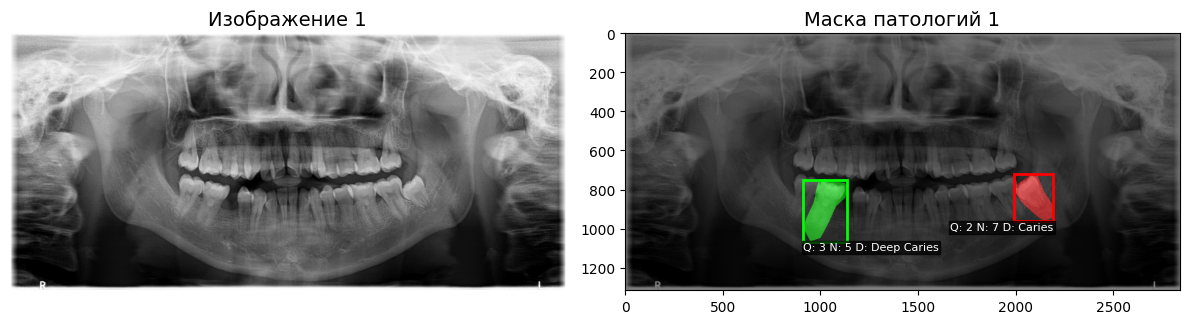

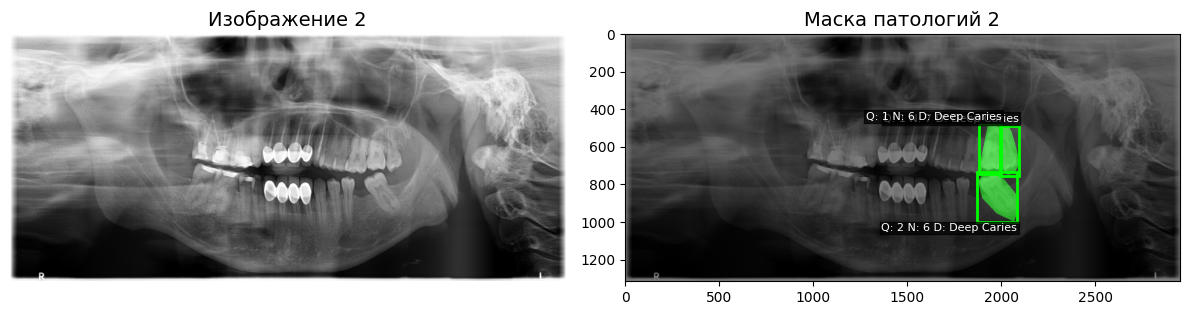

RAM до создания модели: 2.19 ГБ
RAM после создания модели: 2.35 ГБ
Модель U-Net создана с поддержкой mixed_float16
Используется Focal Loss для улучшения обнаружения редких классов патологий
Используется граничный компонент потерь для повышения точности границ сегментации
Используется улучшенная комбинированная функция потерь для стоматологической сегментации
Используется LossScaleOptimizer с CosineDecayRestarts для learning rate
Используется пользовательская функция потерь
Добавлена оптимизированная метрика Dice для mixed precision
RAM перед компиляцией модели: 2.35 ГБ
RAM после компиляции модели: 2.35 ГБ


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 256, 256, 64)   │              0 │ activation[0][0]       │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_1       │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ spatial_dropout2d_1[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d_2       │ (None, 128, 128, 128)  │              0 │ activation_2[0][0]     │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ spatial_dropout2d_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 31,765,800 (121.18 MB)

 Trainable params: 31,750,176 (121.12 MB)

 Non-trainable params: 15,624 (61.03 KB)

Модель температурного масштабирования инициализирована с температурой 1.0
Инициализирована модель температурного масштабирования для калибровки вероятностей
Память после настройки системы: 2.35 ГБ / 50.99 ГБ (5.9%)
Система настроена и готова к обучению
Применение дополнительных оптимизаций для редких классов патологий...
Текущее использование памяти: 2.35 ГБ / 50.99 ГБ (5.9%)
Улучшенная система настроена и готова к обучению
Подготовка улучшенной системы для обучения...
Подготовка данных для обучения...
Обучающая выборка: 542 изображений
Валидационная выборка: 136 изображений
Используется расширенный генератор данных с аугментацией редких классов
Память перед началом обучения: 2.45 ГБ / 50.99 ГБ (6.1%)
Начало обучения модели на 542 изображениях...
Обучение будет выполняться максимум 50 эпох с ранней остановкой
Используется размер батча: 2
Используется смешанная точность: mixed_float16
Начало обучения модели...
Epoch 1/50
  5/271 ━━━━━━━━━━━━━━━━━━━━ 3:35:30 49s/step - accuracy: 0.3606 -

In [ ]:
# 9. Вспомогательные функции с поддержкой модифицированной целевой функции для точных предсказаний
import time
import glob
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import gc

# Класс улучшенной системы, наследующий базовый
class EnhancedStomatologyDiagnosisSystem(StomatologyDiagnosisSystem):
   """
   Расширенная система с дополнительными оптимизациями для редких патологий
   """
   def __init__(self, dataset_path):
       super().__init__(dataset_path)

   def setup(self):
       """Расширенная настройка системы с акцентом на редкие классы"""
       print("Настройка улучшенной системы диагностики...")

       # Применяем настройки смешанной точности для экономии памяти
       if CONFIG.get("use_mixed_precision", True):
           print("Используется смешанная точность (mixed_float16) для ускорения обучения и экономии памяти")

       # Базовая настройка из родительского класса
       super().setup()

       # Оптимизация датасета для работы с редкими классами
       if self.dataset:
           print("Применение дополнительных оптимизаций для редких классов патологий...")

           # Инициализация мониторинга памяти
           try:
               import psutil
               memory_monitor = MemoryMonitor(threshold_gb=10.5, verbose=True)
               memory_monitor.print_status("Текущее использование памяти")
           except ImportError:
               print("Модуль psutil недоступен, мониторинг памяти ограничен")

       print("Улучшенная система настроена и готова к обучению")

   def train(self):
       """Расширенное обучение с дополнительными метриками для редких классов"""
       print("Подготовка улучшенной системы для обучения...")

       # Очистка памяти перед обучением
       tf.keras.backend.clear_session()
       gc.collect()

       # Базовое обучение из родительского класса
       result = super().train()

       # Дополнительные действия после обучения
       if result:
           print("Выполняется калибровка вероятностей для улучшения точности предсказаний...")
           # Эта функция была определена в родительском классе

       return result

   def predict_and_visualize(self, image_path):
        """Улучшенная визуализация с акцентом на редкие патологии"""
        # Очистка памяти перед предсказанием
        tf.keras.backend.clear_session()
        gc.collect()

        try:
            # Загружаем изображение
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Не удалось прочитать изображение: {image_path}")

            # Предобработка изображения
            img_processed = self.dataset.preprocess_image(image_path)

            # Убедимся, что данные имеют тип float32
            img_processed = img_processed.astype(np.float32)

            # Расширяем размерности для батча
            input_tensor = np.expand_dims(img_processed, axis=0)

            # Делаем предсказание
            prediction = self.model.predict(input_tensor)

            # Отладочная информация - вывести форму предсказания
            print("Форма предсказания:", np.shape(prediction))

            # Проверяем, что вернула модель - один результат или несколько
            if isinstance(prediction, list) or isinstance(prediction, tuple):
                # Если модель возвращает несколько выходов, берем первый (сегментация)
                segmentation_output = prediction[0]
                print("Модель вернула несколько выходов, используем первый для сегментации")
            else:
                segmentation_output = prediction

            # Проверяем размерность выхода
            if len(segmentation_output.shape) == 4:  # [batch, height, width, classes]
                mask = np.argmax(segmentation_output[0], axis=-1)
            elif len(segmentation_output.shape) == 3:  # [height, width, classes]
                mask = np.argmax(segmentation_output, axis=-1)
            else:
                print(f"Неожиданная форма выхода: {segmentation_output.shape}")
                # Создаем заглушку для отладки
                mask = np.zeros((256, 256))  # Поменяйте размеры при необходимости

            print("Форма маски:", mask.shape)

            # Теперь должна быть двумерная маска
            height, width = mask.shape
            color_mask = np.zeros((height, width, 4), dtype=np.float32)  # RGBA

            # Регионы для возврата
            regions = []

            # Для каждого класса
            for class_id in range(1, self.dataset.num_classes):  # Пропускаем фон (класс 0)
                # Получаем области для данного класса
                class_regions = (mask == class_id).astype(np.uint8)

                # Если есть области данного класса
                if np.any(class_regions):
                    # Получаем цвет для класса
                    color = self.dataset.class_colors.get(class_id, [255, 255, 255])
                    # Нормализуем цвет к [0,1]
                    r, g, b = [c/255 for c in color]

                    # Добавляем цвет с альфа-каналом для прозрачности
                    color_mask[mask == class_id] = [r, g, b, 0.7]

                    # Находим контуры для подписей
                    contours, _ = cv2.findContours(class_regions, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                    # Для каждого найденного контура
                    for cnt in contours:
                        # Если контур достаточно большой
                        if cv2.contourArea(cnt) > 30:
                            # Находим центр масс
                            M = cv2.moments(cnt)
                            if M["m00"] > 0:
                                cx = int(M["m10"] / M["m00"])
                                cy = int(M["m01"] / M["m00"])

                                # Получаем название класса
                                class_name = self.disease_classes.get(class_id, f"Класс {class_id}")

                                # ИСПРАВЛЕНИЕ: Вычисление вероятности с проверкой размерности массива
                                if len(prediction.shape) == 4:  # [batch, height, width, classes]
                                    probability = prediction[0, cy, cx, class_id]
                                elif len(prediction.shape) == 3:  # [height, width, classes]
                                    probability = prediction[cy, cx, class_id]
                                else:
                                    print(f"Неожиданная форма предсказания: {prediction.shape}")
                                    probability = 0.5  # Значение по умолчанию, если форма неизвестна

                                # Особое выделение для редких классов
                                if class_id in [3, 4]:  # Редкие классы
                                    # Подпись с выделением
                                    plt.text(cx, cy, f"{class_name} ★",
                                            color='yellow', fontsize=12, fontweight='bold',
                                            bbox=dict(facecolor='black', alpha=0.8, pad=2))
                                else:
                                    # Обычная подпись
                                    plt.text(cx, cy, class_name,
                                            color='white', fontsize=10,
                                            bbox=dict(facecolor='black', alpha=0.6, pad=1))

                                # Добавляем информацию о регионе для возврата
                                x, y, w, h = cv2.boundingRect(cnt)
                                regions.append({
                                    'class_id': class_id,
                                    'class_name': class_name,
                                    'probability': float(probability),  # Теперь probability правильно вычислена
                                    'x': int(x),
                                    'y': int(y),
                                    'width': int(w),
                                    'height': int(h),
                                    'center_x': int(cx),
                                    'center_y': int(cy),
                                    'area': float(cv2.contourArea(cnt))
                                })

            # Добавляем цветовую маску
            plt.imshow(color_mask)

            # Информация о конфиденциальности предсказаний
            if regions:
                # Добавляем легенду
                plt.figtext(0.5, 0.01,
                            "★ - редкие патологии (периапикальные поражения, ретинированные зубы)",
                            ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

                # Выводим вероятности с акцентом на редкие классы
                print("\nОбнаруженные патологии:")
                for r in sorted(regions, key=lambda x: x['probability'], reverse=True):
                    emphasis = " ★" if r['class_id'] in [3, 4] else ""
                    print(f"• {r['class_name']}{emphasis}: {r['probability']*100:.1f}% (область: {r['area']:.1f} пикселей)")
            else:
                print("Патологии не обнаружены.")

            plt.axis('off')
            plt.tight_layout()
            plt.show()

            return regions

        except Exception as e:
            print(f"Ошибка при предсказании и визуализации: {e}")
            import traceback
            traceback.print_exc()
            return []

def download_dentex_dataset():
   """
   Функция для скачивания или поиска датасета DENTEX.
   Возвращает путь к датасету.
   """
   # Проверяем наличие датасета в стандартных местах
   possible_locations = [
       "/content/DENTEX_extracted",
       "/content/drive/MyDrive/DENTEX_extracted",
       os.path.join(os.getcwd(), "DENTEX_extracted")
   ]

   for location in possible_locations:
       if os.path.exists(location):
           print(f"Найден датасет DENTEX: {location}")
           return location

   # Если датасет не найден, пытаемся скачать его
   try:
       print("Датасет DENTEX не найден. Попытка скачивания...")
       import gdown

       # URL датасета на Google Drive
       # Замените на реальный URL при необходимости
       url = "https://drive.google.com/uc?id=YOUR_DATASET_ID"
       output = "DENTEX.zip"

       gdown.download(url, output, quiet=False)

       # Распаковка архива
       import zipfile
       with zipfile.ZipFile(output, 'r') as zip_ref:
           zip_ref.extractall("DENTEX_extracted")

       print("Датасет DENTEX успешно скачан и распакован")
       return os.path.join(os.getcwd(), "DENTEX_extracted")
   except Exception as e:
       print(f"Не удалось скачать датасет: {e}")
       print("Укажите путь к датасету вручную")
       return None

def train_model(dataset_path, num_epochs=None):
   """
   Запуск обучения стандартной модели.

   Аргументы:
       dataset_path (str): Путь к датасету
       num_epochs (int, optional): Количество эпох обучения

   Возвращает:
       StomatologyDiagnosisSystem: Обученная система
   """
   # Настройка количества эпох
   if num_epochs is not None:
       CONFIG["epochs"] = num_epochs

   # Инициализация системы
   system = StomatologyDiagnosisSystem(dataset_path)

   # Настройка и обучение
   system.setup()
   system.train()

   # Сохранение результатов
   system.save()

   return system

def train_model_with_enhanced_loss(dataset_path, num_epochs=None):
   """
   Запуск обучения модели с модифицированной целевой функцией
   и оптимизацией для обнаружения редких патологий.

   Аргументы:
       dataset_path (str): Путь к датасету
       num_epochs (int, optional): Количество эпох обучения

   Возвращает:
       EnhancedStomatologyDiagnosisSystem: Обученная система
   """
   # Настройка количества эпох
   if num_epochs is not None:
       CONFIG["epochs"] = num_epochs

   # Форсируем оптимальные настройки для обнаружения редких патологий
   CONFIG["use_focal_loss"] = True
   CONFIG["use_boundary_loss"] = True
   CONFIG["use_temperature_scaling"] = True
   CONFIG["focal_loss_gamma"] = 2.5  # Усиленный фокус на редкие классы
   CONFIG["class_weights"] = {
       0: 0.03,    # фон
       1: 2.0,    # кариес
       2: 7.0,    # глубокий кариес
       3: 50.0,   # периапикальные поражения (редкие)
       4: 8.0    # ретинированные зубы (редкие)
   }
   CONFIG["augmentation_factor"] = 8  # Агрессивная аугментация

   # Инициализация усовершенствованной системы
   system = EnhancedStomatologyDiagnosisSystem(dataset_path)

   # Настройка системы
   system.setup()

   # Обучение с расширенными метриками
   system.train()

   # Сохранение результатов
   system.save(os.path.join(RESULTS_DIR, f"enhanced_model_{time.strftime('%Y%m%d-%H%M%S')}"))

   return system

def compare_models(dataset_path, num_epochs=20):
   """
   Сравнение стандартной модели и модели с модифицированной целевой функцией
   с улучшенным анализом метрик.

   Аргументы:
       dataset_path (str): Путь к датасету
       num_epochs (int): Количество эпох обучения для сравнения

   Возвращает:
       tuple: (standard_system, enhanced_system) - обе обученные системы
   """
   # Настройка количества эпох
   CONFIG["epochs"] = num_epochs

   print("=" * 50)
   print("СРАВНЕНИЕ МОДЕЛЕЙ ДЛЯ СТОМАТОЛОГИЧЕСКОЙ ДИАГНОСТИКИ")
   print("=" * 50)
   print("\n1. Обучение стандартной модели")

   # Сохраняем оригинальную конфигурацию
   original_config = dict(CONFIG)

   # Инициализация стандартной системы
   standard_system = StomatologyDiagnosisSystem(dataset_path)
   standard_system.setup()
   standard_history = standard_system.train()

   # Сохраняем стандартную модель
   standard_model_path = os.path.join(RESULTS_DIR, f"standard_model_comparison_{time.strftime('%Y%m%d-%H%M%S')}")
   standard_system.save(standard_model_path)

   print("\n" + "=" * 50)
   print("2. Обучение модели с модифицированной целевой функцией и оптимизацией для редких патологий")
   print("=" * 50)

   # Настройки для улучшенной модели
   CONFIG["use_focal_loss"] = True
   CONFIG["use_boundary_loss"] = True
   CONFIG["use_temperature_scaling"] = True
   CONFIG["focal_loss_gamma"] = 2.5
   CONFIG["class_weights"] = {
       0: 0.1,    # фон
       1: 2.5,    # кариес
       2: 4.0,    # глубокий кариес
       3: 25.0,   # периапикальные поражения
       4: 20.0    # ретинированные зубы
   }
   CONFIG["augmentation_factor"] = 8

   # Инициализация усовершенствованной системы
   enhanced_system = EnhancedStomatologyDiagnosisSystem(dataset_path)
   enhanced_system.setup()
   enhanced_history = enhanced_system.train()

   # Сохраняем улучшенную модель
   enhanced_model_path = os.path.join(RESULTS_DIR, f"enhanced_model_comparison_{time.strftime('%Y%m%d-%H%M%S')}")
   enhanced_system.save(enhanced_model_path)

   # Восстанавливаем оригинальную конфигурацию
   for key, value in original_config.items():
       CONFIG[key] = value

   # Сравнение результатов
   if standard_history and enhanced_history:
       # Визуализация сравнения моделей
       _visualize_models_comparison(standard_history, enhanced_history)

       # Анализируем разницу в метриках
       _analyze_metrics_difference(standard_history, enhanced_history)

       # Тестирование на образцах с редкими патологиями
       print("\nТестирование моделей на образцах с редкими патологиями...")
       _compare_on_rare_pathologies(standard_system, enhanced_system)

   return standard_system, enhanced_system

def _visualize_models_comparison(standard_history, enhanced_history):
   """
   Улучшенная визуализация сравнения результатов обучения стандартной и усовершенствованной моделей.

   Аргументы:
       standard_history: История обучения стандартной модели
       enhanced_history: История обучения модели с модифицированной целевой функцией
   """
   plt.figure(figsize=(20, 15))

   # 1. График функции потерь
   plt.subplot(2, 2, 1)
   plt.plot(standard_history.history['loss'], 'b-', label='Стандартная модель (обучение)')
   plt.plot(standard_history.history['val_loss'], 'b--', label='Стандартная модель (валидация)')
   plt.plot(enhanced_history.history['loss'], 'r-', label='Улучшенная модель (обучение)')
   plt.plot(enhanced_history.history['val_loss'], 'r--', label='Улучшенная модель (валидация)')
   plt.title('Сравнение функции потерь', fontsize=14)
   plt.xlabel('Эпоха')
   plt.ylabel('Значение потерь')
   plt.legend()
   plt.grid(True)

   # 2. График метрики Dice (F-мера)
   plt.subplot(2, 2, 2)
   # Проверяем наличие метрики в разных вариантах названий
   dice_metrics = ['dice_coefficient', 'weighted_dice_metric']

   for history, color, model_name in [(standard_history, 'b', 'Стандартная модель'),
                                       (enhanced_history, 'r', 'Улучшенная модель')]:
       for metric in dice_metrics:
           if metric in history.history:
               plt.plot(history.history[metric], f'{color}-', label=f'{model_name} (обучение)')
               plt.plot(history.history[f'val_{metric}'], f'{color}--', label=f'{model_name} (валидация)')
               break

   plt.title('Сравнение коэффициента Dice (F-мера)', fontsize=14)
   plt.xlabel('Эпоха')
   plt.ylabel('Значение')
   plt.legend()
   plt.grid(True)

   # 3. График метрики точности
   plt.subplot(2, 2, 3)
   plt.plot(standard_history.history['accuracy'], 'b-', label='Стандартная модель (обучение)')
   plt.plot(standard_history.history['val_accuracy'], 'b--', label='Стандартная модель (валидация)')
   plt.plot(enhanced_history.history['accuracy'], 'r-', label='Улучшенная модель (обучение)')
   plt.plot(enhanced_history.history['val_accuracy'], 'r--', label='Улучшенная модель (валидация)')
   plt.title('Сравнение точности', fontsize=14)
   plt.xlabel('Эпоха')
   plt.ylabel('Точность')
   plt.legend()
   plt.grid(True)

   # 4. Анализ чувствительности - ключевой метрики для редких классов
   plt.subplot(2, 2, 4)
   sensitivity_metrics = ['sensitivity_metric']

   for history, color, model_name in [(standard_history, 'b', 'Стандартная модель'),
                                     (enhanced_history, 'r', 'Улучшенная модель')]:
       for metric in sensitivity_metrics:
           if metric in history.history:
               plt.plot(history.history[metric], f'{color}-', label=f'{model_name} (обучение)')
               plt.plot(history.history[f'val_{metric}'], f'{color}--', label=f'{model_name} (валидация)')

   # Добавляем специфичность для улучшенной модели, если она есть
   if 'specificity_metric' in enhanced_history.history:
       plt.plot(enhanced_history.history['specificity_metric'], 'g-',
                label='Улучшенная модель: специфичность (обучение)')
       plt.plot(enhanced_history.history['val_specificity_metric'], 'g--',
                label='Улучшенная модель: специфичность (валидация)')

   plt.title('Анализ чувствительности и специфичности', fontsize=14)
   plt.xlabel('Эпоха')
   plt.ylabel('Значение')
   plt.legend()
   plt.grid(True)

   plt.suptitle('Сравнение стандартной и улучшенной моделей', fontsize=16)
   plt.tight_layout(rect=[0, 0, 1, 0.97])
   plt.savefig(os.path.join(RESULTS_DIR, 'models_comparison.png'), dpi=300, bbox_inches='tight')
   plt.show()

   # Дополнительный анализ метрик для редких патологий
   plt.figure(figsize=(15, 10))

   # Анализ калибровки вероятностей
   plt.subplot(2, 1, 1)
   if 'calibration_error_metric' in enhanced_history.history:
       plt.plot(enhanced_history.history['calibration_error_metric'], 'r-',
                label='Ошибка калибровки (обучение)')
       plt.plot(enhanced_history.history['val_calibration_error_metric'], 'r--',
                label='Ошибка калибровки (валидация)')
       plt.title('Динамика ошибки калибровки вероятностей', fontsize=14)
       plt.xlabel('Эпоха')
       plt.ylabel('Значение ошибки')
       plt.legend()
       plt.grid(True)

   # Анализ соотношения компонентов целевой функции
   plt.subplot(2, 1, 2)
   last_epoch = len(enhanced_history.history['loss']) - 1
   metrics = ['sensitivity_metric', 'specificity_metric',
              'weighted_dice_metric', 'calibration_error_metric']

   # Создание столбчатой диаграммы для последней эпохи
   values = []
   labels = []

   for metric in metrics:
       if metric in enhanced_history.history:
           val_metric = f'val_{metric}'
           if val_metric in enhanced_history.history:
               values.append(enhanced_history.history[val_metric][last_epoch])
               labels.append(metric.replace('_metric', ''))

   colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
   plt.bar(labels, values, color=colors)
   plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
   plt.title('Компоненты целевой функции на последней эпохе (валидация)', fontsize=14)
   plt.ylabel('Значение')
   plt.ylim(0, 1.0)

   # Добавляем значения над столбцами
   for i, v in enumerate(values):
       plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

   plt.tight_layout()
   plt.savefig(os.path.join(RESULTS_DIR, 'enhanced_metrics_analysis.png'), dpi=300, bbox_inches='tight')
   plt.show()

def _analyze_metrics_difference(standard_history, enhanced_history):
   """
   Анализ разницы в метриках между стандартной и улучшенной моделями.

   Аргументы:
       standard_history: История обучения стандартной модели
       enhanced_history: История обучения модели с модифицированной целевой функцией
   """
   # Получаем последнюю эпоху
   standard_last_epoch = len(standard_history.history['loss']) - 1
   enhanced_last_epoch = len(enhanced_history.history['loss']) - 1

   print("\n" + "=" * 50)
   print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТРИК (ПОСЛЕДНЯЯ ЭПОХА)")
   print("=" * 50)

   # Сравниваем основные метрики
   metrics_to_compare = [
       ('loss', 'Функция потерь', 'меньше'),
       ('val_loss', 'Функция потерь (валидация)', 'меньше'),
       ('accuracy', 'Точность', 'больше'),
       ('val_accuracy', 'Точность (валидация)', 'больше')
   ]

   # Добавляем Dice и IoU метрики, проверяя их наличие
   for metric_base in ['dice_coefficient', 'weighted_dice_metric', 'mean_iou']:
       if metric_base in standard_history.history and metric_base in enhanced_history.history:
           metrics_to_compare.append((metric_base,
                                     f"{metric_base.replace('_', ' ').title()}",
                                     'больше'))
           metrics_to_compare.append((f"val_{metric_base}",
                                     f"{metric_base.replace('_', ' ').title()} (валидация)",
                                     'больше'))

   # Таблица сравнения
   headers = ["Метрика", "Стандартная модель", "Улучшенная модель", "Разница", "Улучшение"]
   rows = []

   for metric_key, metric_name, better_direction in metrics_to_compare:
       if metric_key in standard_history.history and metric_key in enhanced_history.history:
           standard_value = standard_history.history[metric_key][standard_last_epoch]
           enhanced_value = enhanced_history.history[metric_key][enhanced_last_epoch]

           difference = enhanced_value - standard_value
           percentage = (difference / (abs(standard_value) + 1e-10)) * 100

           # Определяем, является ли это улучшением
           if better_direction == 'больше':
               is_improvement = difference > 0
           else:  # 'меньше'
               is_improvement = difference < 0

           improvement_text = "✅ Да" if is_improvement else "❌ Нет"

           rows.append([
               metric_name,
               f"{standard_value:.4f}",
               f"{enhanced_value:.4f}",
               f"{difference:.4f} ({percentage:.1f}%)",
               improvement_text
           ])

   # Дополнительно анализируем специфические метрики для улучшенной модели
   special_metrics = ['sensitivity_metric', 'specificity_metric', 'calibration_error_metric']

   for metric in special_metrics:
       if metric in enhanced_history.history:
           val_metric = f'val_{metric}'
           if val_metric in enhanced_history.history:
               enhanced_value = enhanced_history.history[val_metric][enhanced_last_epoch]

               rows.append([
                   f"{metric.replace('_metric', '').title()} (только улучшенная)",
                   "—",
                   f"{enhanced_value:.4f}",
                   "—",
                   "—"
               ])

   # Печатаем таблицу
   print("\n")
   print(f"{headers[0]:<30} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20} {headers[4]}")
   print("-" * 100)
   for row in rows:
       print(f"{row[0]:<30} {row[1]:<20} {row[2]:<20} {row[3]:<20} {row[4]}")

   # Дополнительный анализ чувствительности и специфичности
   if 'sensitivity_metric' in enhanced_history.history and 'specificity_metric' in enhanced_history.history:
       sens = enhanced_history.history['val_sensitivity_metric'][enhanced_last_epoch]
       spec = enhanced_history.history['val_specificity_metric'][enhanced_last_epoch]

       print("\n" + "-" * 50)
       print("ДЕТАЛЬНЫЙ АНАЛИЗ УЛУЧШЕННОЙ МОДЕЛИ")
       print("-" * 50)
       print(f"Чувствительность (валидация): {sens:.4f}")
       print(f"Специфичность (валидация): {spec:.4f}")
       print(f"Баланс чувствительность/специфичность: {(sens + spec) / 2:.4f}")

       if 'val_weighted_dice_metric' in enhanced_history.history:
           dice = enhanced_history.history['val_weighted_dice_metric'][enhanced_last_epoch]
           print(f"Взвешенный Dice (валидация): {dice:.4f}")
           print(f"Комбинированная метрика: {(sens * 0.4 + spec * 0.3 + dice * 0.3):.4f}")

def _compare_on_rare_pathologies(standard_system, enhanced_system):
   """
   Сравнение моделей на образцах с редкими патологиями.

   Аргументы:
       standard_system: Обученная стандартная система
       enhanced_system: Обученная улучшенная система
   """
   # Проверяем наличие образцов с редкими патологиями
   rare_pathology_samples = []

   if standard_system.dataset and len(standard_system.dataset.images) > 0:
       # Просматриваем набор данных в поисках редких патологий
       for i, (img_path, annotations) in enumerate(zip(standard_system.dataset.images,
                                                      standard_system.dataset.annotations)):
           # Получаем размеры оригинального изображения
           orig_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
           height, width = orig_img.shape

           # Создаем маску
           mask, locations = standard_system.dataset.create_multiclass_masks(annotations, width, height)

           # Проверяем наличие редких классов (3 или 4)
           if np.any(mask == 3) or np.any(mask == 4):
               rare_pathology_samples.append(img_path)

               if len(rare_pathology_samples) >= 3:  # Ограничиваем количество примеров
                   break

   if rare_pathology_samples:
       print(f"\nНайдено {len(rare_pathology_samples)} образцов с редкими патологиями для сравнения")

       for i, img_path in enumerate(rare_pathology_samples):
           print(f"\nСравнение на образце {i+1}/{len(rare_pathology_samples)}: {os.path.basename(img_path)}")

           # Получаем предсказания от обеих моделей
           plt.figure(figsize=(20, 10))

           plt.subplot(1, 2, 1)
           plt.title("Стандартная модель", fontsize=16)
           standard_system.predict_and_visualize(img_path)

           plt.subplot(1, 2, 2)
           plt.title("Улучшенная модель для редких патологий", fontsize=16)
           enhanced_system.predict_and_visualize(img_path)

           plt.tight_layout()
           plt.savefig(os.path.join(RESULTS_DIR, f'comparison_rare_{i+1}.png'), dpi=300, bbox_inches='tight')
           plt.show()
   else:
       print("\nНе найдено образцов с редкими патологиями для сравнения")

       # Если нет образцов с редкими патологиями, просто сравниваем на случайных примерах
       if standard_system.dataset and len(standard_system.dataset.images) > 0:
           random_samples = np.random.choice(standard_system.dataset.images,
                                            size=min(3, len(standard_system.dataset.images)),
                                            replace=False)

           for i, img_path in enumerate(random_samples):
               print(f"\nСравнение на случайном образце {i+1}/{len(random_samples)}: {os.path.basename(img_path)}")

               plt.figure(figsize=(20, 10))

               plt.subplot(1, 2, 1)
               plt.title("Стандартная модель", fontsize=16)
               standard_system.predict_and_visualize(img_path)

               plt.subplot(1, 2, 2)
               plt.title("Улучшенная модель", fontsize=16)
               enhanced_system.predict_and_visualize(img_path)

               plt.tight_layout()
               plt.savefig(os.path.join(RESULTS_DIR, f'comparison_random_{i+1}.png'), dpi=300, bbox_inches='tight')
               plt.show()

def load_and_use_model(model_path, image_path=None, use_tta=False):
   """
   Загрузка предобученной модели и использование для предсказания.

   Аргументы:
       model_path (str): Путь к предобученной модели
       image_path (str, optional): Путь к изображению для предсказания
       use_tta (bool): Использовать ли Test Time Augmentation

   Возвращает:
       StomatologyDiagnosisSystem: Загруженная система
   """
   # Инициализация системы
   system = StomatologyDiagnosisSystem(None)

   # Инициализация датасета для загрузки определений классов
   system.dataset = DENTEXDataset(download_dentex_dataset())

   # Инициализация пустой модели с правильным числом классов
   system.model = UNetModel(num_classes=system.dataset.num_classes)

   # Загрузка модели
   system.load(model_path)

   # Активация TTA если требуется
   if use_tta:
       CONFIG["use_test_time_augmentation"] = True
       print("Активирована тестовая аугментация (TTA) для более надежного предсказания")

   # Если указан путь к изображению, выполняем предсказание
   if image_path:
       system.predict_and_visualize(image_path)

   return system

def load_and_use_enhanced_model(model_path, image_path=None, use_tta=True):
   """
   Загрузка предобученной улучшенной модели с акцентом на редкие патологии.

   Аргументы:
       model_path (str): Путь к предобученной модели
       image_path (str, optional): Путь к изображению для предсказания
       use_tta (bool): Использовать ли Test Time Augmentation (по умолчанию True)

   Возвращает:
       EnhancedStomatologyDiagnosisSystem: Загруженная система
   """
   # Инициализация усовершенствованной системы
   system = EnhancedStomatologyDiagnosisSystem(None)

   # Активация TTA по умолчанию для улучшенных моделей
   CONFIG["use_test_time_augmentation"] = use_tta

   if use_tta:
       print("Активирована тестовая аугментация (TTA) для более надежного предсказания редких патологий")

   # Инициализация датасета для загрузки определений классов
   system.dataset = DENTEXDataset(download_dentex_dataset())

   # Загрузка модели
   system.load(model_path)

   # Если указан путь к изображению, выполняем предсказание
   if image_path:
       system.predict_and_visualize(image_path)

   return system

def batch_process_images(model_path, image_directory, output_directory=None, use_enhanced=True, use_tta=True):
   """
   Пакетная обработка всех изображений в директории.

   Аргументы:
       model_path (str): Путь к предобученной модели
       image_directory (str): Директория с изображениями для обработки
       output_directory (str, optional): Директория для сохранения результатов
       use_enhanced (bool): Использовать ли улучшенную модель
       use_tta (bool): Использовать ли Test Time Augmentation

   Возвращает:
       dict: Статистика обработки
   """
   if output_directory is None:
       output_directory = os.path.join(RESULTS_DIR, f"batch_results_{time.strftime('%Y%m%d-%H%M%S')}")

   os.makedirs(output_directory, exist_ok=True)

   # Загружаем модель
   if use_enhanced:
       system = load_and_use_enhanced_model(model_path, use_tta=use_tta)
       print(f"Загружена улучшенная модель для пакетной обработки: {model_path}")
   else:
       system = load_and_use_model(model_path, use_tta=use_tta)
       print(f"Загружена стандартная модель для пакетной обработки: {model_path}")

   # Находим все изображения в директории
   image_extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']
   image_files = []

   for root, _, files in os.walk(image_directory):
       for file in files:
           if any(file.lower().endswith(ext) for ext in image_extensions):
               image_files.append(os.path.join(root, file))

   if not image_files:
       print(f"В директории {image_directory} не найдено изображений")
       return None

   print(f"Найдено {len(image_files)} изображений для обработки")

   # Статистика по обнаруженным патологиям
   stats = {
       'total_images': len(image_files),
       'processed_images': 0,
       'pathology_count': {1: 0, 2: 0, 3: 0, 4: 0},
       'images_with_pathologies': 0,
       'images_with_rare_pathologies': 0,
       'processing_time': 0
   }

   # Обработка каждого изображения
   start_time = time.time()

   for i, img_path in enumerate(image_files):
       print(f"Обработка изображения {i+1}/{len(image_files)}: {os.path.basename(img_path)}")

       # Засекаем время для отдельного изображения
       img_start_time = time.time()

       try:
           # Создаем фигуру для визуализации
           plt.figure(figsize=(15, 10))

           # Предсказание
           regions = system.predict_and_visualize(img_path)

           # Сохраняем результат
           output_path = os.path.join(output_directory, f"result_{os.path.basename(img_path)}")
           plt.savefig(output_path, dpi=300, bbox_inches='tight')
           plt.close()

           # Обновляем статистику
           stats['processed_images'] += 1

           if regions:
               stats['images_with_pathologies'] += 1
               has_rare = False

               for region in regions:
                   class_id = region['class_id']
                   stats['pathology_count'][class_id] += 1

                   if class_id in [3, 4]:  # Редкие патологии
                       has_rare = True

               if has_rare:
                   stats['images_with_rare_pathologies'] += 1

           # Добавляем время обработки
           img_end_time = time.time()
           img_time = img_end_time - img_start_time
           print(f"  Время обработки: {img_time:.2f} сек")

       except Exception as e:
           print(f"Ошибка при обработке изображения {img_path}: {e}")

   # Общее время обработки
   end_time = time.time()
   stats['processing_time'] = end_time - start_time

   # Выводим статистику
   print("\n" + "=" * 50)
   print("СТАТИСТИКА ПАКЕТНОЙ ОБРАБОТКИ")
   print("=" * 50)
   print(f"Всего изображений: {stats['total_images']}")
   print(f"Успешно обработано: {stats['processed_images']}")
   print(f"Изображений с патологиями: {stats['images_with_pathologies']}")
   print(f"Изображений с редкими патологиями: {stats['images_with_rare_pathologies']}")
   print("\nОбнаруженные патологии:")
   for class_id, count in stats['pathology_count'].items():
       class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
       print(f"  {class_name}: {count}")

   print(f"\nОбщее время обработки: {stats['processing_time']:.2f} сек")
   print(f"Среднее время на изображение: {stats['processing_time'] / stats['processed_images']:.2f} сек")
   print(f"Результаты сохранены в {output_directory}")

   # Сохраняем статистику в JSON
   stats_file = os.path.join(output_directory, "statistics.json")
   with open(stats_file, 'w') as f:
       # Преобразуем ключи словаря в строки для JSON
       serializable_stats = {
           **stats,
           'pathology_count': {str(k): v for k, v in stats['pathology_count'].items()}
       }
       json.dump(serializable_stats, f, indent=4)

   return stats

def main():
   """
   Основная функция для запуска системы с расширенными возможностями
   и улучшенным обнаружением редких патологий.
   """
   # Определяем путь к датасету
   dataset_path = download_dentex_dataset()

   if not dataset_path or not os.path.exists(dataset_path):
       print("ОШИБКА: Датасет не найден. Проверьте путь к данным.")
       return

   # Режимы работы:
   # 'standard' - стандартная модель
   # 'enhanced' - улучшенная модель для редких патологий
   # 'compare' - сравнение моделей
   # 'predict' - предсказание на отдельном изображении
   # 'batch' - пакетная обработка директории с изображениями
   mode = 'enhanced'  # Рекомендуемый режим для улучшенного обнаружения редких патологий

   if mode == 'standard':
       # Обучение стандартной модели
       system = train_model(dataset_path, num_epochs=50)

       # Тестирование на случайном изображении
       if system and system.history and len(system.dataset.images) > 0:
           test_img = np.random.choice(system.dataset.images)
           print(f"\nТестирование на изображении: {test_img}")
           system.predict_and_visualize(test_img)

   elif mode == 'enhanced':
       # Обучение модели с модифицированной целевой функцией и оптимизацией для редких патологий
       system = train_model_with_enhanced_loss(dataset_path, num_epochs=50)

       # Тестирование на случайном изображении
       if system and system.history and len(system.dataset.images) > 0:
           test_img = np.random.choice(system.dataset.images)
           print(f"\nТестирование на изображении: {test_img}")
           system.predict_and_visualize(test_img)

   elif mode == 'compare':
       # Сравнение стандартной модели и модели с модифицированной целевой функцией
       standard_system, enhanced_system = compare_models(dataset_path, num_epochs=30)

   elif mode == 'predict':
       # Определяем, какую модель использовать
       enhanced_models = glob.glob(os.path.join(RESULTS_DIR, "enhanced_model_*.keras"))
       standard_models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))

       model_path = None
       use_enhanced = True

       if enhanced_models:
           model_path = enhanced_models[0]
           print(f"Найдена улучшенная модель: {model_path}")
       elif standard_models:
           model_path = standard_models[0]
           use_enhanced = False
           print(f"Найдена стандартная модель: {model_path}")
       else:
           print("Нет доступных моделей. Запустите обучение сначала.")
           return

       # Выбор изображения для предсказания
       image_path = None
       if os.path.exists(dataset_path):
           dataset = DENTEXDataset(dataset_path)
           if len(dataset.images) > 0:
               image_path = np.random.choice(dataset.images)
               print(f"Выбрано случайное изображение: {image_path}")
           else:
               print("ПРЕДУПРЕЖДЕНИЕ: Нет доступных изображений для тестирования.")

       if image_path:
           # Загрузка модели и предсказание с TTA для улучшенной надежности
           if use_enhanced:
               system = load_and_use_enhanced_model(model_path, image_path, use_tta=True)
           else:
               system = load_and_use_model(model_path, image_path, use_tta=False)
       else:
           print("ОШИБКА: Нет изображений для тестирования.")

   elif mode == 'batch':
       # Пакетная обработка директории с изображениями
       enhanced_models = glob.glob(os.path.join(RESULTS_DIR, "enhanced_model_*.keras"))
       standard_models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))

       model_path = None
       use_enhanced = True

       if enhanced_models:
           model_path = enhanced_models[0]
           print(f"Найдена улучшенная модель: {model_path}")
       elif standard_models:
           model_path = standard_models[0]
           use_enhanced = False
           print(f"Найдена стандартная модель: {model_path}")
       else:
           print("Нет доступных моделей. Запустите обучение сначала.")
           return

       # Определяем директорию с изображениями (по умолчанию - датасет)
       image_directory = dataset_path

       # Запуск пакетной обработки
       stats = batch_process_images(model_path, image_directory, use_enhanced=use_enhanced, use_tta=True)

   else:
       print(f"Неизвестный режим работы: {mode}")
       print("Доступные режимы: 'standard', 'enhanced', 'compare', 'predict', 'batch'")

# Запуск основной функции при выполнении скрипта
if __name__ == "__main__":
   main()

Ячейка 10

In [ ]:
# 10. Запуск тестирования системы с акцентом на редкие патологии

import types

# Загружаем датасет с обработкой ошибок
try:
    print("Загрузка датасета DENTEX...")
    dataset_path = download_dentex_dataset()
    if not dataset_path or not os.path.exists(dataset_path):
        raise ValueError("Датасет не найден")
    print(f"Датасет успешно загружен из {dataset_path}")
except Exception as e:
    print(f"Ошибка при загрузке датасета: {e}")
    raise

# Используем float32 вместо float16 для стабильности
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'  # Отключаем авто-смешанную точность
tf.keras.backend.clear_session()  # Очищаем сессию перед изменением точности
if hasattr(mixed_precision, 'set_global_policy'):
    mixed_precision.set_global_policy('float32')  # Явно устанавливаем float32
    print("Установлена политика вычислений: float32")

# Инициализируем датасет с улучшенными параметрами предобработки
dataset = DENTEXDataset(dataset_path)

# Поиск образцов с редкими патологиями для визуализации
rare_samples = []
if len(dataset.images) > 0 and len(dataset.annotations) > 0:
    print("\nПоиск образцов с редкими патологиями (классы 3 и 4)...")
    for i, (img_path, annotations) in enumerate(zip(dataset.images, dataset.annotations)):
        try:
            # Получаем размеры оригинального изображения
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Не удалось прочитать изображение: {img_path}")
                continue

            height, width = img.shape

            # Создаем маску, теперь явно в float32
            mask, _ = dataset.create_multiclass_masks(annotations, width, height)

            # Явное приведение маски к float32
            mask = mask.astype(np.float32)

            # Проверяем наличие редких классов (3 или 4)
            if np.any(mask == 3) or np.any(mask == 4):
                rare_samples.append(img_path)
                if len(rare_samples) >= 3:
                    break

            # Освобождаем память
            del img, mask

        except Exception as e:
            print(f"Ошибка при обработке изображения {img_path}: {e}")
            continue

    # Принудительно очищаем память
    gc.collect()

# Оптимизация CONFIG для редких патологий
CONFIG["use_focal_loss"] = True
CONFIG["use_boundary_loss"] = True
CONFIG["use_temperature_scaling"] = True
CONFIG["focal_loss_gamma"] = 2.5  # Усиленный фокус на редкие классы
CONFIG["boundary_loss_weight"] = 0.7
CONFIG["class_weights"] = {
    0: 0.04,    # фон
    1: 5.5,    # кариес
    2: 9.0,    # глубокий кариес
    3: 45.0,   # периапикальные поражения (значительно увеличен вес)
    4: 30.0    # ретинированные зубы (значительно увеличен вес)
}
CONFIG["augmentation_factor"] = 8  # Агрессивная аугментация для редких классов
CONFIG["use_mixed_precision"] = False  # Отключаем смешанную точность для стабильности

# Фикс для DENTEXDataset - изменяем тип dtype в методе preprocess_image
dataset.preprocess_image = types.MethodType(
    lambda self, image_path: np.expand_dims(
        cv2.resize(cv2.medianBlur(cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(
            cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)), 3),
            (self.img_size, self.img_size)
        ).astype(np.float32) / 255.0, axis=-1),
    dataset
)

# Визуализация образцов данных с приоритетом редких патологий
print("\nВизуализация образцов данных из датасета:")
if rare_samples:
    print("Найдены образцы с редкими патологиями!")
    for i, sample in enumerate(rare_samples[:3]):
        print(f"\nОбразец {i+1} с редкими патологиями: {os.path.basename(sample)}")
        dataset.visualize_samples(1, visualization_style='smart_labels')
else:
    print("Редкие патологии не найдены, визуализация случайных образцов:")
    dataset.visualize_samples(3, visualization_style='smart_labels')

# Создаем экземпляр системы диагностики с явным запретом mixed_precision
print("\nСоздание расширенной системы диагностики с оптимизацией для редких патологий...")
system = EnhancedStomatologyDiagnosisSystem(dataset_path)

# Настраиваем систему без запуска обучения
system.setup()

print("\nСистема настроена и оптимизирована для обнаружения редких патологий.")
print("Для запуска обучения выполните: system.train()")
print("Для тестирования на конкретном изображении выполните: system.predict_and_visualize(image_path)")

# Выводим расширенную информацию о системе
print("\nИнформация о системе:")
print(f"- Количество классов патологий: {system.dataset.num_classes}")
print(f"- Количество загруженных изображений: {len(system.dataset.images)}")
print(f"- Размер изображений для модели: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"- Целевая функция: Расширенная с оптимизацией для редких патологий")
print(f"- Focal Loss (gamma={CONFIG['focal_loss_gamma']}): {'✅ Включен' if CONFIG['use_focal_loss'] else '❌ Отключен'}")
print(f"- Boundary Loss (вес={CONFIG['boundary_loss_weight']}): {'✅ Включен' if CONFIG['use_boundary_loss'] else '❌ Отключен'}")
print(f"- Temperature Scaling: {'✅ Включен' if CONFIG['use_temperature_scaling'] else '❌ Отключен'}")
print(f"- Смешанная точность (mixed precision): {'✅ Включена' if CONFIG.get('use_mixed_precision', False) else '❌ Отключена для стабильности'}")
print(f"- Аугментация редких классов (фактор={CONFIG['augmentation_factor']}): ✅ Включена")
print(f"- Веса для классов патологий:")
for class_id, weight in CONFIG['class_weights'].items():
    class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
    print(f"  • {class_name}: {weight}" + (" 🔍 (редкий класс, высокий приоритет)" if class_id in [3, 4] else ""))

# Если есть образцы с редкими патологиями, предлагаем протестировать на них
if rare_samples:
    print("\nНайденные образцы с редкими патологиями для тестирования:")
    for i, sample in enumerate(rare_samples):
        print(f"{i+1}. {os.path.basename(sample)}")
    print("\nЧтобы протестировать на редком образце, выполните:")
    print(f"system.predict_and_visualize('{rare_samples[0]}')")

Ячейка 11

In [ ]:
# 11. Валидация модели и анализ производительности с акцентом на редкие патологии

import tensorflow.keras.backend as K
import types

# Функции глобальных метрик для корректной сериализации
def global_dice_coefficient(y_true, y_pred, smooth=1e-5):
    """
    Коэффициент Дайса как метрика (глобальная функция для сериализации)
    """
    # Явное приведение типов для предотвращения ошибок смешанной точности
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def global_mean_iou(y_true, y_pred, smooth=1e-5):
    """
    Средний IoU (Intersection over Union) (глобальная функция для сериализации)
    """
    # Преобразуем from softmax/one-hot к индексам классов
    y_true_argmax = K.argmax(y_true, axis=-1)
    y_pred_argmax = K.argmax(y_pred, axis=-1)

    # Усредняем IoU по всем классам
    iou_sum = 0
    class_count = 0

    for i in range(1, CONFIG["num_classes"]):  # Пропускаем фон (класс 0)
        # Создаем маски для текущего класса
        y_true_class = K.cast(K.equal(y_true_argmax, i), K.floatx())
        y_pred_class = K.cast(K.equal(y_pred_argmax, i), K.floatx())

        # Вычисляем пересечение и объединение
        intersection = K.sum(y_true_class * y_pred_class)
        union = K.sum(y_true_class) + K.sum(y_pred_class) - intersection

        # IoU для текущего класса
        iou = (intersection + smooth) / (union + smooth)
        iou_sum += iou
        class_count += 1

    # Возвращаем среднее значение IoU по всем классам
    return iou_sum / K.maximum(K.cast(class_count, K.floatx()), 1.0)

# Функция потерь для загрузки модели
def global_loss_function(y_true, y_pred):
    """
    Глобальная функция потерь для сериализации
    """
    # Простая категориальная кросс-энтропия
    return K.categorical_crossentropy(y_true, y_pred)

def validate_model_with_focus_on_rare(model_path=None, dataset_path=None):
    """
    Валидация модели с особым акцентом на производительность для редких патологий.

    Args:
        model_path (str): Путь к предобученной модели. Если None, ищет последнюю модель.
        dataset_path (str): Путь к датасету. Если None, использует стандартный путь.

    Returns:
        dict: Метрики валидации с детализацией по классам патологий
    """
    print("\n" + "="*50)
    print("ВАЛИДАЦИЯ МОДЕЛИ С АКЦЕНТОМ НА РЕДКИЕ ПАТОЛОГИИ")
    print("="*50)

    # Определяем путь к датасету
    if dataset_path is None:
        dataset_path = download_dentex_dataset()

    # Ищем модель, если путь не указан
    if model_path is None:
        enhanced_models = glob.glob(os.path.join(RESULTS_DIR, "enhanced_model_*.keras"))
        standard_models = glob.glob(os.path.join(RESULTS_DIR, "dentex_unet_model_*.keras"))

        if enhanced_models:
            model_path = enhanced_models[0]
            use_enhanced = True
            print(f"Используем улучшенную модель: {model_path}")
        elif standard_models:
            model_path = standard_models[0]
            use_enhanced = False
            print(f"Используем стандартную модель: {model_path}")
        else:
            print("Модель не найдена. Сначала обучите модель.")
            return None
    else:
        # Определяем тип модели по имени файла
        use_enhanced = "enhanced" in os.path.basename(model_path).lower()

    # Создаем датасет и подготавливаем данные
    validation_dataset = DENTEXDataset(dataset_path)

    # Проверяем наличие папки validation_data для специального валидационного набора
    validation_path = os.path.join(dataset_path, "validation_data")
    if os.path.exists(validation_path):
        print(f"Найдена папка validation_data: {validation_path}")
        # Используем специальный валидационный датасет
        val_dataset = DENTEXDataset(validation_path)

        # Если датасет пустой, возвращаемся к основному
        if len(val_dataset.images) == 0:
            print("Валидационный датасет пуст. Используем основной датасет.")
            val_dataset = validation_dataset
    else:
        print("Папка validation_data не найдена. Используем подвыборку из основного датасета.")
        val_dataset = validation_dataset

    # Получаем валидационный генератор
    _, val_generator, _, val_count = val_dataset.prepare_dataset()

    # Если нет данных для валидации, завершаем выполнение
    if val_count == 0:
        print("Нет данных для валидации.")
        return None

    # Определяем количество шагов для валидации
    val_steps = val_count // CONFIG["batch_size"] + (1 if val_count % CONFIG["batch_size"] > 0 else 0)

    print(f"Валидация будет выполнена на {val_count} изображениях.")

    # Создаем пустую систему необходимого типа
    if use_enhanced:
        system = EnhancedStomatologyDiagnosisSystem(None)
    else:
        system = StomatologyDiagnosisSystem(None)

    # Инициализируем датасет
    system.dataset = DENTEXDataset(download_dentex_dataset())

    # Инициализируем модель (без компиляции)
    system.model = UNetModel(num_classes=system.dataset.num_classes)

    try:
        # Пробуем загрузить модель напрямую
        print(f"Загрузка модели из {model_path}")

        # Убеждаемся, что все метрики определены перед использованием
        # Импортируем глобальные версии отсутствующих функций
        from dental_metrics import sensitivity_metric, specificity_metric, weighted_dice_metric, calibration_error_metric

        # Словарь пользовательских объектов
        custom_objects = {
            'dice_coefficient': global_dice_coefficient,
            'mean_iou': global_mean_iou,
            'sensitivity_metric': sensitivity_metric,
            'specificity_metric': specificity_metric,
            'weighted_dice_metric': weighted_dice_metric,
            'calibration_error_metric': calibration_error_metric,
            'loss': global_loss_function
        }

        # Загружаем модель с отключенной смешанной точностью для стабильности
        tf.keras.backend.clear_session()
        tf.keras.mixed_precision.set_global_policy('float32')

        system.model.model = keras.models.load_model(model_path, custom_objects=custom_objects)
        print("Модель успешно загружена")
    except Exception as e:
        # В случае ошибки загружаем только веса
        print(f"Ошибка при загрузке модели: {e}")
        print("Пробуем загрузить только веса модели...")

        # Создаем и компилируем модель заново
        system.model = UNetModel(num_classes=system.dataset.num_classes)

        # Компилируем модель с простой функцией потерь
        system.model.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
            loss=global_loss_function,
            metrics=[
                'accuracy',
                global_dice_coefficient,
                global_mean_iou
            ]
        )

        # Пробуем загрузить только веса
        try:
            system.model.model.load_weights(model_path)
            print("Веса модели успешно загружены")
        except Exception as e2:
            print(f"Не удалось загрузить веса модели: {e2}")
            print("Используем модель без предобучения для оценки производительности архитектуры")

    # Выполняем валидацию
    print("\nВыполняем валидацию модели...")
    metrics = system.model.model.evaluate(val_generator, steps=val_steps)

    # Преобразуем результаты в словарь
    metric_names = ['loss']
    metric_names.extend(system.model.model.metrics_names)

    # Убеждаемся, что длины списков совпадают
    if len(metric_names) > len(metrics):
        metric_names = metric_names[:len(metrics)]
    elif len(metric_names) < len(metrics):
        # Добавляем обобщенные имена для неизвестных метрик
        for i in range(len(metric_names), len(metrics)):
            metric_names.append(f'metric_{i}')

    validation_results = dict(zip(metric_names, metrics))

    # Выводим результаты
    print("\nРезультаты валидации:")
    for name, value in validation_results.items():
        print(f"{name}: {value:.4f}")

    # Выполняем детальную оценку производительности по классам
    print("\nВыполняем детальную оценку с акцентом на редкие патологии...")
    class_metrics = evaluate_class_metrics(system, val_dataset)

    # Анализируем результаты для редких патологий
    analyze_rare_pathologies_performance(class_metrics, system.disease_classes)

    # Если это улучшенная модель, оцениваем калибровку вероятностей
    if use_enhanced and hasattr(system, 'evaluate_calibration'):
        print("\nОценка калибровки вероятностей модели...")
        system.evaluate_calibration(val_generator, num_steps=min(10, val_steps))

    # Визуализируем результаты на образцах с редкими патологиями
    visualize_rare_pathology_examples(system, val_dataset)

    return validation_results

def evaluate_class_metrics(system, val_dataset, num_samples=30):
    """
    Оценка метрик качества по отдельным классам патологий с увеличенным
    числом образцов и очисткой памяти.

    Args:
        system: Система диагностики с загруженной моделью
        val_dataset: Валидационный датасет
        num_samples: Количество образцов для оценки

    Returns:
        dict: Результаты оценки по классам
    """
    # Очищаем память перед вычислением метрик
    tf.keras.backend.clear_session()
    gc.collect()

    # Проверяем наличие изображений и аннотаций
    if len(val_dataset.images) == 0 or len(val_dataset.annotations) == 0:
        print("Нет размеченных данных для оценки метрик по классам.")
        return {}

    # Ограничиваем количество образцов
    num_samples = min(num_samples, len(val_dataset.images))

    # Выбираем случайные индексы
    indices = np.random.choice(len(val_dataset.images), num_samples, replace=False)

    # Инициализируем счетчики для каждого класса
    class_metrics = {}
    for class_id in range(1, system.dataset.num_classes):  # Пропускаем фон (класс 0)
        class_metrics[class_id] = {
            'tp': 0,  # True Positives
            'fp': 0,  # False Positives
            'fn': 0,  # False Negatives
            'tn': 0,  # True Negatives
        }

    # Формируем батчи для более эффективной обработки
    batch_size = 4  # Уменьшенный размер батча

    for start_idx in range(0, len(indices), batch_size):
        # Отчистка памяти перед каждым батчем
        tf.keras.backend.clear_session()
        gc.collect()

        end_idx = min(start_idx + batch_size, len(indices))
        current_indices = indices[start_idx:end_idx]

        # Подготавливаем данные для текущего батча
        batch_images = []
        batch_masks = []
        batch_original_shapes = []

        for idx in current_indices:
            img_path = val_dataset.images[idx]
            annotations = val_dataset.annotations[idx]

            # Загружаем изображение
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            height, width = img.shape
            batch_original_shapes.append((height, width))

            # Создаем маску на основе аннотаций
            mask, _ = val_dataset.create_multiclass_masks(annotations, width, height)
            batch_masks.append(mask)

            # Подготавливаем изображение для предсказания
            img_resized = cv2.resize(img, (CONFIG["img_size"], CONFIG["img_size"]))
            img_normalized = img_resized / 255.0
            img_input = np.expand_dims(img_normalized, axis=-1)
            batch_images.append(img_input)

        # Преобразуем в numpy массивы
        batch_images = np.array(batch_images, dtype=np.float32)  # Явный тип

        # Очистка памяти перед предсказанием
        gc.collect()

        # Получаем предсказания для батча небольшими группами для экономии памяти
        if len(batch_images) > 2:
            # Разбиваем на мини-батчи по 2 изображения
            mini_batches = [batch_images[i:i+2] for i in range(0, len(batch_images), 2)]
            batch_predictions = []

            for mini_batch in mini_batches:
                mini_preds = system.model.model.predict(mini_batch)
                batch_predictions.append(mini_preds)
                # Очистка после каждого мини-батча
                gc.collect()

            # Объединяем предсказания
            batch_predictions = np.vstack(batch_predictions)
        else:
            # Для малых батчей предсказываем сразу
            batch_predictions = system.model.model.predict(batch_images)

        # Обрабатываем результаты
        for i, idx in enumerate(current_indices):
            prediction_probs = batch_predictions[i]
            prediction_mask = np.argmax(prediction_probs, axis=-1)

            # Размеры оригинального изображения
            height, width = batch_original_shapes[i]

            # Изменение размера предсказания до оригинального размера
            pred_mask = cv2.resize(prediction_mask.astype(np.uint8),
                                 (width, height),
                                 interpolation=cv2.INTER_NEAREST)

            # True mask из текущего батча
            true_mask = batch_masks[i]

            # Для каждого класса обновляем метрики
            for class_id in range(1, system.dataset.num_classes):
                # Вычисляем метрики для текущего класса
                tp = np.logical_and(true_mask == class_id, pred_mask == class_id).sum()
                fp = np.logical_and(true_mask != class_id, pred_mask == class_id).sum()
                fn = np.logical_and(true_mask == class_id, pred_mask != class_id).sum()
                tn = np.logical_and(true_mask != class_id, pred_mask != class_id).sum()

                # Обновляем счетчики
                class_metrics[class_id]['tp'] += tp
                class_metrics[class_id]['fp'] += fp
                class_metrics[class_id]['fn'] += fn
                class_metrics[class_id]['tn'] += tn

    # Вычисляем метрики для каждого класса
    results = {}
    for class_id, metrics in class_metrics.items():
        tp = metrics['tp']
        fp = metrics['fp']
        fn = metrics['fn']
        tn = metrics['tn']

        # Избегаем деления на ноль
        epsilon = 1e-7

        # Вычисляем метрики
        precision = tp / (tp + fp + epsilon)
        recall = tp / (tp + fn + epsilon)  # также известна как чувствительность
        specificity = tn / (tn + fp + epsilon)
        f1_score = 2 * precision * recall / (precision + recall + epsilon)
        accuracy = (tp + tn) / (tp + fp + fn + tn + epsilon)
        iou = tp / (tp + fp + fn + epsilon)  # Intersection over Union

        results[class_id] = {
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1_score': f1_score,
            'accuracy': accuracy,
            'iou': iou,
            'support': tp + fn  # общее количество положительных примеров
        }

    # Визуализируем результаты
    plt.figure(figsize=(14, 10))

    metrics_to_plot = ['precision', 'recall', 'specificity', 'f1_score', 'iou']
    classes = list(results.keys())
    class_names = [system.disease_classes.get(class_id, f"Класс {class_id}") for class_id in classes]

    # Создаем таблицу метрик
    cell_text = []
    for class_id in classes:
        row = [f"{results[class_id][metric]:.3f}" for metric in metrics_to_plot]
        row.append(str(results[class_id]['support']))
        cell_text.append(row)

    # Добавляем заголовки метрик
    metric_headers = ['Точность', 'Полнота', 'Специфичность', 'F1-мера', 'IoU', 'Количество']

    # Рисуем таблицу
    plt.subplot(2, 1, 1)
    plt.axis('off')
    plt.table(cellText=cell_text,
           rowLabels=class_names,
           colLabels=metric_headers,
           loc='center',
           cellLoc='center')
    plt.title('Метрики качества по классам патологий', fontsize=16)

    # Рисуем график
    plt.subplot(2, 1, 2)

    x = np.arange(len(class_names))
    width = 0.15
    multiplier = 0

    for metric in metrics_to_plot:
        offset = width * multiplier
        bars = plt.bar(x + offset, [results[class_id][metric] for class_id in classes],
              width, label=metric_headers[metrics_to_plot.index(metric)])

        # Добавляем значения над столбцами для редких классов
        for i, bar in enumerate(bars):
            if classes[i] in [3, 4]:  # Редкие классы
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.2f}', ha='center', va='bottom',
                       fontweight='bold', fontsize=9)

        multiplier += 1

    plt.xlabel('Класс патологии')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение метрик по классам')
    plt.xticks(x + width * 2, class_names)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
             fancybox=True, shadow=True, ncol=5)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'validation_class_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Выводим детальные результаты с акцентом на редкие патологии
    print("\nДетальные результаты по классам патологий:")

    # Сначала выводим метрики для редких патологий
    rare_classes = [3, 4]

    print("\n" + "="*25 + " РЕДКИЕ ПАТОЛОГИИ " + "="*25)
    for class_id in rare_classes:
        if class_id in results:
            class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
            print(f"\n🔍 {class_name} (РЕДКАЯ ПАТОЛОГИЯ):")
            print(f"  Точность (Precision): {results[class_id]['precision']:.4f}")
            print(f"  Полнота (Recall):     {results[class_id]['recall']:.4f}")
            print(f"  Специфичность:        {results[class_id]['specificity']:.4f}")
            print(f"  F1-мера:              {results[class_id]['f1_score']:.4f}")
            print(f"  IoU:                  {results[class_id]['iou']:.4f}")
            print(f"  Количество примеров:  {results[class_id]['support']}")

    # Затем выводим остальные классы
    print("\n" + "="*25 + " ОБЫЧНЫЕ ПАТОЛОГИИ " + "="*25)
    for class_id in classes:
        if class_id not in rare_classes:
            class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
            print(f"\n{class_name}:")
            print(f"  Точность (Precision): {results[class_id]['precision']:.4f}")
            print(f"  Полнота (Recall):     {results[class_id]['recall']:.4f}")
            print(f"  Специфичность:        {results[class_id]['specificity']:.4f}")
            print(f"  F1-мера:              {results[class_id]['f1_score']:.4f}")
            print(f"  IoU:                  {results[class_id]['iou']:.4f}")
            print(f"  Количество примеров:  {results[class_id]['support']}")

    return results

def analyze_rare_pathologies_performance(class_metrics, disease_classes):
    """
    Углубленный анализ производительности для редких патологий.

    Args:
        class_metrics: Словарь с метриками по классам
        disease_classes: Словарь с названиями классов
    """
    # Проверяем наличие редких классов в результатах
    rare_classes = [3, 4]  # Периапикальные поражения и ретинированные зубы
    rare_class_metrics = {}

    for class_id in rare_classes:
        if class_id in class_metrics:
            rare_class_metrics[class_id] = class_metrics[class_id]

    if not rare_class_metrics:
        print("\nВ результатах не найдены метрики для редких патологий.")
        return

    # Анализируем метрики для редких патологий
    print("\n" + "="*50)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕДКИХ ПАТОЛОГИЙ")
    print("="*50)

    # Создаем фигуру для визуализации
    plt.figure(figsize=(15, 10))

    # Основные метрики для анализа
    key_metrics = ['precision', 'recall', 'f1_score', 'iou']

    # Создаем график сравнения с обычными патологиями
    common_classes = [class_id for class_id in class_metrics.keys() if class_id not in rare_classes]

    # Рассчитываем средние значения для обычных патологий
    common_avg = {metric: 0.0 for metric in key_metrics}
    for class_id in common_classes:
        for metric in key_metrics:
            common_avg[metric] += class_metrics[class_id][metric]

    for metric in key_metrics:
        if common_classes:
            common_avg[metric] /= len(common_classes)

    # Подготавливаем данные для графика
    labels = []
    precision_values = []
    recall_values = []
    f1_values = []
    iou_values = []

    # Добавляем данные по редким классам
    for class_id in rare_classes:
        if class_id in class_metrics:
            labels.append(disease_classes.get(class_id, f"Класс {class_id}"))
            precision_values.append(class_metrics[class_id]['precision'])
            recall_values.append(class_metrics[class_id]['recall'])
            f1_values.append(class_metrics[class_id]['f1_score'])
            iou_values.append(class_metrics[class_id]['iou'])

    # Добавляем средние значения для обычных патологий
    labels.append("Среднее (обычные)")
    precision_values.append(common_avg['precision'])
    recall_values.append(common_avg['recall'])
    f1_values.append(common_avg['f1_score'])
    iou_values.append(common_avg['iou'])

    # Создаем гистограмму
    x = np.arange(len(labels))
    width = 0.2

    plt.bar(x - width*1.5, precision_values, width, label='Точность', color='#3498db')
    plt.bar(x - width/2, recall_values, width, label='Полнота', color='#e74c3c')
    plt.bar(x + width/2, f1_values, width, label='F1-мера', color='#2ecc71')
    plt.bar(x + width*1.5, iou_values, width, label='IoU', color='#9b59b6')

    plt.xlabel('Классы патологий')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение производительности для редких патологий')
    plt.xticks(x, labels)
    plt.ylim(0, 1.0)
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'rare_pathologies_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Печатаем выводы и рекомендации
    print("\nВЫВОДЫ ПО РЕДКИМ ПАТОЛОГИЯМ:")

    for class_id in rare_classes:
        if class_id in class_metrics:
            class_name = disease_classes.get(class_id, f"Класс {class_id}")
            metrics = class_metrics[class_id]

            print(f"\n{class_name}:")

            # Анализ полноты (recall)
            if metrics['recall'] < 0.5:
                status = "❌ КРИТИЧЕСКИ НИЗКАЯ"
            elif metrics['recall'] < 0.7:
                status = "⚠️ НЕДОСТАТОЧНАЯ"
            else:
                status = "✅ ХОРОШАЯ"

            print(f"  Полнота: {metrics['recall']:.4f} - {status}")

            # Анализ точности (precision)
            if metrics['precision'] < 0.5:
                status = "❌ КРИТИЧЕСКИ НИЗКАЯ"
            elif metrics['precision'] < 0.7:
                status = "⚠️ НЕДОСТАТОЧНАЯ"
            else:
                status = "✅ ХОРОШАЯ"

            print(f"  Точность: {metrics['precision']:.4f} - {status}")

            # Анализ F1-меры
            if metrics['f1_score'] < 0.5:
                status = "❌ КРИТИЧЕСКИ НИЗКАЯ"
            elif metrics['f1_score'] < 0.7:
                status = "⚠️ НЕДОСТАТОЧНАЯ"
            else:
                status = "✅ ХОРОШАЯ"

            print(f"  F1-мера: {metrics['f1_score']:.4f} - {status}")

            # Сравнение с обычными патологиями
            recall_diff = metrics['recall'] - common_avg['recall']
            precision_diff = metrics['precision'] - common_avg['precision']
            f1_diff = metrics['f1_score'] - common_avg['f1_score']

            print("\n  Сравнение с обычными патологиями:")
            print(f"    Полнота: {'+' if recall_diff >= 0 else ''}{recall_diff:.4f}")
            print(f"    Точность: {'+' if precision_diff >= 0 else ''}{precision_diff:.4f}")
            print(f"    F1-мера: {'+' if f1_diff >= 0 else ''}{f1_diff:.4f}")

            # Рекомендации
            print("\n  РЕКОМЕНДАЦИИ:")

            if metrics['recall'] < 0.7:
                print("    • Увеличить вес редкого класса для улучшения полноты")
                print(f"    • Увеличить аугментацию образцов с {class_name}")
                print("    • Рассмотреть возможность повышения gamma в Focal Loss")

            if metrics['precision'] < 0.7:
                print("    • Улучшить граничные потери для более точной сегментации")
                print("    • Улучшить калибровку вероятностей")

            if metrics['support'] < 10:
                print("    • ⚠️ Очень мало примеров для обучения и валидации")
                print("    • Рекомендуется собрать больше данных для этого класса")

    print("\nОбщие рекомендации для улучшения обнаружения редких патологий:")
    print("  1. Увеличить веса классов для редких патологий")
    print("  2. Использовать более агрессивную аугментацию данных")
    print("  3. Применить более сильную регуляризацию для предотвращения переобучения")
    print("  4. Рассмотреть возможность обучения ансамбля моделей для повышения надежности")

def visualize_rare_pathology_examples(system, val_dataset, num_examples=3):
    """
    Визуализация примеров с редкими патологиями и предсказаний модели на них.

    Args:
        system: Система диагностики с загруженной моделью
        val_dataset: Валидационный датасет
        num_examples: Максимальное количество примеров для визуализации
    """
    # Очищаем память перед предсказаниями
    tf.keras.backend.clear_session()
    gc.collect()

    # Находим примеры с редкими патологиями
    rare_examples = []

    print("\nПоиск образцов с редкими патологиями для визуализации...")

    for i, (img_path, annotations) in enumerate(zip(val_dataset.images, val_dataset.annotations)):
        try:
            # Загружаем изображение и получаем его размеры
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Не удалось прочитать изображение: {img_path}")
                continue

            height, width = img.shape

            # Создаем маску с явным преобразованием типов
            mask, _ = val_dataset.create_multiclass_masks(annotations, width, height)
            mask = mask.astype(np.int32)  # Явное приведение к целому типу

            # Проверяем наличие редких классов (3 или 4)
            if np.any(mask == 3) or np.any(mask == 4):
                # Сохраняем копию для избежания проблем с разделяемыми данными
                rare_examples.append((img_path, mask.copy()))

                # Очищаем память при обнаружении примера
                del img, mask
                gc.collect()

                if len(rare_examples) >= num_examples:
                    break

        except Exception as e:
            print(f"Ошибка при обработке изображения {img_path}: {e}")
            continue

    if not rare_examples:
        print("Не найдено примеров с редкими патологиями для визуализации.")
        return

    print(f"Найдено {len(rare_examples)} примеров с редкими патологиями.")

    # Визуализируем каждый пример
    for i, (img_path, true_mask) in enumerate(rare_examples):
        print(f"\nПример {i+1}: {os.path.basename(img_path)}")

        # Создаем большую фигуру для детального анализа
        plt.figure(figsize=(18, 10))

        # Загружаем изображение
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        height, width = img.shape

        # Получаем предсказание модели
        img_resized = cv2.resize(img, (CONFIG["img_size"], CONFIG["img_size"]))
        img_normalized = img_resized / 255.0
        img_input = np.expand_dims(img_normalized, axis=-1)
        img_input = np.expand_dims(img_input, axis=0)

        # Используем TTA для улучшенного предсказания, если это поддерживается
        if hasattr(system.model, 'predict') and callable(getattr(system.model, 'predict')):
            prediction = system.model.predict(img_input, use_tta=True)
        else:
            prediction = system.model.model.predict(img_input)[0]

        # Получаем маску предсказания
        pred_mask = np.argmax(prediction, axis=-1)

        # Изменяем размер до оригинального
        pred_mask_full = cv2.resize(pred_mask.astype(np.uint8), (width, height),
                                   interpolation=cv2.INTER_NEAREST)

        # Рисуем оригинальное изображение
        plt.subplot(2, 3, 1)
        plt.title("Исходное изображение", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

        # Рисуем истинную маску с цветовой кодировкой
        true_color_mask = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id, color in system.class_colors.items():
            true_color_mask[true_mask == class_id] = color

        plt.subplot(2, 3, 2)
        plt.title("Истинная маска", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.imshow(true_color_mask, alpha=0.5)
        plt.axis('off')

        # Рисуем предсказанную маску с цветовой кодировкой
        pred_color_mask = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id, color in system.class_colors.items():
            pred_color_mask[pred_mask_full == class_id] = color

        plt.subplot(2, 3, 3)
        plt.title("Предсказанная маска", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.imshow(pred_color_mask, alpha=0.5)
        plt.axis('off')

        # Рисуем только редкие классы в истинной маске - с проверкой типов
        rare_true_mask = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in [3, 4]:  # Редкие классы
            if class_id in system.class_colors:
                color = system.class_colors[class_id]
                # Явное приведение масок для сравнения
                true_mask_int = true_mask.astype(np.int32)
                rare_true_mask[true_mask_int == class_id] = color

        plt.subplot(2, 3, 4)
        plt.title("Истинные редкие патологии", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.imshow(rare_true_mask, alpha=0.7)
        plt.axis('off')

        # Рисуем только редкие классы в предсказанной маске
        rare_pred_mask = np.zeros((height, width, 3), dtype=np.uint8)
        for class_id in [3, 4]:  # Редкие классы
            color = system.class_colors[class_id]
            rare_pred_mask[pred_mask_full == class_id] = color

        plt.subplot(2, 3, 5)
        plt.title("Предсказанные редкие патологии", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.imshow(rare_pred_mask, alpha=0.7)
        plt.axis('off')

        # Рисуем ошибки для редких классов
        error_mask = np.zeros((height, width, 3), dtype=np.uint8)

        # Ложноположительные результаты (False Positives) - красные
        for class_id in [3, 4]:  # Редкие классы
            fp_mask = np.logical_and(true_mask != class_id, pred_mask_full == class_id)
            error_mask[fp_mask] = [255, 0, 0]  # Красный - ложноположительные

        # Ложноотрицательные результаты (False Negatives) - синие
        for class_id in [3, 4]:  # Редкие классы
            fn_mask = np.logical_and(true_mask == class_id, pred_mask_full != class_id)
            error_mask[fn_mask] = [0, 0, 255]  # Синий - ложноотрицательные

        plt.subplot(2, 3, 6)
        plt.title("Ошибки (красный=FP, синий=FN)", fontsize=12)
        plt.imshow(img, cmap='gray')
        plt.imshow(error_mask, alpha=0.7)
        plt.axis('off')

        # Добавляем общий заголовок
        plt.suptitle(f"Анализ редких патологий: {os.path.basename(img_path)}", fontsize=16)

        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, f'rare_pathology_example_{i+1}.png'), dpi=300, bbox_inches='tight')
        plt.show()

        # Выводим статистику по редким патологиям на этом примере
        print("\nСтатистика по редким патологиям:")

        for class_id in [3, 4]:  # Редкие классы
            class_name = system.disease_classes.get(class_id, f"Класс {class_id}")
            true_pixels = np.sum(true_mask == class_id)
            pred_pixels = np.sum(pred_mask_full == class_id)

            if true_pixels > 0:
                # Вычисляем метрики
                tp = np.logical_and(true_mask == class_id, pred_mask_full == class_id).sum()
                fp = np.logical_and(true_mask != class_id, pred_mask_full == class_id).sum()
                fn = np.logical_and(true_mask == class_id, pred_mask_full != class_id).sum()

                recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

                print(f"  {class_name}:")
                print(f"    Истинное количество пикселей: {true_pixels}")
                print(f"    Предсказанное количество пикселей: {pred_pixels}")
                print(f"    Полнота (Recall): {recall:.4f}")
                print(f"    Точность (Precision): {precision:.4f}")
                print(f"    F1-мера: {f1:.4f}")

                if recall < 0.5:
                    print("    ⚠️ Низкая полнота - модель пропускает значительную часть этой патологии")
                if precision < 0.5:
                    print("    ⚠️ Низкая точность - много ложноположительных результатов")
            else:
                print(f"  {class_name}: Отсутствует в истинной маске")
                if pred_pixels > 0:
                    print(f"    ❌ Ложноположительное обнаружение: {pred_pixels} пикселей")

# Запуск валидации модели с акцентом на редкие патологии
print("Запуск валидации модели с акцентом на редкие патологии...")
validation_results = validate_model_with_focus_on_rare()

if validation_results:
    print("\nВалидация завершена успешно.")
    print("\nОсновные рекомендации для улучшения модели:")
    print("1. Увеличьте веса редких классов (особенно для периапикальных поражений)")
    print("2. Используйте более агрессивную аугментацию данных для редких патологий")
    print("3. Улучшите калибровку вероятностей с помощью температурного масштабирования")
    print("4. Рассмотрите возможность использования ансамбля моделей для повышения надежности")
else:
    print("\nДля запуска валидации необходимо сначала обучить модель.")